<a href="https://colab.research.google.com/github/ykitaguchi77/statistics_for_articles/blob/main/Blepharoptosis_dryeye_20250514.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: gdrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Google Colabで動作する完全版スクリプト（日本語コメント付き）
# 保存先: /content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ.xlsx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from statsmodels.stats.contingency_tables import Table2x2

# Excelファイルの読み込み
file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
df_all = pd.read_excel(file_path, sheet_name="対象症例sides", header=0)

# ΔMRD-1を追加
df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]

# 術前SPKが無い症例のみ抽出
df = df_all[df_all["SPK pre"] == 0].copy()

# ===============================
# Figure 1A：術後モデルのROC曲線
# ===============================
# 使用する変数（欠損除外）
post_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "MRD-2 pre", "BUT pre", "BUT post"]
df_post = df[["SPK post"] + post_cols].dropna()

X_post = sm.add_constant(df_post[post_cols])
y_post = df_post["SPK post"]

# ロジスティック回帰モデルの構築
post_model = sm.Logit(y_post, X_post).fit(disp=False)

# 予測確率とROC曲線
y_prob_post = post_model.predict(X_post)
fpr_p, tpr_p, _ = roc_curve(y_post, y_prob_post)
auc_p = roc_auc_score(y_post, y_prob_post)

# グラフ出力
plt.figure(figsize=(5, 5))
plt.plot(fpr_p, tpr_p, label=f"AUC = {auc_p:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.title("Figure 1A  ROC - Postoperative Model")
plt.legend()
plt.tight_layout()
plt.savefig("Fig1A_ROC_postop.png", dpi=350)

# ===============================
# Figure 1B：スコアモデルのROC曲線
# ===============================
# スコア定義関数
def calc_score(row):
    score = 0
    if row["MRD-1 pre"] < 0.5:
        score += 2
    if row["ΔMRD-1"] >= 2.0:
        score += 1
    if row["BUT pre"] < 5:
        score += 1
    if row["levator_function pre"] < 8:
        score += 1
    return score

df["score"] = df.apply(calc_score, axis=1)
df_score = df[["score", "SPK post"]].dropna()

# モデル構築とROC
X_score = df_score[["score"]]
y_score = df_score["SPK post"]
model_score = LogisticRegression().fit(X_score, y_score)
y_prob_score = model_score.predict_proba(X_score)[:, 1]
fpr_s, tpr_s, _ = roc_curve(y_score, y_prob_score)
auc_s = roc_auc_score(y_score, y_prob_score)

# グラフ出力
plt.figure(figsize=(5, 5))
plt.plot(fpr_s, tpr_s, label=f"AUC = {auc_s:.3f}", color="darkorange")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.title("Figure 1B  ROC - Preoperative Score Model")
plt.legend()
plt.tight_layout()
plt.savefig("Fig1B_ROC_preop.png", dpi=350)

# ===============================
# Figure 2：フォレストプロット（四分位OR）
# ===============================
# 対象変数
predictors = ["MRD-1 pre", "ΔMRD-1", "BUT pre", "BUT post", "levator_function pre", "MRD-2 pre"]

forest_data = []

for var in predictors:
    df_q = df[[var, "SPK post"]].dropna().copy()
    df_q["quartile"] = pd.qcut(df_q[var].rank(method="first"), 4, labels=["Q1", "Q2", "Q3", "Q4"])

    q_vals = df_q[var].quantile([0, 0.25, 0.5, 0.75, 1]).values
    ranges = {
        "Q1": f"{q_vals[0]:.2f}–{q_vals[1]:.2f}",
        "Q2": f"{q_vals[1]:.2f}–{q_vals[2]:.2f}",
        "Q3": f"{q_vals[2]:.2f}–{q_vals[3]:.2f}",
        "Q4": f"{q_vals[3]:.2f}–{q_vals[4]:.2f}"
    }

    # 基準群（リスク最小）を指定
    ref_q = "Q4" if var != "ΔMRD-1" else "Q1"

    for q in ["Q1", "Q2", "Q3", "Q4"]:
        if q == ref_q:
            forest_data.append((var, q, ranges[q], 1.0, 1.0, 1.0))
        else:
            a = ((df_q["quartile"] == q) & (df_q["SPK post"] == 1)).sum()
            b = ((df_q["quartile"] == q) & (df_q["SPK post"] == 0)).sum()
            c = ((df_q["quartile"] == ref_q) & (df_q["SPK post"] == 1)).sum()
            d = ((df_q["quartile"] == ref_q) & (df_q["SPK post"] == 0)).sum()
            # 0セル補正
            if 0 in [a, b, c, d]:
                a += 0.5; b += 0.5; c += 0.5; d += 0.5
            table = Table2x2([[a, b], [c, d]])
            or_val = table.oddsratio
            ci_low, ci_high = table.oddsratio_confint()
            forest_data.append((var, q, ranges[q], or_val, ci_low, ci_high))

# データフレーム化
forest_df = pd.DataFrame(forest_data, columns=["Variable", "Quartile", "Range", "OR", "CI_low", "CI_high"])
forest_df["Label"] = forest_df["Variable"] + " " + forest_df["Quartile"] + "\n(" + forest_df["Range"] + ")"

# プロット
plt.figure(figsize=(7, len(forest_df) * 0.4))
y_pos = np.arange(len(forest_df))[::-1]
plt.errorbar(forest_df["OR"], y_pos,
             xerr=[forest_df["OR"] - forest_df["CI_low"], forest_df["CI_high"] - forest_df["OR"]],
             fmt='o', color='navy', ecolor='skyblue', capsize=3)
plt.axvline(1, color='gray', linestyle='--')
plt.yticks(y_pos, forest_df["Label"])
plt.xscale("log")
plt.xlabel("Odds Ratio (log scale)")
plt.title("Figure 2  Forest Plot – Quartile-based OR")
plt.tight_layout()
plt.savefig("Fig2_Forest.png", dpi=350)


In [ ]:
# =============================================================
# 眼瞼下垂術後SPKリスク解析：Google Colab用フルスクリプト Ver.Corrected_3M
# （日本語コメント付き・350 dpiで図を保存・Forest Plot p値・単変量結果・スコアリング追加）
# =============================================================

# ───────────────────────────────────────────
# 0) Google Drive をマウント（既にマウント済ならスキップ）
# ───────────────────────────────────────────
# from google.colab import drive
# try:
#     drive.mount('/content/drive')
#     print("Google Drive mounted successfully.")
# except Exception as e:
#     print(f"Error mounting Google Drive: {e}")
#     # exit() # 必要なら中断

# ───────────────────────────────────────────
# 1) ライブラリ読み込み
# ───────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from statsmodels.stats.contingency_tables import Table2x2
from scipy.stats import shapiro, mannwhitneyu, ttest_ind, fisher_exact
from statsmodels.formula.api import logit
from IPython.display import display
import warnings
import os

# 計算中の警告を抑制
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings('ignore', message="Method 'first' requires numeric dtype to function correctly")

print("Libraries loaded.")

# ───────────────────────────────────────────
# 2) Excel 読み込みと基本前処理
# ───────────────────────────────────────────
print("\n--- 2. Loading and Basic Preprocessing ---")
# ★ 注意: パス、シート名を確認してください
file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
sheet_name = "対象症例sides"
output_dir = "." # 図の保存先フォルダ

os.makedirs(output_dir, exist_ok=True)

try:
    df_all = pd.read_excel(file_path, sheet_name=sheet_name, header=0)
    print(f"Excel file '{os.path.basename(file_path)}' (Sheet: '{sheet_name}') loaded successfully.")
    print(f"Original data shape: {df_all.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit()
except Exception as e:
    print(f"Error loading Excel file: {e}")
    exit()

# --- 主要カラムを数値型に変換 ---
print("Converting key columns to numeric...")
# ★★★ 'MRD-1 post', 'MRD-2 post' を 'MRD-1 3M', 'MRD-2 3M' に修正 ★★★
cols_to_convert = [
    "MRD-1 pre", "MRD-1 3M",
    "MRD-2 pre", "MRD-2 3M",
    "levator_function pre",
    "BUT pre", "BUT post",
    "SPK pre", "SPK post"
]
converted_cols = []
missing_cols = []
for col in cols_to_convert:
    if col in df_all.columns:
        df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
        converted_cols.append(col)
    else:
        print(f" - Warning: Column '{col}' not found, skipping conversion.")
        missing_cols.append(col)

if "SPK pre" not in converted_cols or "SPK post" not in converted_cols:
     print(f"Error: Required outcome columns ('SPK pre' or 'SPK post') are missing or failed conversion. Cannot proceed.")
     exit()

# --- ΔMRD を計算 ---
try:
    # ★★★ 計算に 'MRD-1 3M', 'MRD-2 3M' を使用するように修正 ★★★
    if "MRD-1 3M" in df_all.columns and "MRD-1 pre" in df_all.columns:
        df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
        print("ΔMRD-1 calculated (using MRD-1 3M).")
    else:
        print("Warning: Could not calculate ΔMRD-1 (MRD-1 3M or MRD-1 pre missing).")
        df_all["ΔMRD-1"] = np.nan

    if "MRD-2 3M" in df_all.columns and "MRD-2 pre" in df_all.columns:
        df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]
        print("ΔMRD-2 calculated (using MRD-2 3M).")
    else:
        print("Warning: Could not calculate ΔMRD-2 (MRD-2 3M or MRD-2 pre missing).")
        df_all["ΔMRD-2"] = np.nan
except Exception as e:
    print(f"Error during ΔMRD calculation: {e}")
    df_all["ΔMRD-1"] = np.nan
    df_all["ΔMRD-2"] = np.nan

# --- 術前SPKなし症例のみ解析対象 ('df' を作成) ---
df = df_all[df_all["SPK pre"] == 0].copy()
print(f"Filtered data for 'SPK pre == 0'. Shape of 'df': {df.shape}")
if df.empty:
    print("Error: No data remaining after filtering for 'SPK pre == 0'. Cannot proceed.")
    exit()

# --- SPK post の存在確認 ---
if "SPK post" not in df.columns:
    print("Error: 'SPK post' column not found in the filtered data 'df'.")
    exit()


# ───────────────────────────────────────────
# 5) Figure 2：フォレストプロット（四分位 OR）
# ───────────────────────────────────────────
print("\n--- 5. Generating Figure 2: Forest plot (Quartile OR) ---")
# ★★★ predictors リストを '3M' に修正 ★★★
predictors = ["MRD-1 pre", "ΔMRD-1", "MRD-1 3M", "MRD-2 pre", "ΔMRD-2", "MRD-2 3M",
              "levator_function pre", "BUT pre", "BUT post"]

forest_rows = []
forest_df = pd.DataFrame() # 初期化
missing_cols_forest = [col for col in predictors + ["SPK post"] if col not in df.columns]
if missing_cols_forest:
    print(f"Error for Figure 2: Missing columns in 'df': {', '.join(missing_cols_forest)}")
else:
    df_forest_filt = df[df["SPK post"].isin([0, 1])].copy()
    df_forest_filt["SPK post"] = df_forest_filt["SPK post"].astype(int)
    print(f"Data for Forest Plot: {df_forest_filt.shape}")

    for var in predictors:
        if var not in df_forest_filt.columns: continue
        sub = df_forest_filt[[var, "SPK post"]].dropna()
        print(f"Processing {var}: {len(sub)} non-NaN rows.")
        if len(sub) < 4 or sub[var].nunique() < 2: continue

        try:
            n_quantiles = min(4, sub[var].nunique())
            if n_quantiles < 2: continue
            labels = [f"Q{i+1}" for i in range(n_quantiles)]
            sub["q"] = pd.qcut(sub[var].rank(method='first'), n_quantiles, labels=labels, duplicates='drop')
        except Exception as e:
            print(f" - Failed quartile creation for {var}: {e}.")
            continue

        existing_quartiles = sub["q"].cat.categories.tolist()
        ranges = {q_label: f"{sub[sub['q'] == q_label][var].min():.2f}–{sub[sub['q'] == q_label][var].max():.2f}"
                  if sub[sub['q'] == q_label][var].min() != sub[sub['q'] == q_label][var].max()
                  else f"{sub[sub['q'] == q_label][var].min():.2f}"
                  for q_label in existing_quartiles}

        # ★★★ 参照カテゴリ決定ロジックを '3M' に修正 ★★★
        ref_q = "Q1" if var in ["ΔMRD-1", "MRD-2 pre", "ΔMRD-2", "MRD-2 3M"] else existing_quartiles[-1]
        if ref_q not in existing_quartiles: ref_q = existing_quartiles[-1]
        print(f" - Ref quartile for {var}: {ref_q}")

        for q in existing_quartiles:
            range_str = ranges.get(q, "N/A")
            if q == ref_q:
                forest_rows.append((var, q, range_str, 1.0, 1.0, 1.0, np.nan))
                continue
            a_orig = ((sub["q"]==q) & (sub["SPK post"]==1)).sum()
            b_orig = ((sub["q"]==q) & (sub["SPK post"]==0)).sum()
            c_orig = ((sub["q"]==ref_q) & (sub["SPK post"]==1)).sum()
            d_orig = ((sub["q"]==ref_q) & (sub["SPK post"]==0)).sum()
            a, b, c, d = a_orig+0.5, b_orig+0.5, c_orig+0.5, d_orig+0.5
            or_val, ci_low, ci_high, p_val = np.nan, np.nan, np.nan, np.nan
            try:
                table = Table2x2([[a, b], [c, d]])
                or_val = table.oddsratio; ci_low, ci_high = table.oddsratio_confint()
                if np.sum([[a_orig, b_orig], [c_orig, d_orig]]) > 0:
                    _, p_val = fisher_exact([[a_orig, b_orig], [c_orig, d_orig]], alternative='two-sided')
            except Exception as e: pass
            forest_rows.append((var, q, range_str, or_val, ci_low, ci_high, p_val))

    if forest_rows:
        forest_df = pd.DataFrame(forest_rows, columns=["Variable", "Quartile", "Range", "OR", "CI_low", "CI_high", "P_value"])
        def create_label(row): return f"{row['Variable']} {row['Quartile']}\n({row['Range']})"
        forest_df["Label"] = forest_df.apply(create_label, axis=1)

        plt.figure(figsize=(8, max(5, len(forest_df) * 0.45)))
        y_pos = np.arange(len(forest_df))[::-1]
        plot_data = forest_df.dropna(subset=['OR', 'CI_low', 'CI_high']).copy()
        y_pos_plot = y_pos[forest_df[['OR', 'CI_low', 'CI_high']].notna().all(axis=1)]

        if not plot_data.empty:
            clip_min, clip_max = 1e-3, 1e3
            plot_data['OR_plot'] = np.clip(plot_data['OR'], clip_min, clip_max)
            plot_data['CI_low_plot'] = np.clip(plot_data['CI_low'], clip_min, clip_max)
            plot_data['CI_high_plot'] = np.clip(plot_data['CI_high'], clip_min, clip_max)
            xerr_low = np.maximum(plot_data['OR_plot'] - plot_data['CI_low_plot'], 0)
            xerr_high = np.maximum(plot_data['CI_high_plot'] - plot_data['OR_plot'], 0)

            plt.errorbar(plot_data['OR_plot'], y_pos_plot, xerr=[xerr_low, xerr_high],
                         fmt='o', color='navy', ecolor='skyblue', capsize=4, markersize=5, zorder=10)
            plt.axvline(1, color='gray', linestyle='--', linewidth=1, zorder=5)
            plt.yticks(y_pos, forest_df["Label"], fontsize=9)
            plt.xscale("log")
            plt.xlabel("Odds Ratio (log scale)")
            plt.title("Figure 2  Forest plot – Quartile Odds Ratios for Post-op SPK")
            plt.grid(axis='x', linestyle=':', alpha=0.7)
            plt.tight_layout(rect=[0, 0.02, 1, 0.97])
            fig2_path = os.path.join(output_dir, "Fig2_Forest.png")
            plt.savefig(fig2_path, dpi=350)
            print(f"Figure 2 saved as {fig2_path}")
            plt.show()
        else: print("Forest plot not generated (no valid data).")
    else: print("Forest plot not generated (no data processed).")

# ───────────────────────────────────────────
# 6) Table 1：基本統計量
# ───────────────────────────────────────────
print("\n--- 6. Generating Table 1: Baseline characteristics ---")
# ★ Table 1 に含める変数リスト (predictors リストを使用)
table1_cols = predictors
missing_cols_table1 = [col for col in table1_cols if col not in df.columns]
if missing_cols_table1:
     print(f"Error for Table 1: Missing columns in 'df': {', '.join(missing_cols_table1)}")
else:
    table1 = df[table1_cols].describe(percentiles=[.25, .5, .75]).T
    table1 = table1.rename(columns={"count": "N", "50%": "Median", "25%": "Q1", "75%": "Q3",
                                     "mean": "Mean", "std": "SD", "min": "Min", "max": "Max"})
    table1["Missing"] = df[table1_cols].isna().sum()
    table1["Total N (SPK pre=0)"] = len(df)
    table1 = table1[["Total N (SPK pre=0)", "N", "Missing", "Mean", "SD", "Min", "Q1", "Median", "Q3", "Max"]]
    print("\n=== Table 1: Summary statistics (for subjects with SPK pre = 0) ===")
    display(table1.round(2))

# ───────────────────────────────────────────
# 7) 正規性検定とヒストグラム
# ───────────────────────────────────────────
print("\n--- 7. Normality tests and Histograms ---")
# ★ 正規性検定対象リスト (predictors リストを使用)
normality_cols = predictors
missing_cols_norm = [col for col in normality_cols if col not in df.columns]
if missing_cols_norm:
     print(f"Error for Normality tests: Missing columns: {', '.join(missing_cols_norm)}")
else:
    alpha = 0.05
    print(f"Shapiro-Wilk normality test (alpha = {alpha}):")
    for col in normality_cols:
        if col not in df.columns: continue
        d = df[col].dropna()
        print(f"{col:<25}", end="")

        if len(d) >= 3:
            try:
                stat, p_shapiro = shapiro(d)
                normality = "Normal" if p_shapiro > alpha else "Non-normal"
                print(f" Samples={len(d):<4} W={stat:.4f}, p={p_shapiro:.4f} ({normality})")
                plt.figure(figsize=(5, 3))
                sns.histplot(d, kde=True, bins=15)
                plt.title(f"Distribution of {col}\n(Shapiro p={p_shapiro:.3f}, N={len(d)})")
                plt.xlabel(col); plt.ylabel("Frequency"); plt.tight_layout()
                plt.show()
            except Exception as e: print(f" Error: {e}")
        elif len(d) > 0:
            print(f" Samples={len(d):<4} Too few samples for Shapiro-Wilk test.")
            plt.figure(figsize=(5, 3)); sns.histplot(d, kde=False, bins=max(1, len(d)))
            plt.title(f"Distribution of {col} (N={len(d)})")
            plt.xlabel(col); plt.ylabel("Frequency"); plt.tight_layout(); plt.show()
        else: print(" No data available.")

# ───────────────────────────────────────────
# 8) Table 2：単変量比較 & 多変量ロジスティック
# ───────────────────────────────────────────
print("\n--- 8. Table 2: Univariate comparison and Multivariate logistic regression ---")
# ★ 解析に使用する連続変数リスト (predictors リストを使用)
continuous_vars = predictors
analysis_cols_check = continuous_vars + ["SPK post"]
df_analysis = None; univar_df = pd.DataFrame(); model_multi = None

missing_cols_analysis = [col for col in analysis_cols_check if col not in df.columns]
if missing_cols_analysis:
     print(f"Error for Table 2: Missing columns in 'df': {', '.join(missing_cols_analysis)}")
else:
    df_analysis = df[df['SPK post'].isin([0, 1])].copy()
    df_analysis['SPK post'] = df_analysis['SPK post'].astype(int)
    print(f"Created 'df_analysis' for Table 2. Shape: {df_analysis.shape}")

    if df_analysis.empty or df_analysis['SPK post'].nunique() < 2:
        print("Warning: Skipping Table 2 (Not enough data or only one SPK post class).")
    else:
        # === 単変量解析 ===
        print("\n=== Univariate Analysis ===")
        results_univar = []
        alpha = 0.05
        for col in continuous_vars:
            if col not in df_analysis.columns: continue
            g0 = df_analysis[df_analysis["SPK post"]==0][col].dropna()
            g1 = df_analysis[df_analysis["SPK post"]==1][col].dropna()
            row = {"Variable": col, "N0": len(g0), "Mean0": g0.mean(), "SD0": g0.std(),
                   "N1": len(g1), "Mean1": g1.mean(), "SD1": g1.std(),
                   "Test": "Skipped", "p-value": np.nan}
            if len(g0) >= 3 and len(g1) >= 3:
                test_name, p = "Skipped", np.nan
                try:
                    norm0 = shapiro(g0)[1] > alpha; norm1 = shapiro(g1)[1] > alpha
                    if norm0 and norm1: stat, p = ttest_ind(g0, g1, equal_var=False); test_name = "Welch's t"
                    else:
                        if g0.nunique() > 1 or g1.nunique() > 1: stat, p = mannwhitneyu(g0, g1, alternative='two-sided'); test_name = "M-Whitney U"
                        else: test_name = "Identical"; p = 1.0
                    row["Test"] = test_name; row["p-value"] = p
                except Exception: row["Test"] = "Test Error"
            results_univar.append(row)
        univar_df = pd.DataFrame(results_univar)
        print("\n--- Univariate Analysis Summary ---")
        display(univar_df.rename(columns={'N0':'N (SPK=0)', 'Mean0':'Mean (0)', 'SD0':'SD (0)',
                                           'N1':'N (SPK=1)', 'Mean1':'Mean (1)', 'SD1':'SD (1)'})
                [['Variable', 'N (SPK=0)', 'Mean (0)', 'SD (0)', 'N (SPK=1)', 'Mean (1)', 'SD (1)', 'Test', 'p-value']]
                .round({'Mean (0)': 2, 'SD (0)': 2, 'Mean (1)': 2, 'SD (1)': 2, 'p-value': 4}))

        # === 多変量ロジスティック回帰 ===
        print("\n=== Multivariate Logistic Regression ===")
        mv_cols = ["SPK post"] + continuous_vars
        df_mv = df_analysis[mv_cols].dropna()
        print(f"Data for Multivariate model (after dropna): {df_mv.shape}")
        min_samples_needed = len(continuous_vars) + 1
        if len(df_mv) < min_samples_needed or df_mv["SPK post"].nunique() < 2:
            print(f"Warning: Skipping multivariate analysis (Insufficient data: {len(df_mv)}/{min_samples_needed} or one class).")
        else:
            try:
                y_mv = df_mv["SPK post"]; X_mv_cont = df_mv[continuous_vars]
                X_mv = sm.add_constant(X_mv_cont, has_constant='add')
                model_multi = sm.Logit(y_mv, X_mv).fit(disp=0)
                print(model_multi.summary(title="Multivariate Logistic Regression Results",
                                          yname="SPK post", xname=["Intercept"] + continuous_vars))
                params = model_multi.params; conf = model_multi.conf_int()
                conf['Odds Ratio'] = params; conf.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
                print("\n--- Odds Ratios (Multivariate Model) ---"); display(np.exp(conf).round(3))
            except Exception as e: print(f"Error during multivariate regression: {e}"); model_multi = None

# ───────────────────────────────────────────
# 9) AICベースのステップワイズ変数選択
# ───────────────────────────────────────────
print("\n--- 9. Stepwise variable selection based on AIC ---")
aic_model = None; selected_vars = []
if model_multi is not None and 'df_mv' in locals() and not df_mv.empty:
    X_step = df_mv[continuous_vars]; y_step = df_mv["SPK post"]
    # (ステップワイズ関数の定義は省略 - 前回のコードと同じ)
    def stepwise_logistic_aic(X, y, initial_list=[], verbose=True):
        included = list(initial_list); best_aic = np.inf
        null_model, null_aic = None, np.inf
        try:
            X_null = sm.add_constant(pd.DataFrame(np.ones(len(y)), index=y.index, columns=['Intercept']), has_constant='add')
            null_model = sm.Logit(y, X_null).fit(disp=0); null_aic = null_model.aic
            if verbose: print(f"Null model AIC = {null_aic:.2f}")
        except Exception as e: print(f"Error fitting null model: {e}"); return [], None
        if included:
            try:
                current_model = sm.Logit(y, sm.add_constant(X[included], has_constant='add')).fit(disp=0)
                best_aic = current_model.aic; print(f"Initial model AIC = {best_aic:.2f}")
            except Exception as e: print(f"Error initial model: {e}"); included = []; best_aic = null_aic
        else: best_aic = null_aic
        iter_count, max_iter = 0, 2*len(X.columns)+2
        while iter_count < max_iter:
            iter_count += 1; changed = False; potential_actions = []
            excluded = list(set(X.columns) - set(included))
            for new_column in excluded:
                try: model=sm.Logit(y,sm.add_constant(X[included+[new_column]],has_constant='add')).fit(disp=0); potential_actions.append((model.aic,new_column,'add'))
                except Exception: continue
            if len(included) > 0:
                for drop_column in included:
                    temp_included = [col for col in included if col != drop_column]
                    if not temp_included: aic_drop = null_aic
                    else:
                        try: model=sm.Logit(y,sm.add_constant(X[temp_included],has_constant='add')).fit(disp=0); aic_drop=model.aic
                        except Exception: continue
                    potential_actions.append((aic_drop, drop_column, 'drop'))
            if not potential_actions: break
            potential_actions.sort(key=lambda x: x[0])
            best_new_aic, best_variable, best_action = potential_actions[0]
            if best_new_aic < best_aic - 1e-6:
                best_aic=best_new_aic
                if best_action=='add': included.append(best_variable)
                else: included.remove(best_variable)
                changed=True; print(f"Iter {iter_count}: {best_action.title()} {best_variable:<25} New AIC = {best_aic:.2f}")
            else: break
            if not changed: break
        print("\n=== Final Selected Model (AIC) ===")
        final_model = None
        if included:
            try:
                final_model=sm.Logit(y,sm.add_constant(X[included],has_constant='add')).fit(disp=0)
                print(final_model.summary(title="Stepwise AIC Result",yname=y.name,xname=["Intercept"]+included))
                params_final=final_model.params; conf_final=final_model.conf_int(); conf_final['OR']=params_final; conf_final.columns=['CI 2.5%','CI 97.5%','OR']
                print("\n--- Odds Ratios (Final AIC Model) ---"); display(np.exp(conf_final).round(3))
            except Exception as e: print(f"Error final model: {e}"); final_model=null_model
        else: final_model=null_model; print("No variables selected."); print(final_model.summary())
        return included, final_model
    try:
        selected_vars, aic_model = stepwise_logistic_aic(X_step, y_step, verbose=True)
        print(f"\nSelected variables by AIC: {selected_vars}")
    except Exception as e: print(f"Error during stepwise selection: {e}"); aic_model = None; selected_vars = []
else: print("Skipping stepwise selection.")

# ───────────────────────────────────────────
# 10) Forest plot 用 OR データ表示 (p値含む)
# ───────────────────────────────────────────
print("\n--- 10. Forest Plot OR and p-value raw data ---")
if 'forest_df' in locals() and not forest_df.empty:
    print("Displaying the data used for the Forest Plot (Figure 2):")
    display_cols = ["Variable", "Quartile", "Range", "OR", "CI_low", "CI_high", "P_value"]
    display_cols = [col for col in display_cols if col in forest_df.columns]
    display(forest_df[display_cols].round({'OR': 3, 'CI_low': 3, 'CI_high': 3, 'P_value': 4}))
else: print("No data available to display for the Forest Plot.")


# --- 最後に解析終了メッセージ ---
print("\n==========================================================")
print(f"==== 解析終了：図 (PNG) はフォルダ '{output_dir}' に保存されました ====")
print("==========================================================")

# 眼瞼下垂術後SPKリスクスコアリングシステム（術前因子のみ）解説

## 1. スコアリングシステムの目的

このスコアリングシステムの主な目的は、眼瞼下垂手術を受ける患者さんの**術前の情報のみ**（※注意点あり）を用いて、手術後に**SPK（点状表層角膜症）を発症するリスクを予測すること**です。

これにより、術前からリスクが高い患者さんを特定し、術後のドライアイ管理（点眼の強化、フォローアップの頻度調整など）をより重点的に行うための判断材料を提供することを目指しています。

## 2. スコアリングの根拠

本スコアリングシステムは、実施された統計解析結果、特に**フォレストプロット（Figure 2）**に基づいています。フォレストプロットでは、各因子（例：MRD-1 pre, ΔMRD-1, BUT pre）を値に基づいて四分位に分割し、各グループの術後SPK発症との関連性（オッズ比）を視覚化しています。

この結果から、術後SPKリスク上昇と**関連が強い（オッズ比 > 1 かつ p値が比較的小さい）**と判断された因子とその閾値（カットオフ値）を抽出し、スコアリング項目として採用しました。

## 3. スコアリングの構成

以下の4つの術前（※）リスク因子と、それぞれのカットオフ値に基づいてスコアが計算されます。

| リスク因子               | 条件（カットオフ値） | 割り当て点数 | 根拠（フォレストプロット等）                          |
| :----------------------- | :----------------- | :--------- | :-------------------------------------------------- |
| **MRD-1 pre**            | `< 0.5 mm`         | **2点**    | Q1 (≤0.0), Q2 (=0.5)でORが高い傾向 (p=0.064, 0.034) |
| **ΔMRD-1**               | `>= 2.0 mm`        | 1点        | Q2 (≥2.0)以降でORが高い (p=0.097, 0.027, 0.027)     |
| **BUT pre**              | `< 5 秒`           | 1点        | Q1(<3), Q2(=3), Q3(<5)でORが高い傾向 (p=0.349, 0.220) |
| **levator function pre** | `< 8 mm`           | 1点        | Q1(<8)でORが有意に高い (p=0.008)                     |
| **合計スコア**           |                    | **0点 〜 5点** |                                                     |

**※ ΔMRD-1 に関する重要な注意点:**
現在の計算では、`ΔMRD-1` は `MRD-1 3M - MRD-1 pre` として算出されています。これは**術後3ヶ月時点のデータ**を含むため、厳密には**「術前の情報のみ」を用いたスコアではありません**。この点については以下の解釈が考えられます。

1.  **術後予測モデル因子としての評価:** このスコアは術後3ヶ月までの情報を含めた上でのSPKリスク評価モデルの一部とみなす。
2.  **目標挙上量の代理:** ΔMRD-1を、術前に計画された、あるいは期待されるMRD-1の変化量の代理指標として扱う。もし術前に目標挙上量を決定している場合、その値で代替すれば純粋な術前スコアとなり得る。

このスコアを解釈・利用する際には、この点を十分に理解する必要があります。純粋な「術前予測スコア」を目指す場合、ΔMRD-1を除外するか、術前に決定可能な値（例：目標挙上量）に置き換えるなどの修正を検討する価値があります。

**点数配分について:**
`MRD-1 pre < 0.5` に2点が割り当てられているのは、フォレストプロット結果（低い四分位でのORの高さ）や、臨床的な重要度（術前MRD-1低値が特に重要）を反映していると考えられます。他の因子はリスク上昇が見られた閾値で1点としています。

## 4. スコアの解釈と利用

*   **リスク層別化:** 計算された合計スコア（0〜5点）が高いほど、術後SPKを発症するリスクが高いことを示唆します。
*   **発生率の目安:** スコア別のSPK発生率（解析結果の表やグラフ参照）は、各スコアを持つ患者群における実際のSPK発症割合の目安となります（例：「スコア4点の群では40.0%がSPKを発症」）。
*   **予測性能 (AUC):** ROC曲線下面積（AUC）は、スコアシステム全体の予測精度を示します。今回の解析ではAUC=0.659であり、これは中程度の識別能力（modest discriminative ability）を示唆します（AUC 1.0が完璧な予測、0.5がランダム）。
*   **カットオフ値:** Youden Indexに基づく最適なカットオフ値（解析結果では「≥ 3点」）は、高リスク群と低リスク群を分類する際の参考閾値となります。この閾値を用いると、感度0.438（SPK発症者の約44%を高リスクと判定）、特異度0.771（SPK非発症者の約77%を低リスクと判定）となりました。実際の運用では、感度と特異度のバランスを考慮してカットオフ値を決定する必要があります。

## 5. 限界と注意点

*   **データセット依存性 (外的妥当性):** このスコアは特定のデータセットに基づいて開発されたため、異なる患者集団（人種、年齢構成、術式など）に適用した場合、同じ性能が得られるとは限りません。
*   **他の因子の影響:** スコアに含まれていない他の因子（年齢、性別、涙液量、基礎疾患、薬剤使用など）や、術中・術後の要因もSPKリスクに影響を与える可能性があります。
*   **臨床判断の補助:** 本スコアはリスク評価ツールであり、確定診断を行うものではありません。必ず他の臨床所見と合わせて総合的に判断する必要があります。
*   **ΔMRD-1の定義の問題:** 前述の通り、ΔMRD-1に術後データが含まれている点に注意が必要です。

## 6. まとめ

この術後SPKリスクスコアリングシステムは、統計解析に基づき特定された因子を組み合わせて、患者個々のリスクレベルを評価する試みです。客観的な指標によるリスク層別化を可能にし、ハイリスク患者への重点的な管理計画立案に貢献する可能性があります。ただし、その限界（特にΔMRD-1の扱いと外的妥当性）を理解し、臨床判断を補助するツールとして慎重に活用することが求められます。

# 術後因子を加えたSPKリスクスコアリングシステム：設計方針と構成案

## 設計方針

既存の術前因子ベースのスコア（AUC 0.659）の性能（AUC 0.710）を改善するため、統計解析結果に基づき術後因子を追加した新しいスコアリングシステムを設計します。

1.  **ベースの維持:**
    *   既存スコアの構成要素（MRD-1 pre, ΔMRD-1, BUT pre, levator function pre）は、単変量解析またはForest Plotで術後SPKリスクとの関連が示唆されているため、基本的には維持します。
    *   既存の点数配分（MRD-1 pre < 0.5mm に2点、他は1点）も踏襲します。

2.  **追加因子の選定:**
    *   **BUT post** を追加します。この因子は以下の理由で選択されました。
        *   多変量解析（フルモデル、AIC選択モデル）で、術後SPKとの独立した強い関連性が一貫して示されました (AICモデル OR ≈ 0.69, p=0.002)。
        *   Forest Plot分析でも、BUT postが低い四分位（Q1: <3秒, Q2: 3-4秒）でオッズ比が有意に高いことが確認されました。
    *   **カットオフ値:** Forest Plotの結果から、BUT post `< 4秒` をリスクの閾値として設定します。
    *   **点数配分:** AICモデルにおけるBUT postのオッズ比（約0.69）が、既存スコアに含まれるlevator function pre（OR約0.63）と同程度のリスク寄与を示唆することを考慮し、`BUT post < 4秒` には**1点**を割り当てます。

3.  **含めない因子:**
    *   `MRD-2 3M` はAIC選択モデルには含まれましたが、単変量解析やForest Plotでの関連性が不明瞭であり、かつORも他の有意な因子ほど顕著ではないため、スコアの簡便性と解釈の容易さを優先し、今回は**含めません**。

4.  **ΔMRD-1の扱い:**
    *   `ΔMRD-1` は術後3ヶ月のデータを含むため、「純粋な術前スコア」ではないという注意点はありますが、既存スコアとの比較を行うため、今回の新しいスコアにも**そのまま含めます**。

## 新しいスコアリングシステムの構成（案）

上記の方針に基づき、以下の構成で新しいリスクスコア（合計0点〜6点）を定義します。

| リスク因子               | 条件（カットオフ値） | 割り当て点数 |
| :----------------------- | :----------------- | :--------- |
| MRD-1 pre                | `< 0.5 mm`         | 2点        |
| ΔMRD-1                   | `>= 2.0 mm`        | 1点        |
| BUT pre                  | `< 5 秒`           | 1点        |
| levator function pre     | `< 8 mm`           | 1点        |
| **BUT post**             | **`< 4 秒`**       | **1点**    |
| **合計スコア**           |                    | **0点 〜 6点** |

# **Logistic regressionモデル作成**


In [ ]:
# =============================================================
# 眼瞼下垂術後SPKリスク解析：Top N AUC内 最少変数モデル自動選択 + CV
# =============================================================

# -------------------------------------------------------------
# 0. ライブラリのインポートと基本設定 (変更なし)
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from tqdm.auto import tqdm

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.sm_exceptions import PerfectSeparationError, ConvergenceWarning

from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from IPython.display import display
import warnings
import os
import time

warnings.filterwarnings('ignore', category=RuntimeWarning)
# (以下、他の警告抑制も同様)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', message="Maximum Likelihood optimization failed to converge")

print("Libraries imported and warnings configured.")

# -------------------------------------------------------------
# 1. Google Drive マウント と ファイル/フォルダ設定 (変更なし)
# -------------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True) # 必要に応じて再マウント
    file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
    output_dir = "/content/best_subset_parsimony_results" # 新しいフォルダ名
    print("Google Drive mounted.")
except ModuleNotFoundError:
    print("Running in a non-Colab environment.")
    file_path = "眼瞼下垂★ドライアイ_kit.xlsx"
    output_dir = "./best_subset_parsimony_results"

os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}")

# -------------------------------------------------------------
# 2. データ読み込みと前処理 (変更なし)
# -------------------------------------------------------------
print("\n--- 2. Loading and Preprocessing Data ---")
try:
    df_all = pd.read_excel(file_path, sheet_name="対象症例sides", header=0)
    print(f"Excel file loaded successfully. Original shape: {df_all.shape}")
except FileNotFoundError: print(f"Error: File not found at {file_path}"); exit()
except Exception as e: print(f"Error loading Excel file: {e}"); exit()

cols_to_convert = ["MRD-1 pre", "MRD-1 3M", "MRD-2 pre", "MRD-2 3M", "levator_function pre", "BUT pre", "BUT post", "SPK pre", "SPK post"]
for col in cols_to_convert:
    if col in df_all.columns: df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
    else: print(f"Warning: Column '{col}' not found.")

if "MRD-1 3M" in df_all and "MRD-1 pre" in df_all: df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
else: df_all["ΔMRD-1"] = np.nan
if "MRD-2 3M" in df_all and "MRD-2 pre" in df_all: df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]
else: df_all["ΔMRD-2"] = np.nan

if "SPK pre" in df_all: df = df_all[df_all["SPK pre"] == 0].copy()
else: print("Error: 'SPK pre' column not found."); exit()
if "SPK post" not in df: print("Error: 'SPK post' column not found."); exit()

df_analysis = df[df['SPK post'].isin([0, 1])].copy()
df_analysis['SPK post'] = df_analysis['SPK post'].astype(int)
target_col = 'SPK post'

print(f"Analysis data shape (SPK pre=0, SPK post=0 or 1): {df_analysis.shape}")
if df_analysis.empty or df_analysis[target_col].nunique() < 2: print("Error: Insufficient data."); exit()
print(f"Target variable '{target_col}' distribution:\n{df_analysis[target_col].value_counts()}")


# -------------------------------------------------------------
# 3. 総当たり実行関数 (変更なし)
# -------------------------------------------------------------
# run_best_subset_logit 関数は前回のままでOK (VIF計算は含まれていても問題ない)
def run_best_subset_logit(df, target_col, candidate_cols):
    # (前回のコードと同じ内容 - ここでは省略)
    results = []
    n_candidates = len(candidate_cols)
    valid_candidate_cols = [col for col in candidate_cols if col in df.columns]
    n_candidates = len(valid_candidate_cols)
    if n_candidates == 0: return pd.DataFrame()

    total_combinations = sum(1 for k in range(1, n_candidates + 1) for _ in combinations(valid_candidate_cols, k))
    print(f"Total combinations to evaluate: {total_combinations} using {n_candidates} candidate variables.")

    # --- VIF計算ヘルパー関数を内部で定義 ---
    def calculate_max_vif_internal(df_sub, predictor_cols_sub):
        if not predictor_cols_sub or len(predictor_cols_sub) < 2: return 0.0
        X_vif_sub = df_sub[predictor_cols_sub].copy() # df_sub は既にdropna済みと仮定
        if X_vif_sub.shape[0] < 2: return np.inf
        try:
            vif_values_sub = [variance_inflation_factor(X_vif_sub.values, i) for i in range(X_vif_sub.shape[1])]
            max_vif_val = np.max(vif_values_sub)
            return np.inf if np.isinf(max_vif_val) else max_vif_val
        except Exception: return np.inf
    # --- ここまで VIF計算ヘルパー ---

    for k in tqdm(range(1, n_candidates + 1), desc="Evaluating subsets"):
        for subset_cols in combinations(valid_candidate_cols, k):
            subset_cols_list = list(subset_cols)
            required_cols = [target_col] + subset_cols_list
            df_subset = df[required_cols].dropna()
            n_samples = len(df_subset)
            n_classes = df_subset[target_col].nunique()
            min_samples_needed = len(subset_cols_list) + 2

            if n_samples < min_samples_needed or n_classes < 2:
                results.append({'num_vars': k, 'variables': ', '.join(subset_cols_list), 'n_samples': n_samples, 'auc': np.nan, 'model': None, 'error': 'Insufficient data', 'max_vif': np.nan})
                continue

            y = df_subset[target_col]
            X = df_subset[subset_cols_list]
            X_const = sm.add_constant(X, has_constant='add')

            auc = np.nan; model_fit = None; error_msg = None; max_vif = np.nan

            try:
                logit_model = sm.Logit(y, X_const)
                model_fit = logit_model.fit(disp=False, maxiter=100, warn_convergence=False)

                if model_fit.mle_retvals['converged']:
                    y_pred_prob = model_fit.predict(X_const)
                    auc = roc_auc_score(y, y_pred_prob)
                    max_vif = calculate_max_vif_internal(df_subset, subset_cols_list) # VIFも計算しておく
                else: error_msg = 'Convergence Failed'

            except PerfectSeparationError: error_msg = 'PerfectSeparationError'; max_vif = np.inf
            except np.linalg.LinAlgError: error_msg = 'LinAlgError'; max_vif = np.inf
            except ValueError as ve: error_msg = f'ValueError: {ve}'; max_vif = np.inf
            except Exception as e: error_msg = f'Other Error: {type(e).__name__}'; max_vif = np.inf

            results.append({'num_vars': k, 'variables': ', '.join(subset_cols_list), 'n_samples': n_samples, 'auc': auc, 'model': model_fit, 'error': error_msg, 'max_vif': max_vif})

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='auc', ascending=False, na_position='last').reset_index(drop=True)
    return results_df

# -------------------------------------------------------------
# 4. 共線性チェック関数 (変更なし)
# -------------------------------------------------------------
# check_collinearity 関数は前回のコードと同じものを使用します
def check_collinearity(df, predictor_cols, vif_threshold=5.0, output_dir="."):
    # (前回のコードと同じ内容 - ここでは省略)
    if not predictor_cols or len(predictor_cols) < 2: print("Collinearity check skipped."); return None, None
    print(f"\n--- Detailed Collinearity Check for variables: {', '.join(predictor_cols)} ---")
    df_check = df[predictor_cols].dropna();
    if df_check.shape[0] < 2: print("Warning: Insufficient data."); return None, None
    corr_matrix=None; vif_data=None # Initialize
    try: # Correlation
        corr_matrix = df_check.corr(); plt.figure(figsize=(min(10, len(predictor_cols)+2), min(8, len(predictor_cols)+1)))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
        plt.title("Correlation Matrix"); plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout()
        corr_fig_path = os.path.join(output_dir, f"corr_matrix_{'_'.join(predictor_cols[:3])}.png")
        plt.savefig(corr_fig_path, dpi=300); print(f"Correlation matrix heatmap saved to {corr_fig_path}"); plt.show()
        print("\nCorrelation Matrix:"); display(corr_matrix.round(3))
        high_corr_pairs = corr_matrix.unstack().sort_values(ascending=False).drop_duplicates(); high_corr_pairs = high_corr_pairs[high_corr_pairs < 1.0]
        significant_high_corr = high_corr_pairs[abs(high_corr_pairs) > 0.7]; print("\nHighly correlated pairs (abs > 0.7):")
        if not significant_high_corr.empty:
            display(significant_high_corr)
        else:
            print("None found.")
    except Exception as e: print(f"Error during correlation analysis: {e}")
    if len(predictor_cols) >= 2: # VIF
        X_vif = df_check.copy()
        try:
            vif_data = pd.DataFrame(); vif_data["Variable"] = X_vif.columns; vif_values = []
            for i in range(X_vif.shape[1]):
                 try: v = variance_inflation_factor(X_vif.values, i); vif_values.append(v)
                 except Exception as vif_e: print(f"VIF Error for {X_vif.columns[i]}: {vif_e}"); vif_values.append(np.nan)
            vif_data["VIF"] = vif_values; print("\nVariance Inflation Factor (VIF):"); display(vif_data.round(3))
            high_vif_vars = vif_data[vif_data["VIF"] > vif_threshold]
            if not high_vif_vars.empty: print(f"\nWarning: Variables with VIF > {vif_threshold}:"); display(high_vif_vars)
            else: print(f"\nNo variables found with VIF > {vif_threshold}.")
        except Exception as e: print(f"\nCould not calculate VIF: {e}")
    return corr_matrix, vif_data

# -------------------------------------------------------------
# 5. メイン処理: 自動選択(TopN内最少変数)と評価
# -------------------------------------------------------------
print("\n--- 5. Main Processing: Automatic Selection (Parsimony in Top N AUC) & Evaluation ---")

# パラメータ設定
TOP_N_MODELS = 10 # 上位何件のAUCモデルを考慮するか
VIF_THRESHOLD_FOR_CHECK = 5.0 # 最終チェック用のVIF閾値 (選択基準ではない)
print(f"Selection Criteria: Most parsimonious model within Top {TOP_N_MODELS} Training AUC scores.")

# --- 5a. 術後モデル ---
print("\n======================================================")
print("=== Post-operative Model: Auto Selection & Evaluation ===")
print("======================================================")

post_candidate_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT post",
                       "MRD-2 pre", "ΔMRD-2", "MRD-2 3M", "BUT pre"]
post_candidate_cols_valid = [col for col in post_candidate_cols if col in df_analysis.columns]

selected_post_model = None
selected_post_vars = []
mean_cv_auc_post = np.nan
post_results_df = pd.DataFrame() # 結果格納用

if post_candidate_cols_valid:
    start_time_post = time.time()
    post_results_df = run_best_subset_logit(df_analysis, target_col, post_candidate_cols_valid)
    end_time_post = time.time()
    print(f"\nBest subset search took {end_time_post - start_time_post:.2f} seconds.")

    # 有効なモデル（エラーなし、AUC計算済み）をフィルタリング
    valid_models_post = post_results_df[
        post_results_df['error'].isna() & post_results_df['auc'].notna()
    ].copy()

    if not valid_models_post.empty:
        # 上位 N 件を取得
        top_n_post = valid_models_post.head(TOP_N_MODELS)
        print(f"\n--- Top {TOP_N_MODELS} Models (Post-operative based on Training AUC) ---")
        display(top_n_post[['num_vars', 'variables', 'n_samples', 'auc', 'max_vif']].round({'auc': 4, 'max_vif': 3})) # VIFも参考表示

        if not top_n_post.empty:
            # Top N の中で最小の変数数を見つける
            min_vars_in_top_n = top_n_post['num_vars'].min()

            # 最小変数数のモデルを抽出
            most_parsimonious_top_n = top_n_post[top_n_post['num_vars'] == min_vars_in_top_n]

            # その中でAUCが最高のモデルを選択 (既にソートされているので先頭)
            auto_selected_post_row = most_parsimonious_top_n.iloc[0]

            selected_post_vars = auto_selected_post_row['variables'].split(', ')
            selected_post_model = auto_selected_post_row['model']

            print(f"\n--- Best Post-operative Model (Auto Selected: Parsimony in Top {TOP_N_MODELS} AUC) ---")
            print(f"Variables ({auto_selected_post_row['num_vars']}): {', '.join(selected_post_vars)}")
            print(f"Training AUC: {auto_selected_post_row['auc']:.4f}")
            print(f"(Model ranked #{auto_selected_post_row.name + 1} overall by AUC)") # 元のDFでの順位
            print(f"Number of samples used: {auto_selected_post_row['n_samples']}")
            print(f"Max VIF (for info): {auto_selected_post_row['max_vif']:.3f}") # 参考情報

            # 詳細な共線性チェックとサマリー表示
            if selected_post_model:
                print("\n--- Detailed Collinearity Check (Auto Selected Post-op Model) ---")
                _ = check_collinearity(df_analysis, selected_post_vars, vif_threshold=VIF_THRESHOLD_FOR_CHECK, output_dir=output_dir)
                print(f"\n--- Summary (Auto Selected Post-op Model) ---")
                try:
                    xnames_post_auto = ['Intercept'] + selected_post_vars
                    print(selected_post_model.summary(xname=xnames_post_auto))
                    print("\nOdds Ratios:")
                    conf_auto_post = selected_post_model.conf_int()
                    conf_auto_post['Odds Ratio'] = selected_post_model.params
                    conf_auto_post.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
                    display(np.exp(conf_auto_post).round(3))
                except Exception as e: print(f"Could not display model summary: {e}")
            else: print("Model object not available for summary.")
        else:
            print(f"\nWarning: No valid models found within the Top {TOP_N_MODELS} AUC ranks.")
    else:
        print("\nWarning: No valid models found from the best subset search.")
else:
    print("\nSkipping post-operative model search: No valid candidate variables.")


# --- 5b. 術前モデル ---
print("\n\n======================================================")
print("=== Pre-operative Model: Auto Selection & Evaluation ===")
print("======================================================")

preop_candidate_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre",
                        "MRD-2 pre", "BUT pre"]
preop_candidate_cols_valid = [col for col in preop_candidate_cols if col in df_analysis.columns]

selected_preop_model = None
selected_preop_vars = []
mean_cv_auc_preop = np.nan
preop_results_df = pd.DataFrame() # 結果格納用

if preop_candidate_cols_valid:
    start_time_preop = time.time()
    preop_results_df = run_best_subset_logit(df_analysis, target_col, preop_candidate_cols_valid)
    end_time_preop = time.time()
    print(f"\nBest subset search took {end_time_preop - start_time_preop:.2f} seconds.")

    # 有効なモデルをフィルタリング
    valid_models_preop = preop_results_df[
        preop_results_df['error'].isna() & preop_results_df['auc'].notna()
    ].copy()

    if not valid_models_preop.empty:
        # 上位 N 件を取得
        top_n_preop = valid_models_preop.head(TOP_N_MODELS)
        print(f"\n--- Top {TOP_N_MODELS} Models (Pre-operative based on Training AUC) ---")
        display(top_n_preop[['num_vars', 'variables', 'n_samples', 'auc', 'max_vif']].round({'auc': 4, 'max_vif': 3}))

        if not top_n_preop.empty:
            # Top N 内で最小変数数
            min_vars_in_top_n_preop = top_n_preop['num_vars'].min()
            # 最小変数数のモデルを抽出
            most_parsimonious_top_n_preop = top_n_preop[top_n_preop['num_vars'] == min_vars_in_top_n_preop]
            # AUC最高のものを選択
            auto_selected_preop_row = most_parsimonious_top_n_preop.iloc[0]

            selected_preop_vars = auto_selected_preop_row['variables'].split(', ')
            selected_preop_model = auto_selected_preop_row['model']

            print(f"\n--- Best Pre-operative Model (Auto Selected: Parsimony in Top {TOP_N_MODELS} AUC) ---")
            print(f"Variables ({auto_selected_preop_row['num_vars']}): {', '.join(selected_preop_vars)}")
            print(f"Training AUC: {auto_selected_preop_row['auc']:.4f}")
            print(f"(Model ranked #{auto_selected_preop_row.name + 1} overall by AUC)")
            print(f"Number of samples used: {auto_selected_preop_row['n_samples']}")
            print(f"Max VIF (for info): {auto_selected_preop_row['max_vif']:.3f}")

            # 詳細チェックとサマリー
            if selected_preop_model:
                print("\n--- Detailed Collinearity Check (Auto Selected Pre-op Model) ---")
                _ = check_collinearity(df_analysis, selected_preop_vars, vif_threshold=VIF_THRESHOLD_FOR_CHECK, output_dir=output_dir)
                print(f"\n--- Summary (Auto Selected Pre-op Model) ---")
                try:
                    xnames_preop_auto = ['Intercept'] + selected_preop_vars
                    print(selected_preop_model.summary(xname=xnames_preop_auto))
                    print("\nOdds Ratios:")
                    conf_auto_preop = selected_preop_model.conf_int()
                    conf_auto_preop['Odds Ratio'] = selected_preop_model.params
                    conf_auto_preop.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
                    display(np.exp(conf_auto_preop).round(3))
                except Exception as e: print(f"Could not display model summary: {e}")
            else: print("Model object not available for summary.")
        else:
            print(f"\nWarning: No valid models found within the Top {TOP_N_MODELS} AUC ranks.")
    else:
        print("\nWarning: No valid models found from the best subset search.")
else:
    print("\nSkipping pre-operative model search: No valid candidate variables.")


# -------------------------------------------------------------
# 6. クロスバリデーション (自動選択されたモデルに対して)
# -------------------------------------------------------------
print("\n\n--- 6. Performing 5-Fold Cross-Validation on Auto-Selected Models ---")
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- CV用 術後モデル ---
if selected_post_vars:
    print(f"\n--- Cross-Validation for Auto-Selected Post-operative Model ({len(selected_post_vars)} vars) ---")
    df_cv_post = df_analysis[[target_col] + selected_post_vars].dropna()
    y_cv_post = df_cv_post[target_col]
    X_cv_post = df_cv_post[selected_post_vars]

    if X_cv_post.shape[0] >= n_splits and y_cv_post.nunique() == 2:
        pipeline_post = Pipeline([
            ('scaler', StandardScaler()),
            ('logistic', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))
        ])
        try:
            cv_auc_scores_post = cross_val_score(pipeline_post, X_cv_post, y_cv_post, cv=cv, scoring='roc_auc', n_jobs=-1)
            mean_cv_auc_post = cv_auc_scores_post.mean()
            std_cv_auc_post = cv_auc_scores_post.std()
            print(f"Cross-Validation AUC Scores: {np.round(cv_auc_scores_post, 4)}")
            print(f"Mean CV AUC: {mean_cv_auc_post:.4f}")
            print(f"Std Dev CV AUC: {std_cv_auc_post:.4f}")
        except Exception as e: print(f"Cross-validation failed: {e}")
    else: print("Insufficient data/classes for CV.")
else: print("\nSkipping CV for Post-operative model: No model was automatically selected.")

# --- CV用 術前モデル ---
if selected_preop_vars:
    print(f"\n--- Cross-Validation for Auto-Selected Pre-operative Model ({len(selected_preop_vars)} vars) ---")
    df_cv_preop = df_analysis[[target_col] + selected_preop_vars].dropna()
    y_cv_preop = df_cv_preop[target_col]
    X_cv_preop = df_cv_preop[selected_preop_vars]

    if X_cv_preop.shape[0] >= n_splits and y_cv_preop.nunique() == 2:
        pipeline_preop = Pipeline([
            ('scaler', StandardScaler()),
            ('logistic', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))
        ])
        try:
            cv_auc_scores_preop = cross_val_score(pipeline_preop, X_cv_preop, y_cv_preop, cv=cv, scoring='roc_auc', n_jobs=-1)
            mean_cv_auc_preop = cv_auc_scores_preop.mean()
            std_cv_auc_preop = cv_auc_scores_preop.std()
            print(f"Cross-Validation AUC Scores: {np.round(cv_auc_scores_preop, 4)}")
            print(f"Mean CV AUC: {mean_cv_auc_preop:.4f}")
            print(f"Std Dev CV AUC: {std_cv_auc_preop:.4f}")
        except Exception as e: print(f"Cross-validation failed: {e}")
    else: print("Insufficient data/classes for CV.")
else: print("\nSkipping CV for Pre-operative model: No model was automatically selected.")


# -------------------------------------------------------------
# 7. 最終結果サマリー
# -------------------------------------------------------------
print("\n\n======================================================")
print("=== Final Auto-Selected Model Summary (Parsimony in Top N AUC) ===")
print("======================================================")
print(f"Selection based on: Most parsimonious model within Top {TOP_N_MODELS} Training AUC scores.")
print(f"VIF Threshold used for final check (not selection): {VIF_THRESHOLD_FOR_CHECK}")


print("\n--- Post-operative Model ---")
if selected_post_vars:
    # 再度ベスト行を取得して表示
    auto_selected_post_row = top_n_post[top_n_post['num_vars'] == top_n_post['num_vars'].min()].iloc[0]
    print(f"Selected Variables ({auto_selected_post_row['num_vars']}): {', '.join(selected_post_vars)}")
    print(f"Training AUC: {auto_selected_post_row['auc']:.4f} (Ranked #{auto_selected_post_row.name + 1} overall)")
    print(f"Max VIF (for info): {auto_selected_post_row['max_vif']:.3f}")
    print(f"Mean 5-Fold CV AUC: {mean_cv_auc_post:.4f}")
else:
    print("No suitable model selected based on the criteria.")

print("\n--- Pre-operative Model ---")
if selected_preop_vars:
    # 再度ベスト行を取得して表示
    auto_selected_preop_row = top_n_preop[top_n_preop['num_vars'] == top_n_preop['num_vars'].min()].iloc[0]
    print(f"Selected Variables ({auto_selected_preop_row['num_vars']}): {', '.join(selected_preop_vars)}")
    print(f"Training AUC: {auto_selected_preop_row['auc']:.4f} (Ranked #{auto_selected_preop_row.name + 1} overall)")
    print(f"Max VIF (for info): {auto_selected_preop_row['max_vif']:.3f}")
    print(f"Mean 5-Fold CV AUC: {mean_cv_auc_preop:.4f}")
else:
    print("No suitable model selected based on the criteria.")

print("\nReminder: High Training AUC with a significant drop in CV AUC suggests overfitting.")
print("Review the selected model's summary, VIF check, and CV results to make a final decision.")
print(f"\nAnalysis Complete. Check '{output_dir}' for correlation heatmaps.")

In [ ]:
# =============================================================
# 眼瞼下垂術後SPKリスク解析：必須変数指定 + Top10 CVによるベストモデル選択
# =============================================================

# -------------------------------------------------------------
# 0. ライブラリのインポートと基本設定
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from tqdm.auto import tqdm
import joblib # CV結果の保存/読み込み用 (オプション)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.sm_exceptions import PerfectSeparationError, ConvergenceWarning

from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from IPython.display import display
import warnings
import os
import time

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', message="Maximum Likelihood optimization failed to converge")

print("Libraries imported and warnings configured.")

# -------------------------------------------------------------
# 1. Google Drive マウント と ファイル/フォルダ設定
# -------------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True) # 必要に応じて再マウント
    # ★★★ Google Drive内のExcelファイルのパスを指定してください ★★★
    file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
    # ★★★ 結果を出力するフォルダを指定してください ★★★
    output_dir = "/content/best_subset_required_cv_results" # 新しいフォルダ名
    print("Google Drive mounted.")
except ModuleNotFoundError:
    print("Running in a non-Colab environment.")
    # ★★★ ローカルのExcelファイルのパスを指定してください ★★★
    file_path = "眼瞼下垂★ドライアイ_kit.xlsx"
    # ★★★ 結果を出力するフォルダを指定してください ★★★
    output_dir = "./best_subset_required_cv_results"

os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}")

# -------------------------------------------------------------
# 2. データ読み込みと前処理
# -------------------------------------------------------------
print("\n--- 2. Loading and Preprocessing Data ---")
try:
    df_all = pd.read_excel(file_path, sheet_name="対象症例sides", header=0)
    print(f"Excel file loaded successfully. Original shape: {df_all.shape}")
except FileNotFoundError: print(f"Error: File not found at {file_path}"); exit()
except Exception as e: print(f"Error loading Excel file: {e}"); exit()

# --- 数値変換、ΔMRD計算、フィルタリング (変更なし) ---
cols_to_convert = ["MRD-1 pre", "MRD-1 3M", "MRD-2 pre", "MRD-2 3M", "levator_function pre", "BUT pre", "BUT post", "SPK pre", "SPK post"]
for col in cols_to_convert:
    if col in df_all.columns: df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
    else: print(f"Warning: Column '{col}' not found.")

if "MRD-1 3M" in df_all and "MRD-1 pre" in df_all: df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
else: df_all["ΔMRD-1"] = np.nan
if "MRD-2 3M" in df_all and "MRD-2 pre" in df_all: df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]
else: df_all["ΔMRD-2"] = np.nan

if "SPK pre" in df_all: df = df_all[df_all["SPK pre"] == 0].copy()
else: print("Error: 'SPK pre' column not found."); exit()
if "SPK post" not in df: print("Error: 'SPK post' column not found."); exit()

df_analysis = df[df['SPK post'].isin([0, 1])].copy()
df_analysis['SPK post'] = df_analysis['SPK post'].astype(int)
target_col = 'SPK post'

print(f"Analysis data shape (SPK pre=0, SPK post=0 or 1): {df_analysis.shape}")
if df_analysis.empty or df_analysis[target_col].nunique() < 2: print("Error: Insufficient data."); exit()
print(f"Target variable '{target_col}' distribution:\n{df_analysis[target_col].value_counts()}")


# -------------------------------------------------------------
# 3. 総当たり実行関数 (必須変数指定に対応) ★★★ 修正箇所 ★★★
# -------------------------------------------------------------
def run_best_subset_logit_required(df, target_col, candidate_cols, required_cols=[]):
    """
    必須変数を指定可能なロジスティック回帰の総当たり変数選択を実行し、AUCを計算する関数。
    """
    results = []

    # --- 入力チェック ---
    valid_candidate_cols = [col for col in candidate_cols if col in df.columns]
    valid_required_cols = [col for col in required_cols if col in df.columns]

    missing_required = set(required_cols) - set(valid_required_cols)
    if missing_required:
        print(f"Warning: Required columns not found in dataframe and ignored: {list(missing_required)}")

    missing_in_candidates = set(valid_required_cols) - set(valid_candidate_cols)
    if missing_in_candidates:
         print(f"Warning: Required columns are not in candidate_cols but will be included: {list(missing_in_candidates)}")
         valid_candidate_cols = list(set(valid_candidate_cols) | set(valid_required_cols))

    optional_cols = [col for col in valid_candidate_cols if col not in valid_required_cols]
    n_optional = len(optional_cols)
    n_required = len(valid_required_cols)

    if n_required == 0 and n_optional == 0:
        print("Error: No valid candidate or required columns found.")
        return pd.DataFrame()

    total_combinations = sum(1 for k in range(n_optional + 1) for _ in combinations(optional_cols, k))
    print(f"Total combinations to evaluate: {total_combinations} (required: {n_required}, optional: {n_optional})")

    # --- VIF計算ヘルパー関数 ---
    def calculate_max_vif_internal(df_sub, predictor_cols_sub):
        if not predictor_cols_sub or len(predictor_cols_sub) < 2: return 0.0
        X_vif_sub = df_sub[predictor_cols_sub].copy()
        if X_vif_sub.shape[0] < 2: return np.inf
        try:
            is_constant = X_vif_sub.std() < 1e-9
            if is_constant.any(): X_vif_sub = X_vif_sub.loc[:, ~is_constant]
            if X_vif_sub.shape[1] < 2 or X_vif_sub.empty: return np.inf
            # VIF calculation can still fail if perfect collinearity exists after removing constant columns
            try:
                vif_values_sub = [variance_inflation_factor(X_vif_sub.values, i) for i in range(X_vif_sub.shape[1])]
                max_vif_val = np.max(vif_values_sub); return np.inf if np.isinf(max_vif_val) or np.isnan(max_vif_val) else max_vif_val
            except np.linalg.LinAlgError: # Catch explicit LinAlgError for perfect collinearity
                 return np.inf
        except Exception: return np.inf

    # --- 組み合わせループ (オプション変数の数でループ) ---
    for k in tqdm(range(n_optional + 1), desc="Evaluating subsets"):
        for optional_subset in combinations(optional_cols, k):
            subset_cols_list = sorted(list(valid_required_cols) + list(optional_subset))
            num_total_vars = len(subset_cols_list)
            if num_total_vars == 0 : continue

            required_cols_in_model = [target_col] + subset_cols_list
            df_subset = df[required_cols_in_model].dropna()
            n_samples = len(df_subset)
            n_classes = df_subset[target_col].nunique()
            min_samples_needed = num_total_vars + 2

            if n_samples < min_samples_needed or n_classes < 2:
                results.append({'num_vars': num_total_vars, 'variables': ', '.join(subset_cols_list), 'n_samples': n_samples, 'auc': np.nan, 'model': None, 'error': 'Insufficient data', 'max_vif': np.nan})
                continue

            y = df_subset[target_col]
            X = df_subset[subset_cols_list]
            X_const = sm.add_constant(X, has_constant='add')

            auc = np.nan; model_fit = None; error_msg = None; max_vif = np.nan

            try:
                logit_model = sm.Logit(y, X_const)
                model_fit = logit_model.fit(disp=False, maxiter=100, warn_convergence=False)
                if model_fit.mle_retvals['converged']:
                    y_pred_prob = model_fit.predict(X_const)
                    if len(np.unique(np.round(y_pred_prob, 8))) > 1:
                         auc = roc_auc_score(y, y_pred_prob); max_vif = calculate_max_vif_internal(df_subset, subset_cols_list)
                    else: error_msg = 'Prediction is constant'; max_vif = np.inf
                else: error_msg = 'Convergence Failed'
            except PerfectSeparationError: error_msg = 'PerfectSeparationError'; max_vif = np.inf
            except np.linalg.LinAlgError: error_msg = 'LinAlgError'; max_vif = np.inf
            except ValueError as ve: error_msg = f'ValueError: {ve}'; max_vif = np.inf
            except Exception as e: error_msg = f'Other Error: {type(e).__name__}'; max_vif = np.inf

            results.append({'num_vars': num_total_vars, 'variables': ', '.join(subset_cols_list), 'n_samples': n_samples, 'auc': auc, 'model': model_fit, 'error': error_msg, 'max_vif': max_vif})

    results_df = pd.DataFrame(results).sort_values(by='auc', ascending=False, na_position='last').reset_index(drop=True)
    return results_df

# -------------------------------------------------------------
# 4. 共線性チェック関数 (変更なし)
# -------------------------------------------------------------
def check_collinearity(df, predictor_cols, vif_threshold=5.0, output_dir="."):
    if not predictor_cols or len(predictor_cols) < 2: print("Collinearity check skipped."); return None, None
    print(f"\n--- Detailed Collinearity Check for variables: {', '.join(predictor_cols)} ---")
    df_check = df[predictor_cols].dropna();
    if df_check.shape[0] < 2: print("Warning: Insufficient data."); return None, None
    corr_matrix=None; vif_data=None # Initialize
    try: # Correlation
        corr_matrix = df_check.corr(); plt.figure(figsize=(min(10, len(predictor_cols)+2), min(8, len(predictor_cols)+1)))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
        plt.title("Correlation Matrix"); plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout()
        filename_suffix = "_".join(predictor_cols).replace(' ','_').replace('<','').replace('>','').replace('.','').replace('-','').replace('Δ','d')[:50] # More robust filename
        corr_fig_path = os.path.join(output_dir, f"corr_matrix_{filename_suffix}.png")
        plt.savefig(corr_fig_path, dpi=300); print(f"Correlation matrix heatmap saved to {corr_fig_path}"); plt.show()
        print("\nCorrelation Matrix:"); display(corr_matrix.round(3))
        high_corr_pairs = corr_matrix.unstack().sort_values(ascending=False).drop_duplicates(); high_corr_pairs = high_corr_pairs[high_corr_pairs < 1.0]
        significant_high_corr = high_corr_pairs[abs(high_corr_pairs) > 0.7]; print("\nHighly correlated pairs (abs > 0.7):")
        if not significant_high_corr.empty: display(significant_high_corr)
        else: print("None found.")
    except Exception as e: print(f"Error during correlation analysis: {e}")
    if len(predictor_cols) >= 2: # VIF
        X_vif = df_check.copy()
        try:
            is_constant = X_vif.std() < 1e-9
            if is_constant.any():
                 print(f"Warning: Constant columns detected for VIF: {X_vif.columns[is_constant].tolist()}")
                 X_vif = X_vif.loc[:, ~is_constant]
            if X_vif.shape[1] < 2 or X_vif.empty:
                 print("Warning: Not enough non-constant variables for VIF calculation.")
                 return corr_matrix, None

            vif_data = pd.DataFrame(); vif_data["Variable"] = X_vif.columns; vif_values = []
            for i in range(X_vif.shape[1]):
                 try: v = variance_inflation_factor(X_vif.values, i); vif_values.append(v)
                 except Exception as vif_e: print(f"VIF Error for {X_vif.columns[i]}: {vif_e}"); vif_values.append(np.nan)
            vif_data["VIF"] = vif_values; print("\nVariance Inflation Factor (VIF):"); display(vif_data.round(3))
            high_vif_vars = vif_data[vif_data["VIF"] > vif_threshold]
            if not high_vif_vars.empty: print(f"\nWarning: Variables with VIF > {vif_threshold}:"); display(high_vif_vars.round(3))
            else: print(f"\nNo variables found with VIF > {vif_threshold}.")
        except Exception as e: print(f"\nCould not calculate VIF: {e}")
    return corr_matrix, vif_data


# -------------------------------------------------------------
# 5. メイン処理: 必須変数指定 + Top10 CVによる選択
# -------------------------------------------------------------
print("\n--- 5. Main Processing: Required Vars + CV on Top N models ---")

# パラメータ設定
TOP_N_MODELS = 100 # 上位何件の学習AUCモデルをCV評価するか
N_SPLITS_CV = 10   # CVの分割数
VIF_THRESHOLD_FINAL_CHECK = 5.0 # 最終モデルのVIFチェック閾値
REQUIRED_VARIABLE = ["BUT pre"] # ★★★ 必ず含める変数のリスト ★★★
print(f"Selection Criteria: Best Mean {N_SPLITS_CV}-Fold CV AUC among Top {TOP_N_MODELS} Training AUC models (requiring specified variables).")
print(f"Required variable(s): {', '.join(REQUIRED_VARIABLE)}")

# CV用パイプライン定義
cv_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))
])
cv_splitter = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=42)

# --- 5a. 術後モデル ---
print("\n======================================================")
print("=== Post-operative Model: Required Vars + CV Selection ===")
print("======================================================")

post_candidate_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT post",
                       "MRD-2 pre", "ΔMRD-2", "MRD-2 3M", "BUT pre"]
# Ensure required variables are in the candidate list for the function
post_candidate_cols_effective = list(set(post_candidate_cols) | set(REQUIRED_VARIABLE))
print(f"Post-operative candidate variables ({len(post_candidate_cols_effective)}): {', '.join(sorted(post_candidate_cols_effective))}")


cv_results_post = []
best_cv_model_post_info = None
post_results_df = pd.DataFrame() # Initialize

# Check if all required variables exist in the dataframe
if not all(req_var in df_analysis.columns for req_var in REQUIRED_VARIABLE):
    print(f"Error: Not all required variables {REQUIRED_VARIABLE} exist in the dataframe. Skipping post-operative analysis.")
else:
    start_time_post_search = time.time()
    # ★★★ 必須変数指定で関数呼び出し ★★★
    post_results_df = run_best_subset_logit_required(df_analysis, target_col, post_candidate_cols_effective, required_cols=REQUIRED_VARIABLE)
    end_time_post_search = time.time()
    print(f"\nBest subset search took {end_time_post_search - start_time_post_search:.2f} seconds.")

    # 有効なモデルをフィルタリング
    valid_models_post = post_results_df[post_results_df['error'].isna() & post_results_df['auc'].notna()].copy()

    if not valid_models_post.empty:
        # Top N を取得
        top_n_post = valid_models_post.head(TOP_N_MODELS)
        print(f"\n--- Performing {N_SPLITS_CV}-Fold CV on Top {len(top_n_post)} Training AUC Models (Post-operative, requiring {REQUIRED_VARIABLE}) ---")

        start_time_post_cv = time.time()
        for index, row in tqdm(top_n_post.iterrows(), total=len(top_n_post), desc="CV on Top Models"):
            current_vars = row['variables'].split(', ')
            df_cv_post = df_analysis[[target_col] + current_vars].dropna()
            y_cv_post = df_cv_post[target_col]
            X_cv_post = df_cv_post[current_vars]
            mean_auc = np.nan; std_auc = np.nan; cv_scores = []

            can_cv = False
            if X_cv_post.shape[0] >= N_SPLITS_CV and y_cv_post.nunique() == 2:
                 try:
                     all_splits_valid = all(len(np.unique(y_cv_post.iloc[test_idx])) >= 2 for _, test_idx in cv_splitter.split(X_cv_post, y_cv_post))
                     if all_splits_valid: can_cv = True
                 except Exception: can_cv = False
            else: can_cv = False

            if can_cv:
                try:
                    cv_scores = cross_val_score(cv_pipeline, X_cv_post, y_cv_post, cv=cv_splitter, scoring='roc_auc', n_jobs=-1)
                    if np.all(np.isfinite(cv_scores)): mean_auc = cv_scores.mean(); std_auc = cv_scores.std()
                    else: mean_auc = np.nan; std_auc = np.nan
                except Exception as e: print(f"Warning: CV failed for model index {index}: {e}"); mean_auc=np.nan; std_auc=np.nan

            cv_results_post.append({'index': index, 'num_vars': row['num_vars'], 'variables': row['variables'], 'training_auc': row['auc'], 'max_vif': row['max_vif'], 'mean_cv_auc': mean_auc, 'std_cv_auc': std_auc, 'cv_scores': cv_scores})
        end_time_post_cv = time.time()
        print(f"Cross-validation for Top {len(top_n_post)} models took {end_time_post_cv - start_time_post_cv:.2f} seconds.")

        if cv_results_post:
            cv_results_post_df = pd.DataFrame(cv_results_post).sort_values(by='mean_cv_auc', ascending=False, na_position='last')
            print(f"\n--- Top {len(cv_results_post_df)} Models Ranked by Mean CV AUC (Post-operative, requiring {REQUIRED_VARIABLE}) ---")
            display(cv_results_post_df[['num_vars', 'variables', 'training_auc', 'mean_cv_auc', 'std_cv_auc', 'max_vif']].round(4))

            best_cv_post_row = cv_results_post_df[cv_results_post_df['mean_cv_auc'].notna()].iloc[0] if not cv_results_post_df[cv_results_post_df['mean_cv_auc'].notna()].empty else None

            if best_cv_post_row is not None:
                best_cv_model_post_info = best_cv_post_row.to_dict()
                original_model_index = best_cv_model_post_info['index']
                # Get model and vars from the original results df using the index
                selected_post_model_fit = post_results_df.loc[original_model_index, 'model']
                selected_post_vars = post_results_df.loc[original_model_index, 'variables'].split(', ') # Use original variables string

                print(f"\n--- Best Post-operative Model (Selected by Highest Mean CV AUC, requiring {REQUIRED_VARIABLE}) ---")
                print(f"Variables ({best_cv_model_post_info['num_vars']}): {', '.join(selected_post_vars)}")
                print(f"Mean {N_SPLITS_CV}-Fold CV AUC: {best_cv_model_post_info['mean_cv_auc']:.4f} (+/- {best_cv_model_post_info['std_cv_auc']:.4f})")
                print(f"Original Training AUC: {best_cv_model_post_info['training_auc']:.4f}")
                print(f"Max VIF (for info): {best_cv_model_post_info['max_vif']:.3f}")

                # 最終モデルの詳細評価
                if selected_post_model_fit:
                     print("\n--- Detailed Collinearity Check (Final Selected Post-op Model) ---")
                     _ = check_collinearity(df_analysis, selected_post_vars, vif_threshold=VIF_THRESHOLD_FINAL_CHECK, output_dir=output_dir)
                     print("\n--- Summary (Final Selected Post-op Model, Refit on Full Data) ---")
                     try:
                         # Use the stored model fit object for summary
                         if selected_post_model_fit.mle_retvals['converged']:
                             xnames_post_final = ['Intercept'] + selected_post_vars; print(selected_post_model_fit.summary(xname=xnames_post_final))
                             print("\nOdds Ratios:")
                             conf_final_post = selected_post_model_fit.conf_int(); conf_final_post['Odds Ratio'] = selected_post_model_fit.params; conf_final_post.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
                             display(np.exp(conf_final_post).round(3))
                         else:
                              print("Stored model fit did not converge. Attempting to refit...")
                              raise ValueError("Stored model did not converge") # Trigger refit below
                     except Exception as e:
                         print(f"Could not display summary from stored model ({e}). Attempting refit...")
                         try:
                             df_refit_post = df_analysis[[target_col] + selected_post_vars].dropna()
                             y_refit_post = df_refit_post[target_col]; X_refit_post = sm.add_constant(df_refit_post[selected_post_vars])
                             refit_post_model = sm.Logit(y_refit_post, X_refit_post).fit(disp=False)
                             xnames_post_final = ['Intercept'] + selected_post_vars; print(refit_post_model.summary(xname=xnames_post_final))
                             print("\nOdds Ratios:")
                             conf_final_post = refit_post_model.conf_int(); conf_final_post['Odds Ratio'] = refit_post_model.params; conf_final_post.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
                             display(np.exp(conf_final_post).round(3))
                         except Exception as e_refit:
                             print(f"Refitting failed: {e_refit}")
                else: print("Original model object not found.")
            else: print("\nCould not select a best model based on CV AUC (all failed or NaN).")
        else: print("\nCross-validation could not be performed for any top model.")
    else: print("\nWarning: No valid models found from the initial best subset search.")


# --- 5b. 術前モデル ---
print("\n\n======================================================")
print("=== Pre-operative Model: Required Vars + CV Selection ===")
print("======================================================")

preop_candidate_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre",
                        "MRD-2 pre", "BUT pre"]
preop_candidate_cols_effective = list(set(preop_candidate_cols) | set(REQUIRED_VARIABLE))
print(f"Pre-operative candidate variables ({len(preop_candidate_cols_effective)}): {', '.join(sorted(preop_candidate_cols_effective))}")


cv_results_preop = []
best_cv_model_preop_info = None
preop_results_df = pd.DataFrame()

if not all(req_var in df_analysis.columns for req_var in REQUIRED_VARIABLE):
    print(f"Error: Not all required variables {REQUIRED_VARIABLE} exist in the dataframe. Skipping pre-operative analysis.")
else:
    start_time_preop_search = time.time()
    # ★★★ 必須変数指定で関数呼び出し ★★★
    preop_results_df = run_best_subset_logit_required(df_analysis, target_col, preop_candidate_cols_effective, required_cols=REQUIRED_VARIABLE)
    end_time_preop_search = time.time()
    print(f"\nBest subset search took {end_time_preop_search - start_time_preop_search:.2f} seconds.")

    valid_models_preop = preop_results_df[preop_results_df['error'].isna() & preop_results_df['auc'].notna()].copy()

    if not valid_models_preop.empty:
        top_n_preop = valid_models_preop.head(TOP_N_MODELS)
        print(f"\n--- Performing {N_SPLITS_CV}-Fold CV on Top {len(top_n_preop)} Training AUC Models (Pre-operative, requiring {REQUIRED_VARIABLE}) ---")

        start_time_preop_cv = time.time()
        for index, row in tqdm(top_n_preop.iterrows(), total=len(top_n_preop), desc="CV on Top Models"):
            current_vars = row['variables'].split(', ')
            df_cv_preop = df_analysis[[target_col] + current_vars].dropna()
            y_cv_preop = df_cv_preop[target_col]
            X_cv_preop = df_cv_preop[current_vars]
            mean_auc = np.nan; std_auc = np.nan; cv_scores = []

            can_cv = False
            if X_cv_preop.shape[0] >= N_SPLITS_CV and y_cv_preop.nunique() == 2:
                 try:
                     all_splits_valid = all(len(np.unique(y_cv_preop.iloc[test_idx])) >= 2 for _, test_idx in cv_splitter.split(X_cv_preop, y_cv_preop))
                     if all_splits_valid: can_cv = True
                 except Exception: can_cv = False
            else: can_cv = False

            if can_cv:
                try:
                    cv_scores = cross_val_score(cv_pipeline, X_cv_preop, y_cv_preop, cv=cv_splitter, scoring='roc_auc', n_jobs=-1)
                    if np.all(np.isfinite(cv_scores)): mean_auc = cv_scores.mean(); std_auc = cv_scores.std()
                    else: mean_auc = np.nan; std_auc = np.nan
                except Exception as e: print(f"Warning: CV failed for model index {index}: {e}"); mean_auc=np.nan; std_auc=np.nan

            cv_results_preop.append({'index': index, 'num_vars': row['num_vars'], 'variables': row['variables'], 'training_auc': row['auc'], 'max_vif': row['max_vif'], 'mean_cv_auc': mean_auc, 'std_cv_auc': std_auc, 'cv_scores': cv_scores})
        end_time_preop_cv = time.time()
        print(f"Cross-validation for Top {len(top_n_preop)} models took {end_time_preop_cv - start_time_preop_cv:.2f} seconds.")

        if cv_results_preop:
            cv_results_preop_df = pd.DataFrame(cv_results_preop).sort_values(by='mean_cv_auc', ascending=False, na_position='last')
            print(f"\n--- Top {len(cv_results_preop_df)} Models Ranked by Mean CV AUC (Pre-operative, requiring {REQUIRED_VARIABLE}) ---")
            display(cv_results_preop_df[['num_vars', 'variables', 'training_auc', 'mean_cv_auc', 'std_cv_auc', 'max_vif']].round(4))

            best_cv_preop_row = cv_results_preop_df[cv_results_preop_df['mean_cv_auc'].notna()].iloc[0] if not cv_results_preop_df[cv_results_preop_df['mean_cv_auc'].notna()].empty else None

            if best_cv_preop_row is not None:
                best_cv_model_preop_info = best_cv_preop_row.to_dict()
                original_model_index_preop = best_cv_model_preop_info['index']
                selected_preop_model_fit = preop_results_df.loc[original_model_index_preop, 'model']
                selected_preop_vars = best_cv_model_preop_info['variables'].split(', ') # Use variables from CV results row

                print(f"\n--- Best Pre-operative Model (Selected by Highest Mean CV AUC, requiring {REQUIRED_VARIABLE}) ---")
                print(f"Variables ({best_cv_model_preop_info['num_vars']}): {', '.join(selected_preop_vars)}")
                print(f"Mean {N_SPLITS_CV}-Fold CV AUC: {best_cv_model_preop_info['mean_cv_auc']:.4f} (+/- {best_cv_model_preop_info['std_cv_auc']:.4f})")
                print(f"Original Training AUC: {best_cv_model_preop_info['training_auc']:.4f}")
                print(f"Max VIF (for info): {best_cv_model_preop_info['max_vif']:.3f}")

                # 最終モデルの詳細評価
                if selected_preop_model_fit:
                     print("\n--- Detailed Collinearity Check (Final Selected Pre-op Model) ---")
                     _ = check_collinearity(df_analysis, selected_preop_vars, vif_threshold=VIF_THRESHOLD_FINAL_CHECK, output_dir=output_dir)
                     print("\n--- Summary (Final Selected Pre-op Model, Refit on Full Data) ---")
                     try:
                         # Use the stored model fit object for summary
                         if selected_preop_model_fit.mle_retvals['converged']:
                             xnames_preop_final = ['Intercept'] + selected_preop_vars; print(selected_preop_model_fit.summary(xname=xnames_preop_final))
                             print("\nOdds Ratios:")
                             conf_final_preop = selected_preop_model_fit.conf_int(); conf_final_preop['Odds Ratio'] = selected_preop_model_fit.params; conf_final_preop.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
                             display(np.exp(conf_final_preop).round(3))
                         else:
                              print("Stored model fit did not converge. Attempting to refit...")
                              raise ValueError("Stored model did not converge")
                     except Exception as e:
                         print(f"Could not display summary from stored model ({e}). Attempting refit...")
                         try:
                            df_refit_preop = df_analysis[[target_col] + selected_preop_vars].dropna()
                            y_refit_preop = df_refit_preop[target_col]; X_refit_preop = sm.add_constant(df_refit_preop[selected_preop_vars])
                            refit_preop_model = sm.Logit(y_refit_preop, X_refit_preop).fit(disp=False)
                            xnames_preop_final = ['Intercept'] + selected_preop_vars; print(refit_preop_model.summary(xname=xnames_preop_final))
                            print("\nOdds Ratios:")
                            conf_final_preop = refit_preop_model.conf_int(); conf_final_preop['Odds Ratio'] = refit_preop_model.params; conf_final_preop.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
                            display(np.exp(conf_final_preop).round(3))
                         except Exception as e_refit: print(f"Refitting failed: {e_refit}")
                else: print("Original model object not found.")
            else: print("\nCould not select a best model based on CV AUC (all failed or NaN).")
        else: print("\nCross-validation could not be performed for any top model.")
    else: print("\nWarning: No valid models found from the initial best subset search.")


# -------------------------------------------------------------
# 6. 最終結果サマリー
# -------------------------------------------------------------
print("\n\n======================================================")
print(f"=== Final Model Summary (Selected by Best Mean {N_SPLITS_CV}-Fold CV AUC from Top {TOP_N_MODELS}, requiring {REQUIRED_VARIABLE}) ===")
print("======================================================")

print("\n--- Post-operative Model ---")
if best_cv_model_post_info:
    final_post_vars = best_cv_model_post_info['variables'].split(', ') # Use info from CV results
    print(f"Selected Variables ({best_cv_model_post_info['num_vars']}): {', '.join(final_post_vars)}")
    print(f"Mean {N_SPLITS_CV}-Fold CV AUC: {best_cv_model_post_info['mean_cv_auc']:.4f} (+/- {best_cv_model_post_info['std_cv_auc']:.4f})")
    print(f"Original Training AUC: {best_cv_model_post_info['training_auc']:.4f}")
    print(f"Max VIF (for info): {best_cv_model_post_info['max_vif']:.3f}")
else:
    print("No suitable model selected.")

print("\n--- Pre-operative Model ---")
if best_cv_model_preop_info:
    final_preop_vars = best_cv_model_preop_info['variables'].split(', ') # Use info from CV results
    print(f"Selected Variables ({best_cv_model_preop_info['num_vars']}): {', '.join(final_preop_vars)}")
    print(f"Mean {N_SPLITS_CV}-Fold CV AUC: {best_cv_model_preop_info['mean_cv_auc']:.4f} (+/- {best_cv_model_preop_info['std_cv_auc']:.4f})")
    print(f"Original Training AUC: {best_cv_model_preop_info['training_auc']:.4f}")
    print(f"Max VIF (for info): {best_cv_model_preop_info['max_vif']:.3f}")
else:
    print("No suitable model selected.")

print("\nReminder: Compare Training AUC and Mean CV AUC to assess potential overfitting.")
print("Review the final selected model's summary and collinearity check (especially VIF) for interpretation.")
print(f"\nAnalysis Complete. Check '{output_dir}' for correlation heatmaps.")

# **スコアリングシステム構築**

In [ ]:
# =============================================================
# 眼瞼下垂術後SPKリスク解析：ForestPlotベースのスコアリングシステム構築と評価 Ver.4 (通し修正版)
# =============================================================

# -------------------------------------------------------------
# 0. ライブラリのインポートと基本設定
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from tqdm.auto import tqdm
import joblib

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.sm_exceptions import PerfectSeparationError, ConvergenceWarning

from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from IPython.display import display
import warnings
import os
import time

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings('ignore', message="Method 'first' requires numeric dtype to function correctly") # 追加

print("Libraries imported and warnings configured.")

# -------------------------------------------------------------
# 1. Google Drive マウント と ファイル/フォルダ設定
# -------------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    # ★★★ Google Drive内のExcelファイルのパスを指定してください ★★★
    file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
    # ★★★ 結果を出力するフォルダを指定してください ★★★
    output_dir = "/content/scoring_system_evaluation_results_v4" # 新しいフォルダ名
    print("Google Drive mounted.")
except ModuleNotFoundError:
    print("Running in a non-Colab environment.")
    # ★★★ ローカルのExcelファイルのパスを指定してください ★★★
    file_path = "眼瞼下垂★ドライアイ_kit.xlsx" # 例
    # ★★★ 結果を出力するフォルダを指定してください ★★★
    output_dir = "./scoring_system_evaluation_results_v4"

os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}")

# -------------------------------------------------------------
# 2. データ読み込みと前処理
# -------------------------------------------------------------
print("\n--- 2. Loading and Preprocessing Data ---")
try:
    df_all = pd.read_excel(file_path, sheet_name="対象症例sides", header=0)
    print(f"Excel file loaded successfully. Original shape: {df_all.shape}")
except FileNotFoundError: print(f"Error: File not found at {file_path}"); exit()
except Exception as e: print(f"Error loading Excel file: {e}"); exit()

cols_to_convert = ["MRD-1 pre", "MRD-1 3M", "MRD-2 pre", "MRD-2 3M", "levator_function pre", "BUT pre", "BUT post", "SPK pre", "SPK post"]
for col in cols_to_convert:
    if col in df_all.columns: df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
    else: print(f"Warning: Column '{col}' not found.")
if "MRD-1 3M" in df_all.columns and "MRD-1 pre" in df_all.columns: df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
else: df_all["ΔMRD-1"] = np.nan
if "MRD-2 3M" in df_all.columns and "MRD-2 pre" in df_all.columns: df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]
else: df_all["ΔMRD-2"] = np.nan
if "SPK pre" not in df_all.columns: print("Error: 'SPK pre' column not found."); exit()
df = df_all[df_all["SPK pre"] == 0].copy()
if "SPK post" not in df.columns: print("Error: 'SPK post' column not found."); exit()
df_analysis = df[df['SPK post'].isin([0, 1])].copy()
df_analysis['SPK post'] = df_analysis['SPK post'].astype(int)
target_col = 'SPK post'
print(f"Analysis data shape (SPK pre=0, SPK post=0 or 1): {df_analysis.shape}")
if df_analysis.empty or df_analysis[target_col].nunique() < 2: print("Error: Insufficient data for analysis."); exit()
print(f"Target variable '{target_col}' distribution:\n{df_analysis[target_col].value_counts()}")


# -------------------------------------------------------------
# 3. スコアリングルールと候補変数の定義
# -------------------------------------------------------------
print("\n--- 3. Defining Scoring Rules and Candidate Factors ---")
scoring_rules = {
    "MRD-1 pre":            {"condition": lambda x: pd.notna(x) and x <= 0.5, "points": 2, "description": "MRD-1 pre <= 0.5 mm"},
    "ΔMRD-1":               {"condition": lambda x: pd.notna(x) and x >= 2.0, "points": 1, "description": "ΔMRD-1 >= 2.0 mm"},
    "levator_function pre": {"condition": lambda x: pd.notna(x) and x < 8.0,  "points": 1, "description": "Levator Function < 8.0 mm"},
    "BUT pre":              {"condition": lambda x: pd.notna(x) and x < 5.0,  "points": 1, "description": "BUT pre < 5.0 sec"},
    "BUT post":             {"condition": lambda x: pd.notna(x) and x < 4.0,  "points": 1, "description": "BUT post < 4.0 sec"}
}
print("Scoring rules defined:")
for factor, rule in scoring_rules.items():
    print(f"  - {factor}: Add {rule['points']} point(s) if {rule['description']}")

preop_score_candidate_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT pre"]
preop_score_candidate_cols_valid = [col for col in preop_score_candidate_cols if col in df_analysis.columns and col in scoring_rules]
print(f"\nValid Pre-operative score candidate factors: {preop_score_candidate_cols_valid}")

postop_score_candidate_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT pre", "BUT post"]
postop_score_candidate_cols_valid = [col for col in postop_score_candidate_cols if col in df_analysis.columns and col in scoring_rules]
print(f"Valid Post-operative score candidate factors: {postop_score_candidate_cols_valid}")


# -------------------------------------------------------------
# 4. スコアリングシステム評価関数
# -------------------------------------------------------------
def evaluate_scoring_systems(df_input, target_variable, candidate_factors_list, rules_dict, desc_str=""):
    score_system_results_list = []
    print(f"\nEvaluating scoring systems for {desc_str} with candidates: {candidate_factors_list}")

    for k in tqdm(range(1, len(candidate_factors_list) + 1), desc=f"Scoring Systems ({desc_str})"):
        for current_factor_subset_tuple in combinations(candidate_factors_list, k):
            current_factors_in_subset = list(current_factor_subset_tuple)

            def calculate_total_score_for_row(row_data, selected_vars, defined_rules):
                total_score_val = 0
                for var_name_in_subset in selected_vars:
                    if var_name_in_subset in defined_rules and var_name_in_subset in row_data:
                        if defined_rules[var_name_in_subset]["condition"](row_data[var_name_in_subset]):
                            total_score_val += defined_rules[var_name_in_subset]["points"]
                return total_score_val

            temp_df_with_score = df_input.copy()
            score_col_name = f"temp_total_score" # ループ内で一時的に使う列名
            temp_df_with_score[score_col_name] = temp_df_with_score.apply(
                lambda r: calculate_total_score_for_row(r, current_factors_in_subset, defined_rules=rules_dict), axis=1
            )
            df_model_eval_current = temp_df_with_score[[target_variable, score_col_name]].dropna()

            if df_model_eval_current.shape[0] < 10 or df_model_eval_current[target_variable].nunique() < 2 or df_model_eval_current[score_col_name].nunique() < 2:
                score_system_results_list.append({'score_factors': ', '.join(current_factors_in_subset), 'num_score_factors': len(current_factors_in_subset), 'training_auc_of_score_model': np.nan, 'model_object':None, 'error': 'Insufficient data'})
                continue

            y_eval_current = df_model_eval_current[target_variable]
            X_eval_score_current = sm.add_constant(df_model_eval_current[[score_col_name]])
            auc_val_current = np.nan; error_msg_current = None; model_fit_current = None
            try:
                score_logit_model = sm.Logit(y_eval_current, X_eval_score_current)
                model_fit_current = score_logit_model.fit(disp=False, maxiter=100, warn_convergence=False) # warn_convergence追加
                if model_fit_current.mle_retvals['converged']:
                    y_pred_prob_score = model_fit_current.predict(X_eval_score_current)
                    auc_val_current = roc_auc_score(y_eval_current, y_pred_prob_score)
                else: error_msg_current = "Convergence Failed"
            except Exception as e_current: error_msg_current = str(e_current)
            score_system_results_list.append({'score_factors': ', '.join(current_factors_in_subset), 'num_score_factors': len(current_factors_in_subset), 'training_auc_of_score_model': auc_val_current, 'model_object': model_fit_current, 'error': error_msg_current})

    results_df_current = pd.DataFrame(score_system_results_list).sort_values(by='training_auc_of_score_model', ascending=False, na_position='last').reset_index(drop=True)
    return results_df_current


# -------------------------------------------------------------
# 5. メイン処理: スコアリングシステムの構築とCV評価
# -------------------------------------------------------------
print("\n--- 5. Main Processing: Scoring System Construction and CV Evaluation ---")
N_SPLITS_CV = 5
TOP_N_SCORING_SYSTEMS = 10
cv_pipeline_score = Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))])
cv_splitter_score = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=42)

# --- 5a. 術前スコアリングシステム ---
print("\n======================================================")
print("=== Pre-operative Scoring System Evaluation ===")
print("======================================================")
best_preop_scoring_system_info = None
preop_scoring_results_df = pd.DataFrame()
if preop_score_candidate_cols_valid:
    preop_scoring_results_df = evaluate_scoring_systems(df_analysis, target_col, preop_score_candidate_cols_valid, scoring_rules, desc_str="PreOp")
    print(f"\n--- Top Scoring Systems by Training AUC (Pre-operative) ---")
    display(preop_scoring_results_df[['score_factors', 'num_score_factors', 'training_auc_of_score_model', 'error']].head(TOP_N_SCORING_SYSTEMS).round(4))
    top_n_preop_scores = preop_scoring_results_df[preop_scoring_results_df['error'].isna() & preop_scoring_results_df['training_auc_of_score_model'].notna()].head(TOP_N_SCORING_SYSTEMS)
    cv_eval_results_preop = []
    if not top_n_preop_scores.empty:
        print(f"\n--- Performing {N_SPLITS_CV}-Fold CV on Top {len(top_n_preop_scores)} Pre-operative Scoring Systems ---")
        for index, row_data in tqdm(top_n_preop_scores.iterrows(), total=len(top_n_preop_scores), desc="CV on PreOp Scores"):
            current_factors_list = row_data['score_factors'].split(', ')
            temp_df_cv = df_analysis.copy()
            temp_df_cv['current_total_score'] = temp_df_cv.apply(lambda r_cv: sum(scoring_rules[f_cv]['points'] for f_cv in current_factors_list if f_cv in scoring_rules and f_cv in r_cv and scoring_rules[f_cv]['condition'](r_cv[f_cv])), axis=1)
            df_cv_eval_current = temp_df_cv[[target_col, 'current_total_score']].dropna()
            y_cv_current = df_cv_eval_current[target_col]; X_cv_score_current = df_cv_eval_current[['current_total_score']]
            mean_auc_current = np.nan; std_auc_current = np.nan
            if X_cv_score_current.shape[0] >= N_SPLITS_CV and y_cv_current.nunique() == 2 and X_cv_score_current['current_total_score'].nunique() >=2 :
                try:
                    cv_scores_current = cross_val_score(cv_pipeline_score, X_cv_score_current, y_cv_current, cv=cv_splitter_score, scoring='roc_auc', n_jobs=-1)
                    if np.all(np.isfinite(cv_scores_current)): mean_auc_current = cv_scores_current.mean(); std_auc_current = cv_scores_current.std()
                except Exception as e_cv: print(f"CV Error for pre-op score ({row_data['score_factors']}): {e_cv}")
            cv_eval_results_preop.append({'original_index': index, 'score_factors': row_data['score_factors'], 'num_score_factors': row_data['num_score_factors'], 'training_auc': row_data['training_auc_of_score_model'], 'mean_cv_auc': mean_auc_current, 'std_cv_auc': std_auc_current})
        if cv_eval_results_preop:
            cv_eval_results_preop_df = pd.DataFrame(cv_eval_results_preop).sort_values(by='mean_cv_auc', ascending=False, na_position='last')
            print(f"\n--- Top Pre-operative Scoring Systems Ranked by Mean CV AUC ---")
            display(cv_eval_results_preop_df.head(10).round(4))
            if not cv_eval_results_preop_df.empty and cv_eval_results_preop_df['mean_cv_auc'].notna().any():
                 best_preop_scoring_system_info = cv_eval_results_preop_df.iloc[0].to_dict()
    else: print("No valid pre-operative scoring systems found for CV.")
else: print("No valid candidate factors for pre-operative scoring system.")

# --- 5b. 術後スコアリングシステム ---
print("\n\n======================================================")
print("=== Post-operative Scoring System Evaluation ===")
print("======================================================")
best_postop_scoring_system_info = None
postop_scoring_results_df = pd.DataFrame()
if postop_score_candidate_cols_valid:
    postop_scoring_results_df = evaluate_scoring_systems(df_analysis, target_col, postop_score_candidate_cols_valid, scoring_rules, desc_str="PostOp")
    print(f"\n--- Top Scoring Systems by Training AUC (Post-operative) ---")
    display(postop_scoring_results_df[['score_factors', 'num_score_factors', 'training_auc_of_score_model', 'error']].head(TOP_N_SCORING_SYSTEMS).round(4))
    top_n_postop_scores = postop_scoring_results_df[postop_scoring_results_df['error'].isna() & postop_scoring_results_df['training_auc_of_score_model'].notna()].head(TOP_N_SCORING_SYSTEMS)
    cv_eval_results_postop = []
    if not top_n_postop_scores.empty:
        print(f"\n--- Performing {N_SPLITS_CV}-Fold CV on Top {len(top_n_postop_scores)} Post-operative Scoring Systems ---")
        for index, row_data in tqdm(top_n_postop_scores.iterrows(), total=len(top_n_postop_scores), desc="CV on PostOp Scores"):
            current_factors_list = row_data['score_factors'].split(', ')
            temp_df_cv = df_analysis.copy()
            temp_df_cv['current_total_score'] = temp_df_cv.apply(lambda r_cv: sum(scoring_rules[f_cv]['points'] for f_cv in current_factors_list if f_cv in scoring_rules and f_cv in r_cv and scoring_rules[f_cv]['condition'](r_cv[f_cv])), axis=1)
            df_cv_eval_current = temp_df_cv[[target_col, 'current_total_score']].dropna()
            y_cv_current = df_cv_eval_current[target_col]; X_cv_score_current = df_cv_eval_current[['current_total_score']]
            mean_auc_current = np.nan; std_auc_current = np.nan
            if X_cv_score_current.shape[0] >= N_SPLITS_CV and y_cv_current.nunique() == 2 and X_cv_score_current['current_total_score'].nunique() >=2 :
                try:
                    cv_scores_current = cross_val_score(cv_pipeline_score, X_cv_score_current, y_cv_current, cv=cv_splitter_score, scoring='roc_auc', n_jobs=-1)
                    if np.all(np.isfinite(cv_scores_current)): mean_auc_current = cv_scores_current.mean(); std_auc_current = cv_scores_current.std()
                except Exception as e_cv: print(f"CV Error for post-op score ({row_data['score_factors']}): {e_cv}")
            cv_eval_results_postop.append({'original_index': index, 'score_factors': row_data['score_factors'], 'num_score_factors': row_data['num_score_factors'], 'training_auc': row_data['training_auc_of_score_model'], 'mean_cv_auc': mean_auc_current, 'std_cv_auc': std_auc_current})
        if cv_eval_results_postop:
            cv_eval_results_postop_df = pd.DataFrame(cv_eval_results_postop).sort_values(by='mean_cv_auc', ascending=False, na_position='last')
            print(f"\n--- Top Post-operative Scoring Systems Ranked by Mean CV AUC ---")
            display(cv_eval_results_postop_df.head(10).round(4))
            if not cv_eval_results_postop_df.empty and cv_eval_results_postop_df['mean_cv_auc'].notna().any():
                best_postop_scoring_system_info = cv_eval_results_postop_df.iloc[0].to_dict()
    else: print("No valid post-operative scoring systems found for CV.")
else: print("No valid candidate factors for post-operative scoring system.")


# -------------------------------------------------------------
# 6. 最終結果サマリーと詳細評価
# -------------------------------------------------------------
print("\n\n======================================================")
print(f"=== Final Scoring System Summary (Selected by Best Mean {N_SPLITS_CV}-Fold CV AUC) ===")
print("======================================================")

def display_final_scoring_system_details(system_info, original_results_df_for_model_obj, df_analysis_data, target_col_name, rules_dict_local, desc_str=""):
    if system_info is None:
        print(f"\nNo best {desc_str} scoring system selected.")
        return

    print(f"\n--- Best {desc_str} Scoring System ---")
    selected_score_factors_list = system_info['score_factors'].split(', ')
    print(f"Selected Score Factors ({system_info['num_score_factors']}): {', '.join(selected_score_factors_list)}")
    print(f"Mean {N_SPLITS_CV}-Fold CV AUC: {system_info['mean_cv_auc']:.4f} (+/- {system_info['std_cv_auc']:.4f})")
    print(f"Original Training AUC of Score Model: {system_info['training_auc']:.4f}")

    # Retrieve the original fitted model object if needed for summary, or refit
    final_score_model_for_summary = None
    if 'original_index' in system_info and original_results_df_for_model_obj is not None and not original_results_df_for_model_obj.empty:
        try:
            original_model_idx = system_info['original_index']
            final_score_model_for_summary = original_results_df_for_model_obj.loc[original_model_idx, 'model_object']
        except KeyError:
            print("Warning: Could not retrieve original model object from results.")


    final_df_display = df_analysis_data.copy()
    final_df_display['final_score'] = final_df_display.apply(
        lambda r_disp: sum(rules_dict_local[f_disp]['points'] for f_disp in selected_score_factors_list if f_disp in rules_dict_local and f_disp in r_disp and rules_dict_local[f_disp]['condition'](r_disp[f_disp])), axis=1
    )
    df_final_model_eval_disp = final_df_display[[target_col_name, 'final_score']].dropna()

    if not df_final_model_eval_disp.empty and df_final_model_eval_disp['final_score'].nunique() > 0:
        print(f"\n--- Score Distribution and SPK Incidence for Best {desc_str} Scoring System ---")
        score_summary_disp = df_final_model_eval_disp.groupby('final_score')[target_col_name].agg(
            Total_Cases='count', SPK_Positive_Cases='sum', SPK_Rate='mean'
        ).reset_index()
        score_summary_disp['SPK_Rate_Percent'] = (score_summary_disp['SPK_Rate'] * 100).round(1)
        display(score_summary_disp)

        plt.figure(figsize=(max(6, score_summary_disp['final_score'].nunique() * 0.8), 4))
        sns.countplot(x='final_score', data=df_final_model_eval_disp, palette="viridis", order = sorted(df_final_model_eval_disp['final_score'].unique()))
        plt.title(f"Case Count per Score Point ({desc_str} System)"); plt.xlabel("Score Point"); plt.ylabel("Number of Cases"); plt.tight_layout()
        count_fig_path_disp = os.path.join(output_dir, f"Countplot_Final_{desc_str.replace(' ','_')}_Score.png")
        plt.savefig(count_fig_path_disp, dpi=300); print(f"Score count plot saved to {count_fig_path_disp}"); plt.show()

        if not score_summary_disp.empty:
            plt.figure(figsize=(max(6, score_summary_disp['final_score'].nunique() * 0.8), 4))
            barplot = sns.barplot(x='final_score', y='SPK_Rate', data=score_summary_disp, palette="magma", order = sorted(score_summary_disp['final_score'].unique()))
            plt.title(f"SPK Incidence Rate per Score Point ({desc_str} System)"); plt.xlabel("Score Point"); plt.ylabel("SPK Incidence Rate")
            plt.ylim(0, max(1.05, score_summary_disp['SPK_Rate'].max() * 1.1 if not score_summary_disp['SPK_Rate'].empty else 1.05))
            for i_disp, patch_disp in enumerate(barplot.patches):
                 try:
                     current_score_val_disp = sorted(score_summary_disp['final_score'].unique())[i_disp]
                     rate_percent_disp = score_summary_disp[score_summary_disp['final_score'] == current_score_val_disp]['SPK_Rate_Percent'].iloc[0]
                     bar_x_pos_disp = patch_disp.get_x() + patch_disp.get_width() / 2
                     barplot.text(bar_x_pos_disp, patch_disp.get_height() + 0.02, f"{rate_percent_disp:.1f}%", color='black', ha="center", va="bottom")
                 except (IndexError, KeyError): print(f"Warning: Could not annotate bar for score (index {i_disp}).")
            plt.tight_layout(); rate_fig_path_disp = os.path.join(output_dir, f"Rateplot_Final_{desc_str.replace(' ','_')}_Score.png")
            plt.savefig(rate_fig_path_disp, dpi=300); print(f"SPK rate plot saved to {rate_fig_path_disp}"); plt.show()
        else: print("Could not generate SPK rate summary for the plot.")
    else: print(f"Not enough data or score variation to display score distribution for {desc_str} system.")

    if df_final_model_eval_disp.shape[0] > 10 and df_final_model_eval_disp[target_col_name].nunique() == 2 and df_final_model_eval_disp['final_score'].nunique() >=2 :
        y_final_disp = df_final_model_eval_disp[target_col_name]; X_final_score_disp = sm.add_constant(df_final_model_eval_disp[['final_score']])
        try:
            if final_score_model_for_summary and final_score_model_for_summary.mle_retvals['converged']:
                print(f"\n--- Summary (Logistic Regression on Final {desc_str} Score - Using Stored Model) ---")
                final_model_to_show = final_score_model_for_summary
            else: # Refit if stored model is not good or not available
                print(f"\n--- Summary (Logistic Regression on Final {desc_str} Score - Refitting Model) ---")
                final_model_to_show = sm.Logit(y_final_disp, X_final_score_disp).fit(disp=False)

            print(final_model_to_show.summary(xname=['Intercept', 'Final Score']))
            print("\nOdds Ratios (per 1 point increase in score):")
            conf_final_disp = final_model_to_show.conf_int(); conf_final_disp['Odds Ratio'] = final_model_to_show.params
            conf_final_disp.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']; display(np.exp(conf_final_disp).round(3))
            y_prob_final_disp = final_model_to_show.predict(X_final_score_disp); fpr_disp, tpr_disp, _ = roc_curve(y_final_disp, y_prob_final_disp)
            auc_val_disp = roc_auc_score(y_final_disp, y_prob_final_disp); plt.figure(figsize=(5,5))
            plt.plot(fpr_disp, tpr_disp, label=f"Final {desc_str} Score Model\nAUC = {auc_val_disp:.3f}"); plt.plot([0,1],[0,1],'k--')
            plt.xlabel("1 - Specificity"); plt.ylabel("Sensitivity"); plt.title(f"ROC for Final {desc_str} Scoring System")
            plt.legend(); plt.grid(True); plt.tight_layout()
            roc_fig_path_disp = os.path.join(output_dir, f"ROC_Final_{desc_str.replace(' ','_')}_Score.png")
            plt.savefig(roc_fig_path_disp, dpi=300); print(f"ROC curve saved to {roc_fig_path_disp}"); plt.show()
        except Exception as e_final_disp: print(f"Error displaying final {desc_str} score model summary/ROC: {e_final_disp}")
    else: print(f"Not enough data to display final {desc_str} score model summary/ROC.")

    print(f"\nRules for the Best {desc_str} Scoring System:")
    for factor_name_disp in selected_score_factors_list:
        if factor_name_disp in rules_dict_local and 'description' in rules_dict_local[factor_name_disp]:
            print(f"  - {factor_name_disp}: Add {rules_dict_local[factor_name_disp]['points']} point(s) if {rules_dict_local[factor_name_disp]['description']}.")
        elif factor_name_disp in rules_dict_local: print(f"  - {factor_name_disp}: Add {rules_dict_local[factor_name_disp]['points']} point(s) if condition met.")

display_final_scoring_system_details(best_preop_scoring_system_info, preop_scoring_results_df, df_analysis, target_col, scoring_rules, desc_str="Pre-operative")
display_final_scoring_system_details(best_postop_scoring_system_info, postop_scoring_results_df, df_analysis, target_col, scoring_rules, desc_str="Post-operative")

print("\nReminder: The selected scoring system's performance is based on the predefined rules.")
print("Further refinement of cutoffs or points might yield different results.")
print(f"\nAnalysis Complete. Check '{output_dir}' for ROC curves and score plots.")

In [ ]:
# =============================================================
# 眼瞼下垂術後SPKリスク解析：固定因子セット評価版
# =============================================================

# -------------------------------------------------------------
# 0. ライブラリのインポートと基本設定
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from itertools import combinations # combinations は不要に
from tqdm.auto import tqdm # tqdmも不要になる可能性あり、状況に応じて残す
# import joblib # joblibも使用箇所がなければ不要

import statsmodels.api as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor # VIFも不要に
from statsmodels.tools.sm_exceptions import PerfectSeparationError, ConvergenceWarning

from sklearn.metrics import roc_auc_score, roc_curve # make_scorerは不要に
# from sklearn.model_selection import StratifiedKFold, cross_val_score # CVも今回省略
from sklearn.linear_model import LogisticRegression # CV省略ならこれも不要かも
from sklearn.preprocessing import StandardScaler # CV省略ならこれも不要かも
from sklearn.pipeline import Pipeline # CV省略ならこれも不要かも

from IPython.display import display
import warnings
import os
# import time # timeも使用箇所がなければ不要

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings('ignore', message="Method 'first' requires numeric dtype to function correctly")

print("Libraries imported and warnings configured.")

# -------------------------------------------------------------
# 1. Google Drive マウント と ファイル/フォルダ設定
# -------------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx" # ご自身のパスに修正
    output_dir = "/content/fixed_system_evaluation_results"
    print("Google Drive mounted.")
except ModuleNotFoundError:
    print("Running in a non-Colab environment.")
    file_path = "眼瞼下垂★ドライアイ_kit.xlsx" # ローカルパスの例
    output_dir = "./fixed_system_evaluation_results"

os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}")

# -------------------------------------------------------------
# 2. データ読み込みと前処理
# -------------------------------------------------------------
print("\n--- 2. Loading and Preprocessing Data ---")
try:
    df_all = pd.read_excel(file_path, sheet_name="対象症例sides", header=0)
    print(f"Excel file loaded successfully. Original shape: {df_all.shape}")
except FileNotFoundError: print(f"Error: File not found at {file_path}"); exit()
except Exception as e: print(f"Error loading Excel file: {e}"); exit()

cols_to_convert = ["MRD-1 pre", "MRD-1 3M", "MRD-2 pre", "MRD-2 3M", "levator_function pre", "BUT pre", "BUT post", "SPK pre", "SPK post"]
for col in cols_to_convert:
    if col in df_all.columns: df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
    else: print(f"Warning: Column '{col}' not found.")

if "MRD-1 3M" in df_all.columns and "MRD-1 pre" in df_all.columns: df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
else: df_all["ΔMRD-1"] = np.nan
if "MRD-2 3M" in df_all.columns and "MRD-2 pre" in df_all.columns: df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]
else: df_all["ΔMRD-2"] = np.nan # この変数は今回の評価では使われない可能性

if "SPK pre" not in df_all.columns: print("Error: 'SPK pre' column not found."); exit()
df = df_all[df_all["SPK pre"] == 0].copy()
if "SPK post" not in df.columns: print("Error: 'SPK post' column not found."); exit()
df_analysis = df[df['SPK post'].isin([0, 1])].copy()
df_analysis['SPK post'] = df_analysis['SPK post'].astype(int)
target_col = 'SPK post'
print(f"Analysis data shape (SPK pre=0, SPK post=0 or 1): {df_analysis.shape}")
if df_analysis.empty or df_analysis[target_col].nunique() < 2: print("Error: Insufficient data for analysis."); exit()
print(f"Target variable '{target_col}' distribution:\n{df_analysis[target_col].value_counts()}")


# -------------------------------------------------------------
# 3. スコアリングルールと評価対象因子の定義
# -------------------------------------------------------------
print("\n--- 3. Defining Scoring Rules and Evaluation Factors ---")

# ★★★★★ ここで評価したいスコアリングルールを定義・変更してください ★★★★★
scoring_rules = {
    #"MRD-1 pre":          {"condition": lambda x: pd.notna(x) and x <= 0.5, "points": 2, "description": "MRD-1 pre <= 0.5 mm"},
    "ΔMRD-1":             {"condition": lambda x: pd.notna(x) and x >= 2.5, "points": 1, "description": "ΔMRD-1 >= 2.5 mm"},
    #"ΔMRD-1":             {"condition": lambda x: pd.notna(x) and x >= 100.0, "points": 1, "description": "ΔMRD-1 >= 100.0 mm"}, # テスト用
    "levator_function pre": {"condition": lambda x: pd.notna(x) and x < 8.0,  "points": 1, "description": "Levator Function < 8.0 mm"},
    "BUT pre":            {"condition": lambda x: pd.notna(x) and x < 5.0,  "points": 1, "description": "BUT pre < 5.0 sec"},
    "BUT post":           {"condition": lambda x: pd.notna(x) and x < 4.0,  "points": 1, "description": "BUT post < 4.0 sec"}
}
print("Scoring rules to be used:")
for factor, rule in scoring_rules.items():
    # ルールで定義されている全ての因子がデータに存在するか確認
    if factor not in df_analysis.columns:
        print(f"Warning: Factor '{factor}' defined in scoring_rules is NOT present in the analysis data. It will be ignored if listed in evaluation factors.")
    print(f"  - {factor}: Add {rule['points']} point(s) if {rule['description']}")

# ★★★★★ ここで評価したい固定の因子セットを定義してください ★★★★★
# 例: 元のコードのベストだった術前・術後因子セットなど
# 使用する因子名は scoring_rules のキー及び df_analysis の列名と一致させてください
pre_operative_factors_to_evaluate = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT pre"]
post_operative_factors_to_evaluate = ["ΔMRD-1", "levator_function pre", "BUT pre", "BUT post"]

# 実際にデータに存在する有効な因子のみにフィルタリング
pre_operative_factors_valid = [f for f in pre_operative_factors_to_evaluate if f in df_analysis.columns and f in scoring_rules]
post_operative_factors_valid = [f for f in post_operative_factors_to_evaluate if f in df_analysis.columns and f in scoring_rules]

print(f"\nPre-operative factors for evaluation: {pre_operative_factors_valid}")
print(f"Post-operative factors for evaluation: {post_operative_factors_valid}")


# -------------------------------------------------------------
# 4. 固定因子セット評価関数
# -------------------------------------------------------------
def evaluate_fixed_factor_system(df_data, target_variable, fixed_factors_list, rules_dict, desc_str=""):
    """
    指定された固定因子セットとルールに基づいてスコアを計算し、
    ロジスティック回帰モデルでAUCとスコアごとの確率を評価する。
    """
    print(f"\n\n======================================================")
    print(f"=== Evaluating Fixed System: {desc_str} ===")
    print(f"======================================================")
    print(f"Using factors: {fixed_factors_list}")
    print("Applied rules:")
    for factor_name in fixed_factors_list:
        if factor_name in rules_dict:
            print(f"  - {factor_name}: Add {rules_dict[factor_name]['points']} point(s) if {rules_dict[factor_name]['description']}")
        else:
            print(f"  - Warning: Factor '{factor_name}' is in fixed_factors_list but not in rules_dict.")

    if not fixed_factors_list:
        print("Error: No valid factors provided for evaluation.")
        return

    # --- スコア計算 ---
    current_score_col = f'{desc_str.lower().replace(" ", "_")}_score'
    df_eval = df_data.copy()

    def calculate_row_score(row, factors, rules):
        score = 0
        for factor in factors:
            if factor in rules and factor in row and pd.notna(row[factor]): # 欠損値でないことも確認
                try:
                    if rules[factor]['condition'](row[factor]):
                        score += rules[factor]['points']
                except Exception as e:
                    print(f"Warning: Error applying condition for factor '{factor}' on row (index {row.name if hasattr(row, 'name') else 'N/A'}): {e}")
        return score

    df_eval[current_score_col] = df_eval.apply(
        lambda row: calculate_row_score(row, fixed_factors_list, rules_dict),
        axis=1
    )

    df_model_input = df_eval[[target_variable, current_score_col]].dropna()

    if df_model_input.shape[0] < 10 or df_model_input[target_variable].nunique() < 2 :
        print(f"Error: Insufficient data for model evaluation for {desc_str} (N={df_model_input.shape[0]}).")
        if df_model_input[target_variable].nunique() < 2:
             print(f"Target variable has less than 2 unique values: {df_model_input[target_variable].unique()}")
        return
    if df_model_input[current_score_col].nunique() < 2 and df_model_input.shape[0] >=10 : # スコアが1種類しかない場合も注意
        print(f"Warning: Only one unique score value ({df_model_input[current_score_col].unique()}) calculated for {desc_str}. AUC might be meaningless or error.")


    # --- ロジスティック回帰モデルとAUC ---
    y_true = df_model_input[target_variable]
    X_score = sm.add_constant(df_model_input[[current_score_col]])
    auc_value = np.nan
    model_fit = None

    print(f"\n--- Model Training and AUC for {desc_str} ---")
    try:
        logit_model = sm.Logit(y_true, X_score)
        model_fit = logit_model.fit(disp=False, maxiter=200) # maxiterを少し増やす
        if model_fit.mle_retvals['converged']:
            y_pred_prob = model_fit.predict(X_score)
            if len(np.unique(y_true)) > 1: # AUC計算はターゲットが2クラス以上の場合のみ
                 auc_value = roc_auc_score(y_true, y_pred_prob)
                 print(f"Model converged. Training AUC: {auc_value:.4f}")
            else:
                 print("Model converged, but AUC cannot be calculated (target has only 1 class).")

            print(model_fit.summary(xname=['Intercept', 'Score']))

            print("\nOdds Ratios (per 1 point increase in score):")
            conf_int_df = model_fit.conf_int()
            conf_int_df['Odds Ratio'] = model_fit.params
            conf_int_df.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']
            display(np.exp(conf_int_df).round(3))

            if len(np.unique(y_true)) > 1:
                fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
                plt.figure(figsize=(5,5))
                plt.plot(fpr, tpr, label=f"{desc_str} Score Model\nAUC = {auc_value:.3f}")
                plt.plot([0,1],[0,1],'k--')
                plt.xlabel("1 - Specificity"); plt.ylabel("Sensitivity")
                plt.title(f"ROC for {desc_str} Scoring System")
                plt.legend(); plt.grid(True); plt.tight_layout()
                roc_fig_path = os.path.join(output_dir, f"ROC_Fixed_{desc_str.replace(' ','_')}_Score.png")
                plt.savefig(roc_fig_path, dpi=300); print(f"ROC curve saved to {roc_fig_path}"); plt.show()
        else:
            print("Error: Logistic regression model did not converge.")
            if model_fit: print(model_fit.mle_retvals)

    except PerfectSeparationError:
        print("Error: Perfect separation detected. Cannot fit logistic regression model.")
    except Exception as e:
        print(f"Error during model fitting or AUC calculation: {e}")

    # --- スコアごとの確率（実績値）とグラフ ---
    print(f"\n--- Score Distribution and SPK Incidence for {desc_str} ---")
    if df_model_input[current_score_col].nunique() > 0:
        score_summary = df_model_input.groupby(current_score_col)[target_variable].agg(
            Total_Cases='count', SPK_Positive_Cases='sum', SPK_Rate='mean'
        ).reset_index()
        score_summary['SPK_Rate_Percent'] = (score_summary['SPK_Rate'] * 100).round(1)

        if score_summary.empty:
            print("No data to display for score summary.")
        else:
            display(score_summary)

            # 症例数グラフ
            plt.figure(figsize=(max(6, score_summary[current_score_col].nunique() * 0.8), 4))
            sns.countplot(x=current_score_col, data=df_model_input, palette="viridis", order = sorted(df_model_input[current_score_col].unique()))
            plt.title(f"Case Count per Score Point ({desc_str})")
            plt.xlabel("Score Point"); plt.ylabel("Number of Cases"); plt.tight_layout()
            count_fig_path = os.path.join(output_dir, f"Countplot_Fixed_{desc_str.replace(' ','_')}_Score.png")
            plt.savefig(count_fig_path, dpi=300); print(f"Score count plot saved to {count_fig_path}"); plt.show()

            # SPK発生率グラフ
            if not score_summary.empty:
                plt.figure(figsize=(max(6, score_summary[current_score_col].nunique() * 0.8), 4))
                barplot = sns.barplot(x=current_score_col, y='SPK_Rate', data=score_summary, palette="magma", order = sorted(score_summary[current_score_col].unique()))
                plt.title(f"SPK Incidence Rate per Score Point ({desc_str})")
                plt.xlabel("Score Point"); plt.ylabel("SPK Incidence Rate")
                plt.ylim(0, max(1.05, score_summary['SPK_Rate'].max() * 1.1 if not score_summary['SPK_Rate'].empty else 1.05))
                for i, patch in enumerate(barplot.patches): # enumerate(barplot.patches) の方が安全
                    try:
                        # X軸のカテゴリ名（スコアポイント）を正しく取得
                        # barplot.get_xticklabels() から取得するか、orderリストを参照
                        score_value_at_bar = sorted(score_summary[current_score_col].unique())[i]
                        rate_percent = score_summary[score_summary[current_score_col] == score_value_at_bar]['SPK_Rate_Percent'].iloc[0]
                        bar_x_pos = patch.get_x() + patch.get_width() / 2
                        barplot.text(bar_x_pos, patch.get_height() + 0.02, f"{rate_percent:.1f}%", color='black', ha="center", va="bottom")
                    except (IndexError, KeyError) as e_bar:
                        print(f"Warning: Could not annotate bar for score (index {i}): {e_bar}")
                plt.tight_layout()
                rate_fig_path = os.path.join(output_dir, f"Rateplot_Fixed_{desc_str.replace(' ','_')}_Score.png")
                plt.savefig(rate_fig_path, dpi=300); print(f"SPK rate plot saved to {rate_fig_path}"); plt.show()
    else:
        print(f"Not enough score variation to display score distribution for {desc_str}.")

    print(f"--- Evaluation for {desc_str} complete ---")


# -------------------------------------------------------------
# 5. メイン評価処理
# -------------------------------------------------------------
print("\n\n--- 5. Main Evaluation Process ---")

# --- 5a. 術前スコアリングシステムの評価 ---
if pre_operative_factors_valid:
    evaluate_fixed_factor_system(df_analysis, target_col,
                                 pre_operative_factors_valid, scoring_rules,
                                 desc_str="Pre-operative")
else:
    print("\nNo valid pre-operative factors to evaluate.")

# --- 5b. 術後スコアリングシステムの評価 ---
if post_operative_factors_valid:
    evaluate_fixed_factor_system(df_analysis, target_col,
                                 post_operative_factors_valid, scoring_rules,
                                 desc_str="Post-operative")
else:
    print("\nNo valid post-operative factors to evaluate.")

print("\n\nAnalysis Complete.")
print(f"Check '{output_dir}' for any generated plots.")

In [ ]:
# =============================================================
# 眼瞼下垂術後SPKリスク解析：超柔軟スコアリングルール探索と評価 Ver.2 (ルール表示修正)
# =============================================================

# -------------------------------------------------------------
# 0. ライブラリのインポートと基本設定
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations, product # product を追加
from tqdm.auto import tqdm
import joblib

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.sm_exceptions import PerfectSeparationError, ConvergenceWarning

from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from IPython.display import display
import warnings
import os
import time

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings('ignore', message="Method 'first' requires numeric dtype to function correctly")
print("Libraries imported.")

# -------------------------------------------------------------
# 1. Google Drive マウント と ファイル/フォルダ設定
# -------------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    # ★★★ Google Drive内のExcelファイルのパスを指定してください ★★★
    file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
    # ★★★ 結果を出力するフォルダを指定してください ★★★
    output_dir = "/content/super_flexible_scoring_eval_v2" # 新しいフォルダ名
    print("Google Drive mounted.")
except ModuleNotFoundError:
    print("Running in a non-Colab environment.")
    # ★★★ ローカルのExcelファイルのパスを指定してください ★★★
    file_path = "眼瞼下垂★ドライアイ_kit.xlsx"; # 例
    # ★★★ 結果を出力するフォルダを指定してください ★★★
    output_dir = "./super_flexible_scoring_eval_v2"

os.makedirs(output_dir, exist_ok=True); print(f"Output directory: {output_dir}")

# -------------------------------------------------------------
# 2. データ読み込みと前処理
# -------------------------------------------------------------
print("\n--- 2. Loading and Preprocessing Data ---")
try:
    df_all = pd.read_excel(file_path, sheet_name="対象症例sides", header=0)
    print(f"Excel file loaded. Shape: {df_all.shape}")
except FileNotFoundError: print(f"Error: File not found: {file_path}"); exit()
except Exception as e: print(f"Error loading Excel: {e}"); exit()

cols_to_convert = ["MRD-1 pre", "MRD-1 3M", "MRD-2 pre", "MRD-2 3M", "levator_function pre", "BUT pre", "BUT post", "SPK pre", "SPK post"]
for col in cols_to_convert:
    if col in df_all.columns: df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
    # else: print(f"Warning: Column '{col}' not found during conversion.") # メッセージ抑制
if "MRD-1 3M" in df_all.columns and "MRD-1 pre" in df_all.columns: df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
else: df_all["ΔMRD-1"] = np.nan; print("Warning: ΔMRD-1 could not be calculated.")
if "MRD-2 3M" in df_all.columns and "MRD-2 pre" in df_all.columns: df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]
else: df_all["ΔMRD-2"] = np.nan; print("Warning: ΔMRD-2 could not be calculated.")

if "SPK pre" not in df_all.columns: print("Error: 'SPK pre' column not found."); exit()
df = df_all[df_all["SPK pre"] == 0].copy()
if "SPK post" not in df.columns: print("Error: 'SPK post' column not found."); exit()

df_analysis = df[df['SPK post'].isin([0, 1])].copy()
df_analysis['SPK post'] = df_analysis['SPK post'].astype(int)
target_col = 'SPK post'
if df_analysis.empty or df_analysis[target_col].nunique() < 2: print("Error: Insufficient data for analysis after filtering."); exit()
print(f"Analysis data shape: {df_analysis.shape}, Target distribution:\n{df_analysis[target_col].value_counts(normalize=True).round(3)}")


# -------------------------------------------------------------
# 3. スコアリングルール生成関数と候補変数定義
# -------------------------------------------------------------
print("\n--- 3. Generating Flexible Scoring Rule Sets ---")

def generate_flexible_scoring_rule_sets():
    all_rule_sets = {}
    rule_set_id_counter = 1

    # --- 各因子のルールバリエーションを定義 ---
    mrd1_pre_rules_options = {
        "mrd1pre_le0.5_2pt": {"MRD-1 pre": {"condition": lambda x: pd.notna(x) and x <= 0.5, "points": 2, "description": "MRD-1 pre <= 0.5 mm (2pt)"}},
        "mrd1pre_none": {}
    }
    delta_mrd1_rules_options = {
        "dmrd1_ge2.0_1pt": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 2.0, "points": 1, "description": "ΔMRD-1 >= 2.0 mm (1pt)"}},
        "dmrd1_ge2.5_1pt": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 2.5, "points": 1, "description": "ΔMRD-1 >= 2.5 mm (1pt)"}},
        #"dmrd1_ge3.0_1pt": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 3.0, "points": 1, "description": "ΔMRD-1 >= 3.0 mm (1pt)"}},
        #"dmrd1_tiered_2_3": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 2.0, "points_logic": lambda x: 2 if x >= 3.0 else 1, "points_display": "1-2", "description": "ΔMRD-1 [2-2.9mm:1pt, >=3mm:2pt]"}},
        #"dmrd1_none": {}
    }
    levator_rules_options = {
        "lev_lt7_1pt": {"levator_function pre": {"condition": lambda x: pd.notna(x) and x < 7.0, "points": 1, "description": "Levator < 7.0 mm (1pt)"}},
        "lev_lt8_1pt": {"levator_function pre": {"condition": lambda x: pd.notna(x) and x < 8.0, "points": 1, "description": "Levator < 8.0 mm (1pt)"}},
        "lev_lt9_1pt": {"levator_function pre": {"condition": lambda x: pd.notna(x) and x < 9.0, "points": 1, "description": "Levator < 9.0 mm (1pt)"}},
        "lev_none": {}
    }
    but_pre_rules_options = {
        #"butpre_lt4_1pt": {"BUT pre": {"condition": lambda x: pd.notna(x) and x < 4.0, "points": 1, "description": "BUT pre < 4.0s (1pt)"}},
        "butpre_lt5_1pt": {"BUT pre": {"condition": lambda x: pd.notna(x) and x < 5.0, "points": 1, "description": "BUT pre < 5.0s (1pt)"}},
        "butpre_lt6_1pt": {"BUT pre": {"condition": lambda x: pd.notna(x) and x < 6.0, "points": 1, "description": "BUT pre < 6.0s (1pt)"}},
        "butpre_none": {}
    }
    but_post_rules_options = {
        #"butpost_lt3_1pt": {"BUT post": {"condition": lambda x: pd.notna(x) and x < 3.0, "points": 1, "description": "BUT post < 3.0s (1pt)"}},
        "butpost_lt4_1pt": {"BUT post": {"condition": lambda x: pd.notna(x) and x < 4.0, "points": 1, "description": "BUT post < 4.0s (1pt)"}},
        "butpost_lt5_1pt": {"BUT post": {"condition": lambda x: pd.notna(x) and x < 5.0, "points": 1, "description": "BUT post < 5.0s (1pt)"}},
        "butpost_none": {}
    }

    rule_variation_source_lists = [
        list(mrd1_pre_rules_options.items()),
        list(delta_mrd1_rules_options.items()),
        list(levator_rules_options.items()),
        list(but_pre_rules_options.items()),
        list(but_post_rules_options.items())
    ]

    for rule_combination_tuple in product(*rule_variation_source_lists):
        current_ruleset_dict = {}
        ruleset_name_parts_list = []
        has_at_least_one_active_rule = False

        for name_key_str, rule_def_dict in rule_combination_tuple:
            current_ruleset_dict.update(rule_def_dict)
            if rule_def_dict: # Not an empty dict (i.e., not a '_none' option)
                ruleset_name_parts_list.append(name_key_str)
                has_at_least_one_active_rule = True

        if not has_at_least_one_active_rule: # Skip if all factors are '_none'
            continue

        ruleset_name_str = f"RS{rule_set_id_counter}_" + "_".join(ruleset_name_parts_list)
        all_rule_sets[ruleset_name_str] = current_ruleset_dict
        rule_set_id_counter += 1

    print(f"Generated {len(all_rule_sets)} flexible scoring rule sets to evaluate.")
    # Print first 3 for verification
    # for i, (name, ruleset) in enumerate(all_rule_sets.items()):
    #     if i >= 3: break
    #     print(f"\nRule Set: {name}")
    #     for factor, rule in ruleset.items():
    #          print(f"  - {factor}: {rule['description']}, Points: {rule.get('points', rule.get('points_display', 'LogicBased'))}")
    return all_rule_sets

generated_flexible_rule_sets = generate_flexible_scoring_rule_sets()
all_possible_score_factors = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT pre", "BUT post"]


# -------------------------------------------------------------
# 4. スコアリングシステム評価関数 (変更なし)
# -------------------------------------------------------------
def evaluate_scoring_systems_flexible(df_input, target_variable, candidate_factors_list, rules_dict, desc_str=""):
    # (省略 - 前回のコードと同じ)
    score_system_results_list = []
    actual_candidates = [f for f in candidate_factors_list if f in rules_dict]
    if not actual_candidates : # If current ruleset makes all candidates invalid (e.g. all are _none)
        # print(f"No actual candidates to evaluate for {desc_str} based on current ruleset.")
        return pd.DataFrame()

    for k in tqdm(range(1, len(actual_candidates) + 1), desc=f"Scoring Systems ({desc_str})", leave=False):
        for current_factor_subset_tuple in combinations(actual_candidates, k):
            current_factors_in_subset = list(current_factor_subset_tuple)
            if not current_factors_in_subset: continue
            def calculate_total_score_for_row(row_data, selected_vars, defined_rules):
                total_score_val = 0
                for var_name_in_subset in selected_vars:
                    if var_name_in_subset in defined_rules and var_name_in_subset in row_data:
                        rule = defined_rules[var_name_in_subset]
                        if rule["condition"](row_data[var_name_in_subset]):
                            if "points_logic" in rule: total_score_val += rule["points_logic"](row_data[var_name_in_subset])
                            else: total_score_val += rule["points"]
                return total_score_val
            temp_df_with_score = df_input.copy(); score_col_name = "temp_total_score"
            temp_df_with_score[score_col_name] = temp_df_with_score.apply(lambda r: calculate_total_score_for_row(r, current_factors_in_subset, defined_rules=rules_dict), axis=1)
            df_model_eval_current = temp_df_with_score[[target_variable, score_col_name]].dropna()
            if df_model_eval_current.shape[0] < 10 or df_model_eval_current[target_variable].nunique() < 2 or df_model_eval_current[score_col_name].nunique() < 2:
                score_system_results_list.append({'score_factors': ', '.join(current_factors_in_subset), 'num_score_factors': len(current_factors_in_subset), 'training_auc_of_score_model': np.nan, 'model_object':None, 'error': 'Insufficient data'})
                continue
            y_eval_current = df_model_eval_current[target_variable]; X_eval_score_current = sm.add_constant(df_model_eval_current[[score_col_name]])
            auc_val_current = np.nan; error_msg_current = None; model_fit_current = None
            try:
                score_logit_model = sm.Logit(y_eval_current, X_eval_score_current); model_fit_current = score_logit_model.fit(disp=False, maxiter=100, warn_convergence=False)
                if model_fit_current.mle_retvals['converged']: y_pred_prob_score = model_fit_current.predict(X_eval_score_current); auc_val_current = roc_auc_score(y_eval_current, y_pred_prob_score)
                else: error_msg_current = "Convergence Failed"
            except Exception as e_current: error_msg_current = str(e_current)
            score_system_results_list.append({'score_factors': ', '.join(current_factors_in_subset), 'num_score_factors': len(current_factors_in_subset), 'training_auc_of_score_model': auc_val_current, 'model_object': model_fit_current, 'error': error_msg_current})
    results_df_current = pd.DataFrame(score_system_results_list).sort_values(by='training_auc_of_score_model', ascending=False, na_position='last').reset_index(drop=True)
    return results_df_current


# -------------------------------------------------------------
# 5. メイン処理: 各ルールセットでの評価と最終選択
# -------------------------------------------------------------
print("\n--- 5. Main Processing: Evaluating Flexible Rule Sets and Final Selection ---")
N_SPLITS_CV = 5
TOP_N_SCORING_SYSTEMS_PER_RULESET = 3 # 各ルールセットからCV評価する上位数 (計算時間考慮)
FINAL_TOP_N_TO_DISPLAY = 10
cv_pipeline_score = Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))])
cv_splitter_score = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=42)
all_best_systems_across_rulesets = []

# ★★★ ループ対象を generated_flexible_rule_sets に変更 ★★★
for ruleset_name, current_scoring_rules in tqdm(generated_flexible_rule_sets.items(), desc="Processing Rule Sets"):
    # --- 5a. 術前スコアリングシステム ---
    # current_preop_candidates は、current_scoring_rules に存在する因子のみで構成
    current_preop_candidates_for_ruleset = [f for f in all_possible_score_factors if f in current_scoring_rules and "BUT post" not in f and f in df_analysis.columns]
    if current_preop_candidates_for_ruleset: # このルールセットで有効な術前候補因子がある場合
        preop_scoring_results_df = evaluate_scoring_systems_flexible(df_analysis, target_col, current_preop_candidates_for_ruleset, current_scoring_rules, desc_str=f"PreOp-{ruleset_name[:15]}")
        top_n_preop_scores = preop_scoring_results_df[preop_scoring_results_df['error'].isna() & preop_scoring_results_df['training_auc_of_score_model'].notna()].head(TOP_N_SCORING_SYSTEMS_PER_RULESET)
        if not top_n_preop_scores.empty:
            for index, row_data in top_n_preop_scores.iterrows():
                current_factors_list = row_data['score_factors'].split(', '); temp_df_cv = df_analysis.copy()
                temp_df_cv['current_total_score'] = temp_df_cv.apply(lambda r_cv: sum( (current_scoring_rules[f_cv].get('points_logic')(r_cv[f_cv]) if 'points_logic' in current_scoring_rules[f_cv] else current_scoring_rules[f_cv]['points']) for f_cv in current_factors_list if f_cv in current_scoring_rules and f_cv in r_cv and current_scoring_rules[f_cv]['condition'](r_cv[f_cv])), axis=1)
                df_cv_eval_current = temp_df_cv[[target_col, 'current_total_score']].dropna(); y_cv_current = df_cv_eval_current[target_col]; X_cv_score_current = df_cv_eval_current[['current_total_score']]
                mean_auc_current = np.nan; std_auc_current = np.nan
                if X_cv_score_current.shape[0] >= N_SPLITS_CV and y_cv_current.nunique() == 2 and X_cv_score_current['current_total_score'].nunique() >=2 :
                    try:
                        cv_scores_current = cross_val_score(cv_pipeline_score, X_cv_score_current, y_cv_current, cv=cv_splitter_score, scoring='roc_auc', n_jobs=-1, error_score='raise')
                        if np.all(np.isfinite(cv_scores_current)): mean_auc_current = cv_scores_current.mean(); std_auc_current = cv_scores_current.std()
                    except Exception: pass
                all_best_systems_across_rulesets.append({'score_factors': row_data['score_factors'], 'num_score_factors': row_data['num_score_factors'], 'training_auc': row_data['training_auc_of_score_model'], 'mean_cv_auc': mean_auc_current, 'std_cv_auc': std_auc_current, 'rule_set_name': ruleset_name, 'model_type': 'Pre-operative', 'model_object_from_search': row_data['model_object']})

    # --- 5b. 術後スコアリングシステム ---
    current_postop_candidates_for_ruleset = [f for f in all_possible_score_factors if f in current_scoring_rules and f in df_analysis.columns]
    if current_postop_candidates_for_ruleset:
        postop_scoring_results_df = evaluate_scoring_systems_flexible(df_analysis, target_col, current_postop_candidates_for_ruleset, current_scoring_rules, desc_str=f"PostOp-{ruleset_name[:15]}")
        top_n_postop_scores = postop_scoring_results_df[postop_scoring_results_df['error'].isna() & postop_scoring_results_df['training_auc_of_score_model'].notna()].head(TOP_N_SCORING_SYSTEMS_PER_RULESET)
        if not top_n_postop_scores.empty:
            for index, row_data in top_n_postop_scores.iterrows():
                current_factors_list = row_data['score_factors'].split(', '); temp_df_cv = df_analysis.copy()
                temp_df_cv['current_total_score'] = temp_df_cv.apply(lambda r_cv: sum( (current_scoring_rules[f_cv].get('points_logic')(r_cv[f_cv]) if 'points_logic' in current_scoring_rules[f_cv] else current_scoring_rules[f_cv]['points']) for f_cv in current_factors_list if f_cv in current_scoring_rules and f_cv in r_cv and current_scoring_rules[f_cv]['condition'](r_cv[f_cv])), axis=1)
                df_cv_eval_current = temp_df_cv[[target_col, 'current_total_score']].dropna(); y_cv_current = df_cv_eval_current[target_col]; X_cv_score_current = df_cv_eval_current[['current_total_score']]
                mean_auc_current = np.nan; std_auc_current = np.nan
                if X_cv_score_current.shape[0] >= N_SPLITS_CV and y_cv_current.nunique() == 2 and X_cv_score_current['current_total_score'].nunique() >=2 :
                    try:
                        cv_scores_current = cross_val_score(cv_pipeline_score, X_cv_score_current, y_cv_current, cv=cv_splitter_score, scoring='roc_auc', n_jobs=-1, error_score='raise')
                        if np.all(np.isfinite(cv_scores_current)): mean_auc_current = cv_scores_current.mean(); std_auc_current = cv_scores_current.std()
                    except Exception: pass
                all_best_systems_across_rulesets.append({'score_factors': row_data['score_factors'], 'num_score_factors': row_data['num_score_factors'], 'training_auc': row_data['training_auc_of_score_model'], 'mean_cv_auc': mean_auc_current, 'std_cv_auc': std_auc_current, 'rule_set_name': ruleset_name, 'model_type': 'Post-operative', 'model_object_from_search': row_data['model_object']})

# -------------------------------------------------------------
# 6. 全ルールセットを通した最終ベストモデルの選択と評価 (★同率首位対応に修正★)
# -------------------------------------------------------------
print("\n\n======================================================")
print(f"=== Overall Best Scoring Systems (Selected by Best Mean {N_SPLITS_CV}-Fold CV AUC across all Rule Sets) ===")
print("======================================================")

if not all_best_systems_across_rulesets:
    print("No valid scoring systems found across any rule set.")
else:
    overall_best_systems_df = pd.DataFrame(all_best_systems_across_rulesets)
    overall_best_systems_df = overall_best_systems_df.dropna(subset=['mean_cv_auc'])
    overall_best_systems_df = overall_best_systems_df.sort_values(by='mean_cv_auc', ascending=False, na_position='last')

    print(f"\n--- Top {FINAL_TOP_N_TO_DISPLAY} Scoring Systems Overall (Ranked by Mean CV AUC) ---")
    display(overall_best_systems_df[['rule_set_name', 'model_type', 'score_factors', 'num_score_factors', 'training_auc', 'mean_cv_auc', 'std_cv_auc']].head(FINAL_TOP_N_TO_DISPLAY).round(4))

    # --- 術前モデルの同率首位処理 ---
    preop_systems_df = overall_best_systems_df[overall_best_systems_df['model_type'] == 'Pre-operative'].copy()
    if not preop_systems_df.empty:
        max_cv_auc_preop = preop_systems_df['mean_cv_auc'].max()
        # 浮動小数点数の比較のため、許容誤差を設定
        best_overall_preop_group = preop_systems_df[np.isclose(preop_systems_df['mean_cv_auc'], max_cv_auc_preop, atol=1e-5)] # 許容誤差1e-5
        if not best_overall_preop_group.empty:
            print(f"\n--- Displaying Details for Best Pre-operative Model(s) (Mean CV AUC ≈ {max_cv_auc_preop:.4f}) ---")
            for _, system_info_row in best_overall_preop_group.iterrows():
                display_final_system_evaluation(system_info_row.to_dict(), df_analysis, target_col, generated_flexible_rule_sets, desc_str="Pre-operative")
        else:
            print("\nNo best pre-operative model found after CV.")
    else:
        print("\nNo pre-operative models evaluated or passed CV.")


    # --- 術後モデルの同率首位処理 ---
    postop_systems_df = overall_best_systems_df[overall_best_systems_df['model_type'] == 'Post-operative'].copy()
    if not postop_systems_df.empty:
        max_cv_auc_postop = postop_systems_df['mean_cv_auc'].max()
        best_overall_postop_group = postop_systems_df[np.isclose(postop_systems_df['mean_cv_auc'], max_cv_auc_postop, atol=1e-5)]
        if not best_overall_postop_group.empty:
            print(f"\n--- Displaying Details for Best Post-operative Model(s) (Mean CV AUC ≈ {max_cv_auc_postop:.4f}) ---")
            for _, system_info_row in best_overall_postop_group.iterrows():
                display_final_system_evaluation(system_info_row.to_dict(), df_analysis, target_col, generated_flexible_rule_sets, desc_str="Post-operative")
        else:
            print("\nNo best post-operative model found after CV.")
    else:
        print("\nNo post-operative models evaluated or passed CV.")

print("\n\n======================================================")
print(f"=== Overall Best Scoring Systems (Selected by Best Mean {N_SPLITS_CV}-Fold CV AUC across all Rule Sets) ===")
print("======================================================")

if not all_best_systems_across_rulesets:
    print("No valid scoring systems found across any rule set.")
else:
    overall_best_systems_df = pd.DataFrame(all_best_systems_across_rulesets)
    overall_best_systems_df = overall_best_systems_df.dropna(subset=['mean_cv_auc']) # CV AUCがNaNのものは除外
    overall_best_systems_df = overall_best_systems_df.sort_values(by='mean_cv_auc', ascending=False, na_position='last')
    print(f"\n--- Top {FINAL_TOP_N_TO_DISPLAY} Scoring Systems Overall (Ranked by Mean CV AUC) ---")
    display(overall_best_systems_df[['rule_set_name', 'score_factors', 'num_score_factors', 'training_auc', 'mean_cv_auc', 'std_cv_auc']].head(FINAL_TOP_N_TO_DISPLAY).round(4))

    best_overall_preop = None
    preop_systems = overall_best_systems_df[overall_best_systems_df['model_type'] == 'Pre-operative']
    if not preop_systems.empty: best_overall_preop = preop_systems.iloc[0].to_dict()

    best_overall_postop = None
    postop_systems = overall_best_systems_df[overall_best_systems_df['model_type'] == 'Post-operative']
    if not postop_systems.empty: best_overall_postop = postop_systems.iloc[0].to_dict()

    display_final_system_evaluation(best_overall_preop, df_analysis, target_col, generated_flexible_rule_sets, desc_str="Pre-operative")
    display_final_system_evaluation(best_overall_postop, df_analysis, target_col, generated_flexible_rule_sets, desc_str="Post-operative")

print("\nReminder: The selected scoring system's performance and rules depend on the evaluated rule sets.")
print(f"\nAnalysis Complete. Check '{output_dir}' for plots.")

In [ ]:
# =============================================================
# 眼瞼下垂術後SPKリスク解析：スコアリング自動探索と評価 Ver.3 (同率首位対応・重複ルール統合)
# =============================================================

# -------------------------------------------------------------
# 0. ライブラリのインポートと基本設定
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations, product # product を追加
from tqdm.auto import tqdm
import joblib

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.sm_exceptions import PerfectSeparationError, ConvergenceWarning

from sklearn.metrics import roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from IPython.display import display
import warnings
import os
import time

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings('ignore', message="Method 'first' requires numeric dtype to function correctly")
print("Libraries imported.")

# -------------------------------------------------------------
# 1. Google Drive マウント と ファイル/フォルダ設定
# -------------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    # ★★★ Google Drive内のExcelファイルのパスを指定してください ★★★
    file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
    # ★★★ 結果を出力するフォルダを指定してください ★★★
    output_dir = "/content/super_flexible_scoring_eval_v3_ties_dedup" # 新しいフォルダ名
    print("Google Drive mounted.")
except ModuleNotFoundError:
    print("Running in a non-Colab environment.")
    file_path = "眼瞼下垂★ドライアイ_kit.xlsx"; # 例
    output_dir = "./super_flexible_scoring_eval_v3_ties_dedup"

os.makedirs(output_dir, exist_ok=True); print(f"Output directory: {output_dir}")

# -------------------------------------------------------------
# 2. データ読み込みと前処理
# -------------------------------------------------------------
print("\n--- 2. Loading and Preprocessing Data ---")
try:
    df_all = pd.read_excel(file_path, sheet_name="対象症例sides", header=0)
    print(f"Excel file loaded. Shape: {df_all.shape}")
except FileNotFoundError: print(f"Error: File not found: {file_path}"); exit()
except Exception as e: print(f"Error loading Excel: {e}"); exit()
cols_to_convert = ["MRD-1 pre", "MRD-1 3M", "MRD-2 pre", "MRD-2 3M", "levator_function pre", "BUT pre", "BUT post", "SPK pre", "SPK post"]
for col in cols_to_convert:
    if col in df_all.columns: df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
if "MRD-1 3M" in df_all.columns and "MRD-1 pre" in df_all.columns: df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
else: df_all["ΔMRD-1"] = np.nan
if "MRD-2 3M" in df_all.columns and "MRD-2 pre" in df_all.columns: df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]
else: df_all["ΔMRD-2"] = np.nan
if "SPK pre" not in df_all.columns: print("Error: 'SPK pre' column not found."); exit()
df = df_all[df_all["SPK pre"] == 0].copy()
if "SPK post" not in df.columns: print("Error: 'SPK post' column not found."); exit()
df_analysis = df[df['SPK post'].isin([0, 1])].copy()
df_analysis['SPK post'] = df_analysis['SPK post'].astype(int)
target_col = 'SPK post'
if df_analysis.empty or df_analysis[target_col].nunique() < 2: print("Error: Insufficient data for analysis."); exit()
print(f"Analysis data shape: {df_analysis.shape}, Target distribution:\n{df_analysis[target_col].value_counts(normalize=True).round(3)}")


# -------------------------------------------------------------
# 3. スコアリングルール生成関数と候補変数定義
# -------------------------------------------------------------
print("\n--- 3. Generating Flexible Scoring Rule Sets ---")
def generate_flexible_scoring_rule_sets():
    all_rule_sets = {}
    rule_set_id_counter = 1
    # --- 各因子のルールバリエーションを定義 ---
    mrd1_pre_rules_options = {
        "mrd1pre_le0.5_2pt": {"MRD-1 pre": {"condition": lambda x: pd.notna(x) and x <= 0.5, "points": 2, "description": "MRD-1 pre <= 0.5 mm (2pt)"}},
        "mrd1pre_none": {}
    }
    delta_mrd1_rules_options = {
        "dmrd1_ge2.0_1pt": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 2.0, "points": 1, "description": "ΔMRD-1 >= 2.0 mm (1pt)"}},
        "dmrd1_ge2.5_1pt": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 2.5, "points": 1, "description": "ΔMRD-1 >= 2.5 mm (1pt)"}},
        #"dmrd1_ge3.0_1pt": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 3.0, "points": 1, "description": "ΔMRD-1 >= 3.0 mm (1pt)"}},
        #"dmrd1_tiered_2_3": {"ΔMRD-1": {"condition": lambda x: pd.notna(x) and x >= 2.0, "points_logic": lambda x: 2 if x >= 3.0 else 1, "points_display": "1-2", "description": "ΔMRD-1 [2-2.9mm:1pt, >=3mm:2pt]"}},
        #"dmrd1_none": {}
    }
    levator_rules_options = {
        "lev_lt7_1pt": {"levator_function pre": {"condition": lambda x: pd.notna(x) and x < 7.0, "points": 1, "description": "Levator < 7.0 mm (1pt)"}},
        "lev_lt8_1pt": {"levator_function pre": {"condition": lambda x: pd.notna(x) and x < 8.0, "points": 1, "description": "Levator < 8.0 mm (1pt)"}},
        "lev_lt9_1pt": {"levator_function pre": {"condition": lambda x: pd.notna(x) and x < 9.0, "points": 1, "description": "Levator < 9.0 mm (1pt)"}},
        "lev_none": {}
    }
    but_pre_rules_options = {
        #"butpre_lt4_1pt": {"BUT pre": {"condition": lambda x: pd.notna(x) and x < 4.0, "points": 1, "description": "BUT pre < 4.0s (1pt)"}},
        "butpre_lt5_1pt": {"BUT pre": {"condition": lambda x: pd.notna(x) and x < 5.0, "points": 1, "description": "BUT pre < 5.0s (1pt)"}},
        "butpre_lt6_1pt": {"BUT pre": {"condition": lambda x: pd.notna(x) and x < 6.0, "points": 1, "description": "BUT pre < 6.0s (1pt)"}},
        "butpre_none": {}
    }
    but_post_rules_options = {
        #"butpost_lt3_1pt": {"BUT post": {"condition": lambda x: pd.notna(x) and x < 3.0, "points": 1, "description": "BUT post < 3.0s (1pt)"}},
        "butpost_lt4_1pt": {"BUT post": {"condition": lambda x: pd.notna(x) and x < 4.0, "points": 1, "description": "BUT post < 4.0s (1pt)"}},
        "butpost_lt5_1pt": {"BUT post": {"condition": lambda x: pd.notna(x) and x < 5.0, "points": 1, "description": "BUT post < 5.0s (1pt)"}},
        "butpost_none": {}
    }
    rule_variation_source_lists = [list(mrd1_pre_rules_options.items()), list(delta_mrd1_rules_options.items()), list(levator_rules_options.items()), list(but_pre_rules_options.items()), list(but_post_rules_options.items())]
    for rule_combination_tuple in product(*rule_variation_source_lists):
        current_ruleset_dict = {}; ruleset_name_parts_list = []; has_at_least_one_active_rule = False
        for name_key_str, rule_def_dict in rule_combination_tuple:
            current_ruleset_dict.update(rule_def_dict)
            if rule_def_dict: ruleset_name_parts_list.append(name_key_str); has_at_least_one_active_rule = True
        if not has_at_least_one_active_rule : continue
        ruleset_name_str = f"RS{rule_set_id_counter}_" + "_".join(ruleset_name_parts_list) if ruleset_name_parts_list else f"RS{rule_set_id_counter}_NoOptionalFactors"
        has_valid_rule = any(current_ruleset_dict.get(factor) for factor in ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT pre", "BUT post"])
        if not has_valid_rule: continue # 少なくとも1つの評価対象因子ルールがないものは除外
        all_rule_sets[ruleset_name_str] = current_ruleset_dict; rule_set_id_counter += 1
    print(f"Generated {len(all_rule_sets)} flexible scoring rule sets to evaluate.")
    return all_rule_sets
generated_flexible_rule_sets = generate_flexible_scoring_rule_sets()
all_possible_score_factors = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "BUT pre", "BUT post"]


# -------------------------------------------------------------
# 4. スコアリングシステム評価関数
# -------------------------------------------------------------
def evaluate_scoring_systems_flexible(df_input, target_variable, candidate_factors_list, rules_dict, desc_str=""):
    score_system_results_list = []
    actual_candidates = [f for f in candidate_factors_list if f in rules_dict] # ルール定義がある因子のみ
    if not actual_candidates : return pd.DataFrame() # 評価対象因子がない場合は空のDFを返す

    for k in tqdm(range(1, len(actual_candidates) + 1), desc=f"Scoring Systems ({desc_str})", leave=False):
        for current_factor_subset_tuple in combinations(actual_candidates, k):
            current_factors_in_subset = list(current_factor_subset_tuple)
            if not current_factors_in_subset: continue

            def calculate_total_score_for_row(row_data, selected_vars, defined_rules):
                total_score_val = 0
                for var_name_in_subset in selected_vars:
                    if var_name_in_subset in defined_rules and var_name_in_subset in row_data: # Ensure factor is in data
                        rule = defined_rules[var_name_in_subset]
                        # Check if data for condition is not NaN before applying condition
                        if pd.notna(row_data[var_name_in_subset]) and rule["condition"](row_data[var_name_in_subset]):
                            if "points_logic" in rule: total_score_val += rule["points_logic"](row_data[var_name_in_subset])
                            else: total_score_val += rule["points"]
                return total_score_val

            temp_df_with_score = df_input.copy(); score_col_name = "temp_total_score"
            temp_df_with_score[score_col_name] = temp_df_with_score.apply(lambda r: calculate_total_score_for_row(r, current_factors_in_subset, defined_rules=rules_dict), axis=1)

            df_model_eval_current = temp_df_with_score[[target_variable, score_col_name]].dropna()

            if df_model_eval_current.shape[0] < 10 or df_model_eval_current[target_variable].nunique() < 2 or df_model_eval_current[score_col_name].nunique() < 2:
                score_system_results_list.append({'score_factors': ', '.join(current_factors_in_subset), 'num_score_factors': len(current_factors_in_subset), 'training_auc_of_score_model': np.nan, 'model_object':None, 'error': 'Insufficient data or no score variation'})
                continue

            y_eval_current = df_model_eval_current[target_variable]; X_eval_score_current = sm.add_constant(df_model_eval_current[[score_col_name]])
            auc_val_current = np.nan; error_msg_current = None; model_fit_current = None
            try:
                score_logit_model = sm.Logit(y_eval_current, X_eval_score_current); model_fit_current = score_logit_model.fit(disp=False, maxiter=100, warn_convergence=False)
                if model_fit_current.mle_retvals['converged']:
                    y_pred_prob_score = model_fit_current.predict(X_eval_score_current); auc_val_current = roc_auc_score(y_eval_current, y_pred_prob_score)
                else: error_msg_current = "Convergence Failed"
            except PerfectSeparationError: error_msg_current = "Perfect Separation"
            except Exception as e_current: error_msg_current = str(e_current)

            score_system_results_list.append({'score_factors': ', '.join(current_factors_in_subset), 'num_score_factors': len(current_factors_in_subset), 'training_auc_of_score_model': auc_val_current, 'model_object': model_fit_current, 'error': error_msg_current})

    results_df_current = pd.DataFrame(score_system_results_list).sort_values(by='training_auc_of_score_model', ascending=False, na_position='last').reset_index(drop=True)
    return results_df_current


# -------------------------------------------------------------
# 5. メイン処理: 各ルールセットでの評価と最終選択
# -------------------------------------------------------------
print("\n--- 5. Main Processing: Evaluating Flexible Rule Sets and Final Selection ---")
N_SPLITS_CV = 5
TOP_N_SCORING_SYSTEMS_PER_RULESET = 3
FINAL_TOP_N_TO_DISPLAY = 10 # 最終的に表示するユニークなシステムの数
cv_pipeline_score = Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))])
cv_splitter_score = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=42)
all_best_systems_across_rulesets = []

for ruleset_name, current_scoring_rules in tqdm(generated_flexible_rule_sets.items(), desc="Processing Rule Sets"):
    # --- PreOp ---
    # current_scoring_rules にキーが存在し、かつ df_analysis のカラムにも存在する因子のみを候補とする
    current_preop_candidates_for_ruleset = [
        f for f in all_possible_score_factors
        if f in current_scoring_rules and "BUT post" not in f and f in df_analysis.columns
    ]
    if current_preop_candidates_for_ruleset: # 候補因子が実際に存在する場合のみ評価
        preop_scoring_results_df = evaluate_scoring_systems_flexible(df_analysis, target_col, current_preop_candidates_for_ruleset, current_scoring_rules, desc_str=f"PreOp-{ruleset_name[:15]}")
        top_n_preop_scores = preop_scoring_results_df[preop_scoring_results_df['error'].isna() & preop_scoring_results_df['training_auc_of_score_model'].notna()].head(TOP_N_SCORING_SYSTEMS_PER_RULESET)
        if not top_n_preop_scores.empty:
            for index, row_data in top_n_preop_scores.iterrows():
                current_factors_list = row_data['score_factors'].split(', '); temp_df_cv = df_analysis.copy()
                # スコア計算部分を修正
                def calculate_cv_score(r_cv, factors, rules):
                    score = 0
                    for f_cv in factors:
                        if f_cv in rules and f_cv in r_cv and pd.notna(r_cv[f_cv]):
                            rule_detail = rules[f_cv]
                            if rule_detail['condition'](r_cv[f_cv]):
                                if 'points_logic' in rule_detail: score += rule_detail['points_logic'](r_cv[f_cv])
                                else: score += rule_detail['points']
                    return score
                temp_df_cv['current_total_score'] = temp_df_cv.apply(lambda r_cv: calculate_cv_score(r_cv, current_factors_list, current_scoring_rules), axis=1)

                df_cv_eval_current = temp_df_cv[[target_col, 'current_total_score']].dropna();
                y_cv_current = df_cv_eval_current[target_col]; X_cv_score_current = df_cv_eval_current[['current_total_score']]
                mean_auc_current = np.nan; std_auc_current = np.nan
                if X_cv_score_current.shape[0] >= N_SPLITS_CV and y_cv_current.nunique() == 2 and X_cv_score_current['current_total_score'].nunique() >=2 :
                    try:
                        cv_scores_current = cross_val_score(cv_pipeline_score, X_cv_score_current, y_cv_current, cv=cv_splitter_score, scoring='roc_auc', n_jobs=-1, error_score=np.nan) # error_score='raise' -> np.nan
                        if np.all(np.isfinite(cv_scores_current)) and len(cv_scores_current) == N_SPLITS_CV : mean_auc_current = np.nanmean(cv_scores_current); std_auc_current = np.nanstd(cv_scores_current)
                    except ValueError: pass # Catches "Found input variables with inconsistent numbers of samples" or other CV errors
                    except Exception: pass # Broader catch for other unexpected CV issues
                all_best_systems_across_rulesets.append({'score_factors': row_data['score_factors'], 'num_score_factors': row_data['num_score_factors'], 'training_auc': row_data['training_auc_of_score_model'], 'mean_cv_auc': mean_auc_current, 'std_cv_auc': std_auc_current, 'rule_set_name': ruleset_name, 'model_type': 'Pre-operative', 'model_object_from_search': row_data['model_object']})

    # --- PostOp ---
    current_postop_candidates_for_ruleset = [
        f for f in all_possible_score_factors
        if f in current_scoring_rules and f in df_analysis.columns
    ]
    if current_postop_candidates_for_ruleset:
        postop_scoring_results_df = evaluate_scoring_systems_flexible(df_analysis, target_col, current_postop_candidates_for_ruleset, current_scoring_rules, desc_str=f"PostOp-{ruleset_name[:15]}")
        top_n_postop_scores = postop_scoring_results_df[postop_scoring_results_df['error'].isna() & postop_scoring_results_df['training_auc_of_score_model'].notna()].head(TOP_N_SCORING_SYSTEMS_PER_RULESET)
        if not top_n_postop_scores.empty:
            for index, row_data in top_n_postop_scores.iterrows():
                current_factors_list = row_data['score_factors'].split(', '); temp_df_cv = df_analysis.copy()
                # スコア計算部分を修正 (PreOpと同様)
                temp_df_cv['current_total_score'] = temp_df_cv.apply(lambda r_cv: calculate_cv_score(r_cv, current_factors_list, current_scoring_rules), axis=1)

                df_cv_eval_current = temp_df_cv[[target_col, 'current_total_score']].dropna();
                y_cv_current = df_cv_eval_current[target_col]; X_cv_score_current = df_cv_eval_current[['current_total_score']]
                mean_auc_current = np.nan; std_auc_current = np.nan
                if X_cv_score_current.shape[0] >= N_SPLITS_CV and y_cv_current.nunique() == 2 and X_cv_score_current['current_total_score'].nunique() >=2 :
                    try:
                        cv_scores_current = cross_val_score(cv_pipeline_score, X_cv_score_current, y_cv_current, cv=cv_splitter_score, scoring='roc_auc', n_jobs=-1, error_score=np.nan)
                        if np.all(np.isfinite(cv_scores_current)) and len(cv_scores_current) == N_SPLITS_CV: mean_auc_current = np.nanmean(cv_scores_current); std_auc_current = np.nanstd(cv_scores_current)
                    except ValueError: pass
                    except Exception: pass
                all_best_systems_across_rulesets.append({'score_factors': row_data['score_factors'], 'num_score_factors': row_data['num_score_factors'], 'training_auc': row_data['training_auc_of_score_model'], 'mean_cv_auc': mean_auc_current, 'std_cv_auc': std_auc_current, 'rule_set_name': ruleset_name, 'model_type': 'Post-operative', 'model_object_from_search': row_data['model_object']})


# -------------------------------------------------------------
# 6. 全ルールセットを通した最終ベストモデルの選択と評価 (同率首位対応・重複ルール統合修正)
# -------------------------------------------------------------
print("\n\n======================================================")
print(f"=== Overall Best Scoring Systems (Selected by Best Mean {N_SPLITS_CV}-Fold CV AUC across all Rule Sets) ===")
print("======================================================")

def display_final_system_evaluation(system_info, df_analysis_data, target_col_name, all_rulesets_dict, desc_str=""):
    if system_info is None: print(f"\nNo overall best {desc_str} scoring system selected."); return
    if not isinstance(system_info, dict) or 'score_factors' not in system_info or 'rule_set_name' not in system_info:
        print(f"Warning: Invalid system_info provided for {desc_str}. Skipping display."); return

    print(f"\n--- Overall Best {desc_str} Scoring System (Representative) ---")
    final_selected_score_factors = system_info['score_factors'].split(', ')
    final_rules_for_set = all_rulesets_dict.get(system_info['rule_set_name'], {})

    print(f"Original Rule Set Used for this representative: {system_info['rule_set_name']}")
    print(f"Selected Score Factors ({system_info.get('num_score_factors', len(final_selected_score_factors))}): {', '.join(final_selected_score_factors)}")
    print(f"Mean {N_SPLITS_CV}-Fold CV AUC: {system_info.get('mean_cv_auc', np.nan):.4f} (+/- {system_info.get('std_cv_auc', np.nan):.4f})")
    print(f"Original Training AUC of Score Model: {system_info.get('training_auc', np.nan):.4f}")

    final_df_display = df_analysis_data.copy()

    def calculate_final_score_for_row(row_data, selected_factors, rules_dict_for_set):
        score_val = 0
        for factor_name in selected_factors:
            if factor_name in rules_dict_for_set and factor_name in row_data and pd.notna(row_data[factor_name]):
                rule_detail = rules_dict_for_set[factor_name]
                if rule_detail['condition'](row_data[factor_name]):
                    if 'points_logic' in rule_detail:
                        score_val += rule_detail['points_logic'](row_data[factor_name])
                    else:
                        score_val += rule_detail['points']
        return score_val

    final_df_display['final_score'] = final_df_display.apply(
        lambda r_disp: calculate_final_score_for_row(r_disp, final_selected_score_factors, final_rules_for_set), axis=1
    )
    df_final_model_eval_disp = final_df_display[[target_col_name, 'final_score']].dropna()

    # Create a unique identifier for plot filenames based on factors and rules (simplified)
    rule_sig_for_filename = system_info.get('rule_signature', 'UnknownRule').replace('|','_').replace(':','-')[:50] # Truncate for safety
    plot_suffix = f"{desc_str.replace(' ','_')}_{rule_sig_for_filename}"

    if not df_final_model_eval_disp.empty and df_final_model_eval_disp['final_score'].nunique() > 0:
        print(f"\n--- Score Distribution and SPK Incidence for Best {desc_str} Scoring System ---")
        score_summary_disp = df_final_model_eval_disp.groupby('final_score')[target_col_name].agg(Total_Cases='count', SPK_Positive_Cases='sum', SPK_Rate='mean').reset_index()
        score_summary_disp['SPK_Rate_Percent'] = (score_summary_disp['SPK_Rate'] * 100).round(1); display(score_summary_disp)

        count_fig_name = f"Count_{plot_suffix}.png"
        rate_fig_name = f"Rate_{plot_suffix}.png"
        roc_fig_name = f"ROC_{plot_suffix}.png"

        plt.figure(figsize=(max(6, score_summary_disp['final_score'].nunique() * 0.8), 4)); sns.countplot(x='final_score', data=df_final_model_eval_disp, palette="viridis", order = sorted(df_final_model_eval_disp['final_score'].unique()))
        plt.title(f"Case Count ({desc_str} System)"); plt.xlabel("Score"); plt.ylabel("Cases"); plt.tight_layout(); count_fig_path_disp = os.path.join(output_dir, count_fig_name); plt.savefig(count_fig_path_disp, dpi=300); print(f"Plot saved: {count_fig_path_disp}"); plt.show()
        if not score_summary_disp.empty:
            plt.figure(figsize=(max(6, score_summary_disp['final_score'].nunique() * 0.8), 4)); barplot = sns.barplot(x='final_score', y='SPK_Rate', data=score_summary_disp, palette="magma", order = sorted(score_summary_disp['final_score'].unique()))
            plt.title(f"SPK Rate ({desc_str} System)"); plt.xlabel("Score"); plt.ylabel("SPK Rate"); plt.ylim(0, max(1.05, score_summary_disp['SPK_Rate'].max() * 1.1 if not score_summary_disp['SPK_Rate'].empty else 1.05))
            for i_disp, patch_disp in enumerate(barplot.patches):
                 try:
                     current_score_val_disp = sorted(score_summary_disp['final_score'].unique())[i_disp]; rate_percent_disp = score_summary_disp[score_summary_disp['final_score'] == current_score_val_disp]['SPK_Rate_Percent'].iloc[0]
                     bar_x_pos_disp = patch_disp.get_x() + patch_disp.get_width() / 2; barplot.text(bar_x_pos_disp, patch_disp.get_height() + 0.02, f"{rate_percent_disp:.1f}%", color='black', ha="center", va="bottom")
                 except (IndexError, KeyError): print(f"Warning: Could not annotate bar for score (index {i_disp}, score {current_score_val_disp}).")
            plt.tight_layout(); rate_fig_path_disp = os.path.join(output_dir, rate_fig_name); plt.savefig(rate_fig_path_disp, dpi=300); print(f"Plot saved: {rate_fig_path_disp}"); plt.show()

    if df_final_model_eval_disp.shape[0] > 10 and df_final_model_eval_disp[target_col_name].nunique() == 2 and df_final_model_eval_disp['final_score'].nunique() >=2 :
        y_final_disp = df_final_model_eval_disp[target_col_name]; X_final_score_disp = sm.add_constant(df_final_model_eval_disp[['final_score']])
        final_model_to_show = system_info.get('model_object_from_search')

        try:
            if final_model_to_show and hasattr(final_model_to_show, 'mle_retvals') and final_model_to_show.mle_retvals['converged']:
                print(f"\n--- Summary (LogReg on Final {desc_str} Score - Stored Model) ---")
            else:
                print(f"\n--- Summary (LogReg on Final {desc_str} Score - Refitting) ---")
                final_model_to_show = sm.Logit(y_final_disp, X_final_score_disp).fit(disp=False, maxiter=100, warn_convergence=False)

            print(final_model_to_show.summary(xname=['Intercept', 'Final Score']))
            print("\nOdds Ratios (per 1 point score increase):")
            conf_final_disp = final_model_to_show.conf_int(); conf_final_disp['Odds Ratio'] = final_model_to_show.params
            conf_final_disp.columns = ['CI 2.5%', 'CI 97.5%', 'Odds Ratio']; display(np.exp(conf_final_disp).round(3))

            y_prob_final_disp = final_model_to_show.predict(X_final_score_disp)
            fpr_disp, tpr_disp, _ = roc_curve(y_final_disp, y_prob_final_disp); auc_val_disp = roc_auc_score(y_final_disp, y_prob_final_disp)
            plt.figure(figsize=(5,5))
            plt.plot(fpr_disp, tpr_disp, label=f"Final {desc_str} Score Model\nAUC = {auc_val_disp:.3f}")
            plt.plot([0,1],[0,1],'k--'); plt.xlabel("1 - Specificity"); plt.ylabel("Sensitivity")
            plt.title(f"ROC Final {desc_str} Score"); plt.legend(); plt.grid(True); plt.tight_layout()
            roc_fig_path_disp = os.path.join(output_dir, roc_fig_name); plt.savefig(roc_fig_path_disp, dpi=300); print(f"ROC saved: {roc_fig_path_disp}"); plt.show()
        except Exception as e_final_disp: print(f"Error displaying final {desc_str} score model summary/ROC: {e_final_disp}")

    print(f"\nRules for the Best {desc_str} Scoring System:")
    num_other_identical_systems = system_info.get('num_identical_systems', 1) - 1
    if num_other_identical_systems > 0:
        print(f"(This rule combination was also found as optimal in {num_other_identical_systems} other initial rule set variations)")

    for factor_name_disp in final_selected_score_factors:
        if final_rules_for_set and factor_name_disp in final_rules_for_set:
            rule_detail_disp = final_rules_for_set[factor_name_disp]
            print(f"  - {rule_detail_disp['description']}") # Display full description
        else:
            print(f"  - {factor_name_disp}: Rule details not found in the representative rule set for this factor.")


def get_rule_signature(system_row_data, all_rulesets_collection):
    factors_str_list = sorted(system_row_data['score_factors'].split(', '))
    rules_for_this_set = all_rulesets_collection.get(system_row_data['rule_set_name'], {})
    signature_parts_list = []
    for factor_item in factors_str_list:
        if factor_item in rules_for_this_set:
            rule_details_item = rules_for_this_set[factor_item]
            desc_item = rule_details_item.get('description', f"cond_{factor_item}")
            # Points can be direct or from logic, stringify for robust signature
            points_item = str(rule_details_item.get('points', rule_details_item.get('points_display', 'logic')))
            signature_parts_list.append(f"{factor_item}:{desc_item}:{points_item}")
        else:
            signature_parts_list.append(f"{factor_item}:RULE_DEF_MISSING")
    return "|".join(signature_parts_list)


if not all_best_systems_across_rulesets:
    print("No valid scoring systems found across any rule set.")
else:
    overall_best_systems_df = pd.DataFrame(all_best_systems_across_rulesets)
    overall_best_systems_df = overall_best_systems_df.dropna(subset=['mean_cv_auc']) # CV AUCがNaNのものは除外

    if overall_best_systems_df.empty:
        print("No systems remained after removing those with NaN CV AUC.")
    else:
        overall_best_systems_df['rule_signature'] = overall_best_systems_df.apply(
            lambda r: get_rule_signature(r, generated_flexible_rule_sets), axis=1
        )
        overall_best_systems_df = overall_best_systems_df.sort_values(
            by=['mean_cv_auc', 'num_score_factors', 'rule_signature', 'rule_set_name'],
            ascending=[False, True, True, True]
        )

        # カウント列を追加: このルールシグネチャがいくつのルールセットから生まれたか
        overall_best_systems_df['num_identical_systems'] = overall_best_systems_df.groupby('rule_signature')['rule_set_name'].transform('count')

        # 表示用のユニークなシステムリスト (シグネチャで重複排除、最初のものを代表とする)
        # mean_cv_auc, num_score_factors も考慮したいため、ここではまだ重複排除しないでおく
        # 表示の段階で、同CV_AUC, 同因子数、同シグネチャのものをまとめる

        print(f"\n--- Top {FINAL_TOP_N_TO_DISPLAY} Unique-Rule Scoring Systems Overall (Ranked by Mean CV AUC, then by num_score_factors) ---")
        # rule_signature で重複を除き、最初のもの（ソート順でベスト）を選ぶ
        # このリストはあくまで「トップ候補」のリストであり、詳細表示は後段のPre/Postで行う
        temp_unique_display_df = overall_best_systems_df.drop_duplicates(subset=['rule_signature'], keep='first')
        display(temp_unique_display_df[['rule_set_name', 'model_type', 'score_factors', 'num_score_factors', 'training_auc', 'mean_cv_auc', 'std_cv_auc', 'rule_signature', 'num_identical_systems']].head(FINAL_TOP_N_TO_DISPLAY).round(4))


        # --- 術前モデルの同率首位処理 (重複ルール統合版) ---
        preop_systems_df = overall_best_systems_df[overall_best_systems_df['model_type'] == 'Pre-operative'].copy()
        if not preop_systems_df.empty:
            max_cv_auc_preop = preop_systems_df['mean_cv_auc'].max()
            # CV AUCが最大値に近いものをグループ化
            best_overall_preop_group = preop_systems_df[np.isclose(preop_systems_df['mean_cv_auc'], max_cv_auc_preop, atol=1e-5)].copy()
            # グループ内で因子数、シグネチャ、ルールセット名でソート
            best_overall_preop_group = best_overall_preop_group.sort_values(
                by=['num_score_factors', 'rule_signature', 'rule_set_name'],
                ascending=[True, True, True]
            )
            # ユニークなルールシグネチャを持つものを選択（各シグネチャの代表）
            unique_best_preop_systems_to_display = best_overall_preop_group.drop_duplicates(subset=['rule_signature'], keep='first')

            if not unique_best_preop_systems_to_display.empty:
                print(f"\n--- Displaying Details for Best Unique Pre-operative Model(s) (Mean CV AUC ≈ {max_cv_auc_preop:.4f}) ---")
                for _, system_info_row_preop in unique_best_preop_systems_to_display.iterrows():
                    display_final_system_evaluation(system_info_row_preop.to_dict(), df_analysis, target_col, generated_flexible_rule_sets, desc_str="Pre-operative")
            else: print("\nNo best pre-operative model found after CV and deduplication.")
        else: print("\nNo pre-operative models evaluated or passed CV.")

        # --- 術後モデルの同率首位処理 (重複ルール統合版) ---
        postop_systems_df = overall_best_systems_df[overall_best_systems_df['model_type'] == 'Post-operative'].copy()
        if not postop_systems_df.empty:
            max_cv_auc_postop = postop_systems_df['mean_cv_auc'].max()
            best_overall_postop_group = postop_systems_df[np.isclose(postop_systems_df['mean_cv_auc'], max_cv_auc_postop, atol=1e-5)].copy()
            best_overall_postop_group = best_overall_postop_group.sort_values(
                by=['num_score_factors', 'rule_signature', 'rule_set_name'],
                ascending=[True, True, True]
            )
            unique_best_postop_systems_to_display = best_overall_postop_group.drop_duplicates(subset=['rule_signature'], keep='first')

            if not unique_best_postop_systems_to_display.empty:
                print(f"\n--- Displaying Details for Best Unique Post-operative Model(s) (Mean CV AUC ≈ {max_cv_auc_postop:.4f}) ---")
                for _, system_info_row_postop in unique_best_postop_systems_to_display.iterrows():
                    display_final_system_evaluation(system_info_row_postop.to_dict(), df_analysis, target_col, generated_flexible_rule_sets, desc_str="Post-operative")
            else: print("\nNo best post-operative model found after CV and deduplication.")
        else: print("\nNo post-operative models evaluated or passed CV.")

print("\nReminder: The selected scoring system's performance and rules depend on the evaluated rule sets.")
print(f"\nAnalysis Complete. Check '{output_dir}' for plots.")

#**安全域算出**

#**スコア別ΔMRD-1の影響プロット**

Libraries imported and warnings configured.
Mounted at /content/drive
Google Drive mounted.
Output directory: /content/final_exploration_key_fix_v2

--- 2. Loading and Preprocessing Data ---
Excel file loaded successfully. Original shape: (172, 32)
Analysis data shape (SPK pre=0, SPK post=0 or 1): (102, 32)
Target variable 'SPK post' distribution:
SPK post
0    70
1    32
Name: count, dtype: int64

--- 3. Defining Master Scoring Rules and Base Factors for Exploration ---
Master scoring rules (initial base for exploration):
  - MRD-1 pre: Add 2 point(s) if MRD-1 pre <= 0.5 mm (Base)
  - levator_function pre: Add 1 point(s) if Levator Function < 8.0 mm (Base)
  - BUT pre: Add 1 point(s) if BUT pre < 5.0 sec (Base)
  - ΔMRD-1: Add 1 point(s) if ΔMRD-1 >= 2.0 mm (Not used for scoring in this CQ)
  - BUT post: Add 1 point(s) if BUT post < 4.0 sec (Not used for scoring in this CQ)

Pre-operative factors fixed for scoring: ['MRD-1 pre', 'levator_function pre', 'BUT pre']


--- 5. Parameter Ex

,MRD1_cut,MRD1_pts,MRD1_op,LFP_cut,LFP_pts,LFP_op,BUT_cut,BUT_pts,BUT_op,N_Obs,Converged,AIC,LLR_p_value,p_value_score,p_value_delta_mrd,p_value_interaction,C_interact,Error
56,1.0,1,<=,8.5,1,<,6.0,1,<,102,True,120.211993,0.002106,0.606146,0.596883,0.372449,0.216866,None
59,1.0,1,<=,9.0,1,<,6.0,1,<,102,True,120.211993,0.002106,0.606146,0.596883,0.372449,0.216866,None
53,1.0,1,<=,8.0,1,<,6.0,1,<,102,True,120.228867,0.002122,0.806706,0.474271,0.232350,0.303898,None
49,1.0,1,<=,7.0,1,<,5.0,1,<,102,True,120.360820,0.002258,0.078846,0.325087,0.464769,-0.213180,None
55,1.0,1,<=,8.5,1,<,5.0,1,<,102,True,120.515294,0.002428,0.234984,0.821657,0.964165,0.011408,None
58,1.0,1,<=,9.0,1,<,5.0,1,<,102,True,120.515294,0.002428,0.234984,0.821657,0.964165,0.011408,None
52,1.0,1,<=,8.0,1,<,5.0,1,<,102,True,120.569203,0.002490,0.349675,0.954506,0.684049,0.107017,None
50,1.0,1,<=,7.0,1,<,6.0,1,<,102,True,120.634894,0.002568,0.399342,0.909849,0.652208,0.137972,None
68,1.0,2,<=,8.5,1,<,6.0,1,<,102,True,121.011222,0.003063,0.500784,0.609336,0.438318,0.152272,None
71,1.0,2,<=,9.0,1,<,6.0,1,<,102,True,121.011222,0.003063,0.500784,0.609336,0.438318,0.152272,None



Exploration summary saved to: /content/final_exploration_key_fix_v2/parameter_exploration_summary.csv

--- Running Detailed Analysis with Best Parameters found (e.g., by AIC) ---

Best parameters selected for detailed analysis (based on AIC, LLR_p_value, p_value_interaction sort):
MRD1_cut                      1.0
MRD1_pts                        1
MRD1_op                        <=
LFP_cut                       8.5
LFP_pts                         1
LFP_op                          <
BUT_cut                       6.0
BUT_pts                         1
BUT_op                          <
N_Obs                         102
Converged                    True
AIC                    120.211993
LLR_p_value              0.002106
p_value_score            0.606146
p_value_delta_mrd        0.596883
p_value_interaction      0.372449
C_interact               0.216866
Error                        None
Name: 56, dtype: object


=== Detailed Analysis: Score vs. ΔMRD-1 for SPK Safety ===
Using rules for suff

,Score,ΔMRD-1_Change,SPK_Prob_at_Baseline,SPK_Prob_at_Baseline+1mm,Marginal_Effect (ΔP)
0,0,0.0mm -> 1.0mm,12.14%,9.45%,-2.69%
1,0,1.0mm -> 2.0mm,9.45%,7.30%,-2.15%
2,0,2.0mm -> 3.0mm,7.30%,5.61%,-1.69%
3,0,3.0mm -> 4.0mm,5.61%,4.30%,-1.32%
4,0,4.0mm -> 5.0mm,4.30%,3.28%,-1.02%
5,0,5.0mm -> 6.0mm,3.28%,2.50%,-0.78%
6,0,6.0mm -> 7.0mm,2.50%,1.90%,-0.60%
7,1,0.0mm -> 1.0mm,16.39%,15.53%,-0.86%
8,1,1.0mm -> 2.0mm,15.53%,14.71%,-0.82%
9,1,2.0mm -> 3.0mm,14.71%,13.92%,-0.79%



--- Graph 1: Predicted SPK Probability (Smooth Model Prediction) vs. ΔMRD-1 by Score ---

Model-only SPK Probability plot saved to /content/final_exploration_key_fix_v2/ModelOnly_SPK_Prob_Plot_MRD_1_pre__1_0_mm_Levator_Function__8_BUT_pre__6_0_sec.png


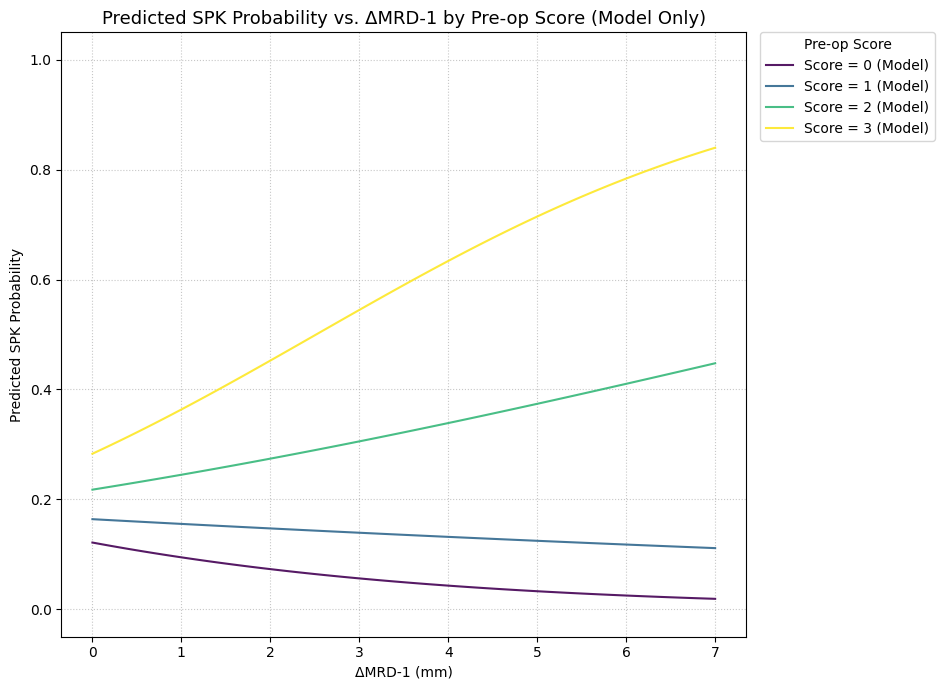


--- Graph 2: Predicted (dotted) vs. Observed (solid, 0.5mm bins) SPK Rate by Score and ΔMRD-1 ---

Overlay SPK Rate plot saved to /content/final_exploration_key_fix_v2/Overlay_SPK_Rate_Plot_MRD_1_pre__1_0_mm_Levator_Function__8_BUT_pre__6_0_sec.png


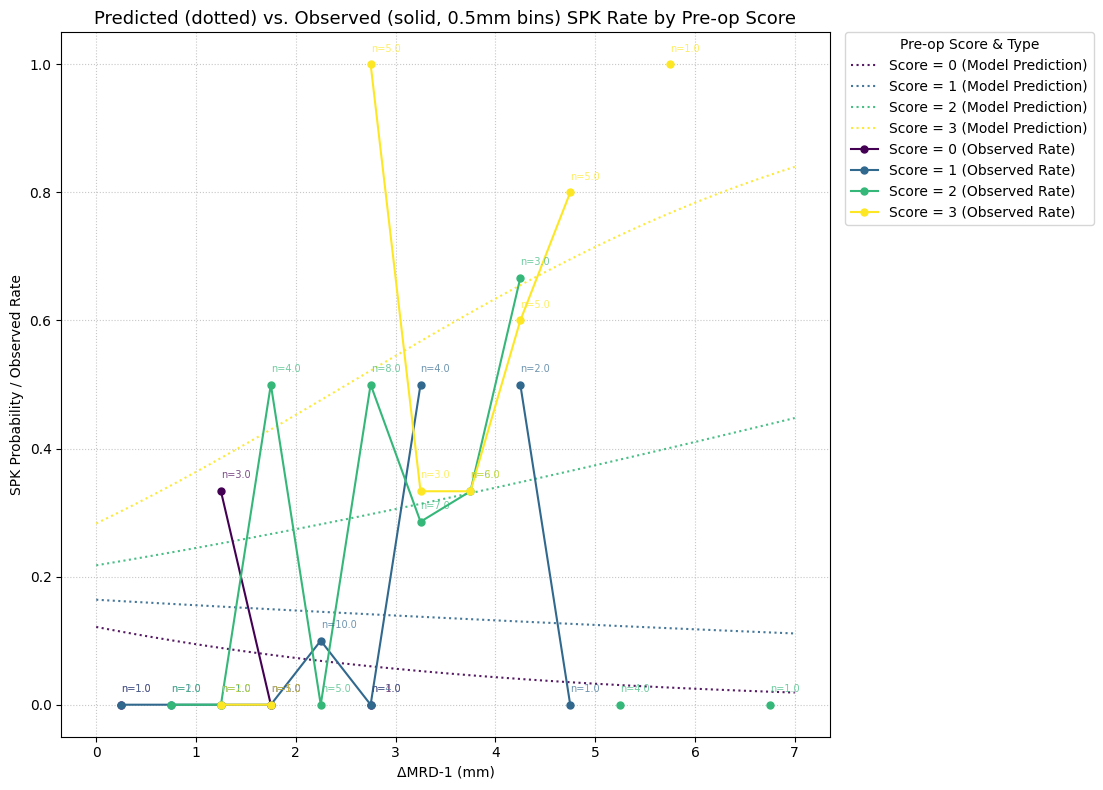


Observed SPK Rates and Case Counts per Bin (for overlay plot):


,calculated_preop_score,ΔMRD-1_bin_center,observed_spk_rate,n_cases
0,0,0.25,0.000000,1
1,0,0.75,NaN,0
2,0,1.25,0.333333,3
3,0,1.75,0.000000,1
4,0,2.25,NaN,0
5,0,2.75,0.000000,1
6,0,3.25,NaN,0
7,0,3.75,NaN,0
8,0,4.25,NaN,0
9,0,4.75,NaN,0




Multi-Parameter Exploration and Optional Detailed Analysis Complete.
Check '/content/final_exploration_key_fix_v2' for outputs.


In [ ]:
# =============================================================
# 眼瞼下垂術後SPKリスク解析：固定因子セット評価版 (多因子パラメータ同時探索 + 重ね描きグラフ - KeyError修正 v2)
# =============================================================

# -------------------------------------------------------------
# 0. ライブラリのインポートと基本設定
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import PerfectSeparationError, ConvergenceWarning

from sklearn.metrics import roc_auc_score, roc_curve

from IPython.display import display
import warnings
import os

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings('ignore', message="Method 'first' requires numeric dtype to function correctly")

print("Libraries imported and warnings configured.")

# -------------------------------------------------------------
# 1. Google Drive マウント と ファイル/フォルダ設定
# -------------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
    output_dir = "/content/final_exploration_key_fix_v2" # 出力フォルダ名変更
    print("Google Drive mounted.")
except ModuleNotFoundError:
    print("Running in a non-Colab environment.")
    file_path = "眼瞼下垂★ドライアイ_kit.xlsx"
    output_dir = "./final_exploration_key_fix_v2"

os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}")

# -------------------------------------------------------------
# 2. データ読み込みと前処理
# -------------------------------------------------------------
print("\n--- 2. Loading and Preprocessing Data ---")
try:
    df_all = pd.read_excel(file_path, sheet_name="対象症例sides", header=0)
    print(f"Excel file loaded successfully. Original shape: {df_all.shape}")
except FileNotFoundError: print(f"Error: File not found at {file_path}"); exit()
except Exception as e: print(f"Error loading Excel file: {e}"); exit()

cols_to_convert = ["MRD-1 pre", "MRD-1 3M", "MRD-2 pre", "MRD-2 3M", "levator_function pre", "BUT pre", "BUT post", "SPK pre", "SPK post"]
for col in cols_to_convert:
    if col in df_all.columns: df_all[col] = pd.to_numeric(df_all[col], errors='coerce')
    else: print(f"Warning: Column '{col}' not found.")

if "MRD-1 3M" in df_all.columns and "MRD-1 pre" in df_all.columns: df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]
else: df_all["ΔMRD-1"] = np.nan
if "MRD-2 3M" in df_all.columns and "MRD-2 pre" in df_all.columns: df_all["ΔMRD-2"] = df_all["MRD-2 3M"] - df_all["MRD-2 pre"]
else: df_all["ΔMRD-2"] = np.nan

if "SPK pre" not in df_all.columns: print("Error: 'SPK pre' column not found."); exit()
df = df_all[df_all["SPK pre"] == 0].copy()
if "SPK post" not in df.columns: print("Error: 'SPK post' column not found."); exit()
df_analysis = df[df['SPK post'].isin([0, 1])].copy()
df_analysis['SPK post'] = df_analysis['SPK post'].astype(int)
target_col = 'SPK post'
print(f"Analysis data shape (SPK pre=0, SPK post=0 or 1): {df_analysis.shape}")
if df_analysis.empty or df_analysis[target_col].nunique() < 2: print("Error: Insufficient data for analysis."); exit()
print(f"Target variable '{target_col}' distribution:\n{df_analysis[target_col].value_counts()}")

# -------------------------------------------------------------
# 3. スコアリングルールと分析対象因子の定義 (パラメータ探索用)
# -------------------------------------------------------------
print("\n--- 3. Defining Master Scoring Rules and Base Factors for Exploration ---")
master_scoring_rules_base = {
    "MRD-1 pre":          {"condition": lambda x: pd.notna(x) and x <= 0.5, "points": 2, "description": "MRD-1 pre <= 0.5 mm (Base)"},
    "levator_function pre": {"condition": lambda x: pd.notna(x) and x < 8.0,  "points": 1, "description": "Levator Function < 8.0 mm (Base)"},
    "BUT pre":            {"condition": lambda x: pd.notna(x) and x < 5.0,  "points": 1, "description": "BUT pre < 5.0 sec (Base)"},
    "ΔMRD-1":             {"condition": lambda x: pd.notna(x) and x >= 2.0, "points": 1, "description": "ΔMRD-1 >= 2.0 mm (Not used for scoring in this CQ)"},
    "BUT post":           {"condition": lambda x: pd.notna(x) and x < 4.0,  "points": 1, "description": "BUT post < 4.0 sec (Not used for scoring in this CQ)"}
}
print("Master scoring rules (initial base for exploration):")
for factor, rule in master_scoring_rules_base.items(): print(f"  - {factor}: Add {rule['points']} point(s) if {rule['description']}")
pre_operative_factors_for_score = ["MRD-1 pre", "levator_function pre", "BUT pre"]
print(f"\nPre-operative factors fixed for scoring: {pre_operative_factors_for_score}")
delta_mrd1_col = "ΔMRD-1"
if delta_mrd1_col not in df_analysis.columns: print(f"Error: Column '{delta_mrd1_col}' not found."); exit()

# -------------------------------------------------------------
# 4. スコアとΔMRD-1の関連性分析関数 (統計量返却 + マージナルエフェクト計算 + 重ね描きグラフ機能付き)
# -------------------------------------------------------------
def analyze_score_vs_delta_mrd1_safety_and_get_metrics(
    df_data, target_variable, score_calc_factors, score_calc_rules,
    delta_mrd_column_name, delta_mrd_range_manual=None, exploration_mode=False
):
    plot_filename_suffix = "plot"
    rules_desc_parts = []
    for factor_name_in_rules in score_calc_factors:
        if factor_name_in_rules in score_calc_rules:
            desc = score_calc_rules[factor_name_in_rules]['description']
            desc_part = ''.join(c if c.isalnum() else '_' for c in desc[:20]).replace("__","_")
            rules_desc_parts.append(desc_part)
    if rules_desc_parts: plot_filename_suffix = "_".join(rules_desc_parts)[:100]

    if not exploration_mode:
        print(f"\n\n===================================================================")
        print(f"=== Detailed Analysis: Score vs. {delta_mrd_column_name} for SPK Safety ===")
        print(f"Using rules for suffix: {plot_filename_suffix}")
        print(f"===================================================================")
        # (スコア算出方法表示は省略)

    if delta_mrd_column_name is None or delta_mrd_column_name not in df_data.columns:
        return {"error": f"delta_mrd_column_name '{delta_mrd_column_name}' is not valid."}

    delta_mrd_values_for_range = df_data[delta_mrd_column_name].dropna()
    if delta_mrd_range_manual is None:
        if delta_mrd_values_for_range.empty: min_delta_val, max_delta_val = 0, 7
        else: min_delta_val, max_delta_val = delta_mrd_values_for_range.min(), delta_mrd_values_for_range.max()
        delta_mrd_range_eval = np.arange(max(0, min_delta_val), max_delta_val + 0.1, 0.1)
        if len(delta_mrd_range_eval) < 2 and min_delta_val == max_delta_val : delta_mrd_range_eval = np.array([min_delta_val, min_delta_val+0.1]) if pd.notna(min_delta_val) else np.array([0,0.1])
        elif len(delta_mrd_range_eval) == 0 : delta_mrd_range_eval = np.array([0,0.1])
    else: delta_mrd_range_eval = delta_mrd_range_manual
    if len(delta_mrd_range_eval) == 0: return {"error": "delta_mrd_range_eval is empty."}

    df_eval = df_data.copy()
    score_col = 'calculated_preop_score'
    def calculate_row_score(row, factors, rules):
        score = 0
        for factor in factors:
            if factor in rules and factor in row and pd.notna(row[factor]):
                try:
                    if rules[factor]['condition'](row[factor]): score += rules[factor]['points']
                except Exception: pass
        return score
    df_eval[score_col] = df_eval.apply(lambda row: calculate_row_score(row, score_calc_factors, score_calc_rules), axis=1)

    analysis_cols = [target_variable, score_col, delta_mrd_column_name]
    df_model_input = df_eval[analysis_cols].dropna()

    model_metrics = {"error": None, "model_converged": False, "AIC": np.nan, "BIC": np.nan, "LLR_p_value": np.nan,
                     "p_value_const": np.nan, "p_value_score": np.nan, "p_value_delta_mrd": np.nan, "p_value_interaction": np.nan, # ★ p_value_interaction
                     "coef_const": np.nan, "coef_score": np.nan, "coef_delta_mrd": np.nan, "coef_interaction": np.nan,
                     "num_obs": df_model_input.shape[0]}

    if df_model_input.shape[0] < 10: model_metrics["error"] = f"Insufficient N ({df_model_input.shape[0]})"; return model_metrics
    if df_model_input[target_variable].nunique() < 2: model_metrics["error"] = "Target < 2 unique"; return model_metrics
    if df_model_input[score_col].nunique() < 1: model_metrics["error"] = "Score no variation"; return model_metrics
    if df_model_input[delta_mrd_column_name].nunique() < 1: model_metrics["error"] = f"{delta_mrd_column_name} no variation"; return model_metrics

    y = df_model_input[target_variable]
    X_df = df_model_input[[score_col, delta_mrd_column_name]].copy()
    clean_score_col = score_col.replace("_","")
    clean_delta_col = delta_mrd_column_name.replace("Δ","d").replace("-","").replace(" ","")
    interaction_col_name = f'{clean_score_col}_x_{clean_delta_col}'
    X_df[interaction_col_name] = X_df[score_col] * X_df[delta_mrd_column_name]
    X = sm.add_constant(X_df)

    model = None
    try:
        if X.shape[1] >= X.shape[0]: model_metrics["error"] = f"Params ({X.shape[1]}) >= Obs ({X.shape[0]})"; return model_metrics
        logit_model = sm.Logit(y, X)
        model = logit_model.fit(disp=0, maxiter=200)
        model_metrics["model_converged"] = model.mle_retvals['converged']
        if model_metrics["model_converged"]:
            model_metrics.update({ "AIC": model.aic, "BIC": model.bic, "LLR_p_value": model.llr_pvalue,
                "p_value_const": model.pvalues.get('const', np.nan), "p_value_score": model.pvalues.get(score_col, np.nan),
                "p_value_delta_mrd": model.pvalues.get(delta_mrd_column_name, np.nan), "p_value_interaction": model.pvalues.get(interaction_col_name, np.nan), # ★ p_value_interaction
                "coef_const": model.params.get('const', np.nan), "coef_score": model.params.get(score_col, np.nan),
                "coef_delta_mrd": model.params.get(delta_mrd_column_name, np.nan), "coef_interaction": model.params.get(interaction_col_name, np.nan) })
            if not exploration_mode:
                print(f"\nScore distribution for this run:\n{df_eval[score_col].value_counts().sort_index().to_string()}"); print(f"\n--- Logistic Regression Model for SPK Risk ---"); print(model.summary())
                unique_scores_display = sorted(df_model_input[score_col].unique())
                print(f"\n--- Marginal Effects: Change in Predicted SPK Probability for a 1mm increase in {delta_mrd_column_name} ---")
                min_delta_int = int(np.floor(delta_mrd_values_for_range.min())) if not delta_mrd_values_for_range.empty else 0
                max_delta_int_limit = int(np.floor(delta_mrd_values_for_range.max())) if not delta_mrd_values_for_range.empty else int(np.floor(delta_mrd_range_eval.max()))
                delta_mrd_baseline_points_for_me = []
                if max_delta_int_limit > min_delta_int: delta_mrd_baseline_points_for_me = list(range(min_delta_int, max_delta_int_limit))
                elif max_delta_int_limit == min_delta_int and min_delta_int == 0 and delta_mrd_values_for_range.max() >=1: delta_mrd_baseline_points_for_me = [0]
                marginal_effects_summary_list = []
                if not delta_mrd_baseline_points_for_me: print(f"  Could not determine baseline points for {delta_mrd_column_name} for marginal effects.")
                else:
                    print(f"  (Calculated for baseline {delta_mrd_column_name} from {min(delta_mrd_baseline_points_for_me)}mm to {max(delta_mrd_baseline_points_for_me)}mm, assessing increase to X+1mm)")
                    for s_val_me in unique_scores_display:
                        for x_base_me in delta_mrd_baseline_points_for_me:
                            pred_data_base_dict = {'const': [1], score_col: [s_val_me], delta_mrd_column_name: [float(x_base_me)], interaction_col_name: [s_val_me * float(x_base_me)]}
                            pred_df_base = pd.DataFrame(pred_data_base_dict, columns=X.columns); prob_base = model.predict(pred_df_base)[0]
                            x_plus1_me = float(x_base_me) + 1.0
                            pred_data_plus1_dict = {'const': [1], score_col: [s_val_me], delta_mrd_column_name: [x_plus1_me], interaction_col_name: [s_val_me * x_plus1_me]}
                            pred_df_plus1 = pd.DataFrame(pred_data_plus1_dict, columns=X.columns); prob_plus1 = model.predict(pred_df_plus1)[0]
                            marginal_effects_summary_list.append({'Score': int(s_val_me), f'{delta_mrd_column_name}_Change': f"{x_base_me:.1f}mm -> {x_plus1_me:.1f}mm", 'SPK_Prob_at_Baseline': f"{prob_base:.2%}", 'SPK_Prob_at_Baseline+1mm': f"{prob_plus1:.2%}", 'Marginal_Effect (ΔP)': f"{prob_plus1 - prob_base:+.2%}"})
                    if marginal_effects_summary_list: display(pd.DataFrame(marginal_effects_summary_list).sort_values(by=['Score', f'{delta_mrd_column_name}_Change']))
                    else: print("  No marginal effects were calculated.")
                print(f"\n--- Graph 1: Predicted SPK Probability (Smooth Model Prediction) vs. {delta_mrd_column_name} by Score ---")
                plt.figure(figsize=(12, 7)); cmap_graph_model = plt.get_cmap('viridis', len(unique_scores_display) if len(unique_scores_display) > 0 else 1)
                for i_graph, s_val_graph in enumerate(unique_scores_display):
                    probs_model_only = []
                    for delta_val_graph in delta_mrd_range_eval:
                        pred_data_dict_graph = {'const': [1], score_col: [s_val_graph], delta_mrd_column_name: [delta_val_graph], interaction_col_name: [s_val_graph * delta_val_graph]}
                        pred_df_graph = pd.DataFrame(pred_data_dict_graph, columns=X.columns)
                        try: probs_model_only.append(model.predict(pred_df_graph)[0])
                        except Exception: probs_model_only.append(np.nan)
                    valid_indices_model_only = ~np.isnan(probs_model_only)
                    if np.any(valid_indices_model_only): plt.plot(delta_mrd_range_eval[valid_indices_model_only], np.array(probs_model_only)[valid_indices_model_only], label=f"Score = {int(s_val_graph)} (Model)", linestyle='-', color=cmap_graph_model(i_graph / max(1,len(unique_scores_display)-1) if len(unique_scores_display)>1 else 0.5), alpha=0.9)
                plt.xlabel(f"{delta_mrd_column_name} (mm)"); plt.ylabel("Predicted SPK Probability"); plt.title(f"Predicted SPK Probability vs. {delta_mrd_column_name} by Pre-op Score (Model Only)", fontsize=13)
                plt.legend(title="Pre-op Score", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.); plt.grid(True, linestyle=':', alpha=0.7); plt.ylim(-0.05, 1.05); plt.tight_layout(rect=[0, 0, 0.80, 1])
                model_only_plot_path = os.path.join(output_dir, f"ModelOnly_SPK_Prob_Plot_{plot_filename_suffix}.png"); plt.savefig(model_only_plot_path, dpi=300); print(f"\nModel-only SPK Probability plot saved to {model_only_plot_path}"); plt.show()
                print(f"\n--- Graph 2: Predicted (dotted) vs. Observed (solid, 0.5mm bins) SPK Rate by Score and {delta_mrd_column_name} ---")
                plt.figure(figsize=(14, 8));
                for i_graph, s_val_graph in enumerate(unique_scores_display):
                    probs_model_overlay = []
                    for delta_val_graph in delta_mrd_range_eval:
                        pred_data_dict_graph = {'const': [1], score_col: [s_val_graph], delta_mrd_column_name: [delta_val_graph], interaction_col_name: [s_val_graph * delta_val_graph]}
                        pred_df_graph = pd.DataFrame(pred_data_dict_graph, columns=X.columns)
                        try: probs_model_overlay.append(model.predict(pred_df_graph)[0])
                        except Exception: probs_model_overlay.append(np.nan)
                    valid_indices_model_overlay = ~np.isnan(probs_model_overlay)
                    if np.any(valid_indices_model_overlay): plt.plot(delta_mrd_range_eval[valid_indices_model_overlay], np.array(probs_model_overlay)[valid_indices_model_overlay], label=f"Score = {int(s_val_graph)} (Model Prediction)", linestyle=':', color=cmap_graph_model(i_graph / max(1,len(unique_scores_display)-1) if len(unique_scores_display)>1 else 0.5), alpha=0.9)
                if pd.notna(min_delta_val) and pd.notna(max_delta_val) and max_delta_val >= min_delta_val:
                    bins_obs = np.arange(np.floor(min_delta_val * 2) / 2, np.ceil(max_delta_val * 2) / 2 + 0.5, 0.5)
                    if len(bins_obs) >= 2:
                        bin_labels_obs = [(bins_obs[i] + bins_obs[i+1]) / 2 for i in range(len(bins_obs)-1)]; df_model_input_copy = df_model_input.copy(); bin_col_name = f'{delta_mrd_column_name}_bin_center'
                        df_model_input_copy[bin_col_name] = pd.cut(df_model_input_copy[delta_mrd_column_name], bins=bins_obs, labels=bin_labels_obs, right=False, include_lowest=True)
                        observed_rates = df_model_input_copy.groupby([score_col, bin_col_name], observed=False).agg(observed_spk_rate=(target_variable, 'mean'), n_cases=(target_variable, 'count')).reset_index()
                        for i_obs, s_val_obs in enumerate(unique_scores_display):
                            score_data_obs = observed_rates[observed_rates[score_col] == s_val_obs]; plot_data_obs = score_data_obs.dropna(subset=[bin_col_name]).sort_values(by=bin_col_name)
                            if not plot_data_obs.empty:
                                plt.plot(plot_data_obs[bin_col_name], plot_data_obs['observed_spk_rate'], label=f"Score = {int(s_val_obs)} (Observed Rate)", marker='o', markersize=5, linestyle='-', color=cmap_graph_model(i_obs / max(1,len(unique_scores_display)-1) if len(unique_scores_display)>1 else 0.5))
                                for _, row_obs in plot_data_obs.iterrows():
                                    if row_obs['n_cases'] > 0 : plt.text(row_obs[bin_col_name], row_obs['observed_spk_rate'] + 0.02, f"n={row_obs['n_cases']}", fontsize=7, alpha=0.7, color=cmap_graph_model(i_obs / max(1,len(unique_scores_display)-1) if len(unique_scores_display)>1 else 0.5))
                    else: print(f"  Cannot create enough bins for {delta_mrd_column_name} to plot observed rates for overlay.")
                else: print(f"  Not enough data range in {delta_mrd_column_name} to create 0.5mm bins for observed rates overlay plot.")
                plt.xlabel(f"{delta_mrd_column_name} (mm)"); plt.ylabel("SPK Probability / Observed Rate"); plt.title(f"Predicted (dotted) vs. Observed (solid, 0.5mm bins) SPK Rate by Pre-op Score", fontsize=13)
                plt.legend(title="Pre-op Score & Type", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.); plt.grid(True, linestyle=':', alpha=0.7); plt.ylim(-0.05, 1.05); plt.tight_layout(rect=[0, 0, 0.80, 1])
                overlay_plot_path = os.path.join(output_dir, f"Overlay_SPK_Rate_Plot_{plot_filename_suffix}.png"); plt.savefig(overlay_plot_path, dpi=300); print(f"\nOverlay SPK Rate plot saved to {overlay_plot_path}"); plt.show()
                if 'observed_rates' in locals() and not observed_rates.empty: print("\nObserved SPK Rates and Case Counts per Bin (for overlay plot):"); display(observed_rates.sort_values(by=[score_col, bin_col_name]))
        else: model_metrics["error"] = "Model did not converge.";
    except PerfectSeparationError: model_metrics["error"] = "Perfect separation detected."
    except Exception as e: model_metrics["error"] = str(e)
    return model_metrics

# -------------------------------------------------------------
# 5. パラメータ探索とメイン評価処理
# -------------------------------------------------------------
print("\n\n--- 5. Parameter Exploration and Main Analysis Process ---")
param_grid = {
    "MRD-1 pre": {"cutoffs": [0.0, 0.5, 1.0], "points_list": [1, 2], "condition_operator": "<="},
    "levator_function pre": {"cutoffs": [7.0, 8.0, 8.5, 9.0], "points_list": [1], "condition_operator": "<"},
    "BUT pre": {"cutoffs": [4.0, 5.0, 6.0], "points_list": [1], "condition_operator": "<"}
}
print(f"\n--- Starting Multi-Parameter Exploration for Pre-operative Score ---")
print(f"Exploring parameters for factors: {pre_operative_factors_for_score}")
print(f"Parameter grid: {param_grid}")

mrd1_params = list(product(param_grid["MRD-1 pre"]["cutoffs"], param_grid["MRD-1 pre"]["points_list"]))
lfp_params = list(product(param_grid["levator_function pre"]["cutoffs"], param_grid["levator_function pre"]["points_list"]))
but_params = list(product(param_grid["BUT pre"]["cutoffs"], param_grid["BUT pre"]["points_list"]))
all_param_combinations = list(product(mrd1_params, lfp_params, but_params))
print(f"Total number of parameter combinations to explore: {len(all_param_combinations)}")

exploration_results = []
iteration_count = 0
for (mrd1_cutoff, mrd1_points), (lfp_cutoff, lfp_points), (but_cutoff, but_points) in all_param_combinations:
    iteration_count += 1
    print(f"\n----- Exploration Iteration {iteration_count} / {len(all_param_combinations)} -----")
    print(f"  MRD-1 pre {param_grid['MRD-1 pre']['condition_operator']} {mrd1_cutoff} (Points: {mrd1_points})")
    print(f"  Levator Func {param_grid['levator_function pre']['condition_operator']} {lfp_cutoff} (Points: {lfp_points})")
    print(f"  BUT pre {param_grid['BUT pre']['condition_operator']} {but_cutoff} (Points: {but_points})")

    current_exploration_rules = {}
    op_mrd1 = param_grid["MRD-1 pre"]["condition_operator"]
    current_exploration_rules["MRD-1 pre"] = {"condition": (lambda x, c=mrd1_cutoff: pd.notna(x) and x <= c) if op_mrd1 == "<=" else (lambda x, c=mrd1_cutoff: pd.notna(x) and x < c), "points": mrd1_points, "description": f"MRD-1 pre {op_mrd1} {mrd1_cutoff} mm"}
    op_lfp = param_grid["levator_function pre"]["condition_operator"]
    current_exploration_rules["levator_function pre"] = {"condition": (lambda x, c=lfp_cutoff: pd.notna(x) and x <= c) if op_lfp == "<=" else (lambda x, c=lfp_cutoff: pd.notna(x) and x < c), "points": lfp_points, "description": f"Levator Function {op_lfp} {lfp_cutoff} mm"}
    op_but = param_grid["BUT pre"]["condition_operator"]
    current_exploration_rules["BUT pre"] = {"condition": (lambda x, c=but_cutoff: pd.notna(x) and x <= c) if op_but == "<=" else (lambda x, c=but_cutoff: pd.notna(x) and x < c), "points": but_points, "description": f"BUT pre {op_but} {but_cutoff} sec"}
    for f_name_master, rule_val_master in master_scoring_rules_base.items():
        if f_name_master not in current_exploration_rules: current_exploration_rules[f_name_master] = rule_val_master.copy()

    active_rules_for_analysis = {f: current_exploration_rules[f] for f in pre_operative_factors_for_score if f in current_exploration_rules}
    current_score_calc_factors_valid = [f for f in pre_operative_factors_for_score if f in active_rules_for_analysis and active_rules_for_analysis[f].get("points", 0) > 0]
    if not current_score_calc_factors_valid:
        exploration_results.append({"MRD1_cut": mrd1_cutoff, "MRD1_pts": mrd1_points, "MRD1_op": op_mrd1, "LFP_cut": lfp_cutoff, "LFP_pts": lfp_points, "LFP_op": op_lfp, "BUT_cut": but_cutoff, "BUT_pts": but_points, "BUT_op": op_but, "Error": "No valid scoring factors", "AIC": np.nan }); continue

    metrics = analyze_score_vs_delta_mrd1_safety_and_get_metrics(
        df_analysis, target_col, current_score_calc_factors_valid, active_rules_for_analysis,
        delta_mrd1_col, delta_mrd_range_manual=None, exploration_mode=True
    )
    result_entry = {
        "MRD1_cut": mrd1_cutoff, "MRD1_pts": mrd1_points, "MRD1_op": op_mrd1,
        "LFP_cut": lfp_cutoff,   "LFP_pts": lfp_points,   "LFP_op": op_lfp,
        "BUT_cut": but_cutoff,   "BUT_pts": but_points,   "BUT_op": op_but,
        "N_Obs": metrics.get("num_obs"), "Converged": metrics.get("model_converged", False),
        "AIC": metrics.get("AIC"), "BIC": metrics.get("BIC"),
        "LLR_p_value": metrics.get("LLR_p_value"),      # ★キー名を統一 (LLRp -> LLR_p_value)
        "p_value_score": metrics.get("p_value_score"),
        "p_value_delta_mrd": metrics.get("p_value_delta_mrd"),
        "p_value_interaction": metrics.get("p_value_interaction"), # ★キー名を統一 (P_interact -> p_value_interaction)
        "C_score": metrics.get("coef_score"), "C_delta": metrics.get("coef_delta_mrd"),
        "C_interact": metrics.get("coef_interaction"), "Error": metrics.get("error")
    }
    exploration_results.append(result_entry)

if exploration_results:
    results_df = pd.DataFrame(exploration_results)
    print("\n\n--- Multi-Parameter Exploration Results ---")
    cols_to_display = [
        "MRD1_cut", "MRD1_pts", "MRD1_op", "LFP_cut", "LFP_pts", "LFP_op", "BUT_cut", "BUT_pts", "BUT_op",
        "N_Obs", "Converged", "AIC",
        "LLR_p_value",      # ★キー名を統一
        "p_value_score", "p_value_delta_mrd",
        "p_value_interaction", # ★キー名を統一
        "C_interact", "Error"
    ]
    display_df = results_df[[col for col in cols_to_display if col in results_df.columns]].copy()
    display_df_sorted = display_df[pd.notna(display_df["AIC"])].sort_values(
        by=["AIC", "LLR_p_value", "p_value_interaction"] # ★キー名を統一
    )
    display(display_df_sorted.head(30))
    csv_path = os.path.join(output_dir, "parameter_exploration_summary.csv")
    try: display_df_sorted.to_csv(csv_path, index=False); print(f"\nExploration summary saved to: {csv_path}")
    except Exception as e_csv: print(f"Error saving exploration summary to CSV: {e_csv}")
else: print("\nNo exploration results to display.")

if exploration_results and not display_df_sorted.empty:
    print("\n--- Running Detailed Analysis with Best Parameters found (e.g., by AIC) ---")
    best_params_candidates = display_df_sorted[(display_df_sorted["Converged"] == True) & (display_df_sorted["Error"].isna())]
    if not best_params_candidates.empty:
        best_params_row = best_params_candidates.iloc[0]
        print("\nBest parameters selected for detailed analysis (based on AIC, LLR_p_value, p_value_interaction sort):") # ★ p_value_interaction
        print(best_params_row)

        final_rules = {}
        op_mrd1_final = best_params_row["MRD1_op"]
        final_rules["MRD-1 pre"] = {"condition": (lambda x, c=best_params_row["MRD1_cut"]: pd.notna(x) and x <= c) if op_mrd1_final == "<=" else (lambda x, c=best_params_row["MRD1_cut"]: pd.notna(x) and x < c), "points": int(best_params_row["MRD1_pts"]), "description": f"MRD-1 pre {op_mrd1_final} {best_params_row['MRD1_cut']:.1f} mm"}
        op_lfp_final = best_params_row["LFP_op"]
        final_rules["levator_function pre"] = {"condition": (lambda x, c=best_params_row["LFP_cut"]: pd.notna(x) and x <= c) if op_lfp_final == "<=" else (lambda x, c=best_params_row["LFP_cut"]: pd.notna(x) and x < c), "points": int(best_params_row["LFP_pts"]), "description": f"Levator Function {op_lfp_final} {best_params_row['LFP_cut']:.1f} mm"}
        op_but_final = best_params_row["BUT_op"]
        final_rules["BUT pre"] = {"condition": (lambda x, c=best_params_row["BUT_cut"]: pd.notna(x) and x <= c) if op_but_final == "<=" else (lambda x, c=best_params_row["BUT_cut"]: pd.notna(x) and x < c), "points": int(best_params_row["BUT_pts"]), "description": f"BUT pre {op_but_final} {best_params_row['BUT_cut']:.1f} sec"}
        for f_name_master, rule_val_master in master_scoring_rules_base.items():
            if f_name_master not in final_rules: final_rules[f_name_master] = rule_val_master.copy()
        final_score_factors = [f for f in pre_operative_factors_for_score if f in final_rules and final_rules[f]["points"] > 0]

        analyze_score_vs_delta_mrd1_safety_and_get_metrics(
            df_analysis, target_col, final_score_factors, final_rules, delta_mrd1_col,
            delta_mrd_range_manual=None, exploration_mode=False
        )
    else: print("\nNo converged models without errors found in exploration to run detailed analysis.")
else: print("\nNo best parameters found from exploration to run detailed analysis or exploration_results is empty.")

print("\n\nMulti-Parameter Exploration and Optional Detailed Analysis Complete.")
print(f"Check '{output_dir}' for outputs.")